# A Comparison of QCluster and isONclust for Clustering Synthetic Sequences

## Abstract

In this project, we examine and compare two open-source software tools for the task of clustering short-read sequences according to their gene family of origin: [QCluster](https://github.com/CominLab/QCluster) and [isONclust](https://github.com/ksahlin/isONclust). We perform our analysis on six synthetic datasets simulated using `100` sequences selected from the human cDNA assembly `GRCh38.p13`. These datasets have `10000`,`20000`, and `50000` synthetic sequences, with two different fixed readdepths (100bp and 700bp) and uniform simulated read errors. The purpose of our experiment is to evaluatehow well QCluster and isONclust are able to cluster the simulated sequences with respect to the original `100` human cDNA sequences. We repeat our experiments using several configurations offered by the two softwaretools. We assess the quality of the clustering results using multiple external validation metrics, like *V-Measure* and *Adjusted Mutual Information*, and we empirically determine the interactions between the configuration parameters of the software using plot visualizations. Moreover, we compare the clustering results with theoutcome of a random baseline clustering method.

## Links

- [Primary repository](https://github.com/jkomyno/bioalgo-QCluster-vs-isONclust)
- [Project report](https://github.com/jkomyno/bioalgo-QCluster-vs-isONclust/blob/master/report.pdf)

## Google Drive

This notebook assumes that the `data/quality` folder is copied to a Google Drive folder named `bioalgo/quality`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!ls /content/drive/MyDrive/bioalgo/quality

isONclust  qCluster  random_cluster


In [ ]:
from os import path
from glob import glob
from operator import itemgetter

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
!pip install pampy

In [ ]:
# install latex
!apt update
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng --fix-missing

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [44.8 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use('pgf')
matplotlib.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Latin Modern',
    'text.latex.preamble': r'\usepackage{lmodern}',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

SMALL_SIZE = 13.5
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

In [ ]:
import re
from collections import defaultdict
from pampy import match

In [ ]:
N_CLUSTERS_GROUND_TRUTH = 100

In [ ]:
PLOTS = '/content/drive/MyDrive/bioalgo/plots/'

In [ ]:
def get_params_key(filename: str, tool):
  if tool == 'random_cluster':
    return 'random'
  return filename.split('_')[-2]

In [ ]:
def create_sub_dict_from_grid_params(grid_params):
  s = grid_params.split('-')
  if len(s) == 1:
    return {}
  
  return dict(zip(s[::2], s[1::2]))

In [ ]:
def read_csv(filepath: str):
  return pd.read_csv(filepath, sep=',', decimal='.', encoding='utf-8',
                     index_col=None)

In [ ]:
DISTANCE_CHI_SQUARE = r'$\mathrm{X}^2$'
DISTANCE_EUCLIDEAN = r'$L_{2}$'
DISTANCE_D2_STAR = r'$D^{*q}_{2}$'


def qCluster_distance_to_str(distance: str):
  return {
    'c': DISTANCE_CHI_SQUARE,
    'e': DISTANCE_EUCLIDEAN,
    'a': DISTANCE_D2_STAR
  }[distance]

In [ ]:
def import_cumulative_n_clusters_csv(tool: str):
  df_list = []
  base_path = path.join('/content/drive/MyDrive/bioalgo/quality', tool)
  for n_clusters_csv in glob(path.join(base_path, 'n-*', '*_n_clusters.csv')):
    filename = path.splitext(path.basename(n_clusters_csv))[0]
    dataset = path.basename(path.dirname(n_clusters_csv))

    # e.g. k-4-w-20 (isONclust) or d-c-k-4 (qCluster)
    grid_params_str = filename.split('_')[0]

    n, fl = itemgetter('n', 'fl')(create_sub_dict_from_grid_params(dataset))
    n_simulated, read_length = int(n), int(fl)

    curr_df = read_csv(n_clusters_csv)
    curr_df = curr_df.assign(dataset=dataset,
                             n_simulated=n_simulated,
                             read_length=read_length)
    
    # e.g. {
    #   'k': '4',
    #   'w': '20',
    # }
    grid_params_dict = create_sub_dict_from_grid_params(grid_params_str)
    
    if tool == 'qCluster':
      kmer_length, distance = itemgetter('k', 'd')(grid_params_dict)
      kmer_length, distance = int(kmer_length), qCluster_distance_to_str(distance)
      curr_df = curr_df.assign(distance=distance)
    elif tool == 'isONclust':
      kmer_length, window = itemgetter('k', 'w')(grid_params_dict)
      kmer_length, window = int(kmer_length), int(window)
      curr_df = curr_df.assign(window=window)

    curr_df = curr_df.assign(kmer_length=kmer_length)
    df_list.append(curr_df)

  return pd.concat(df_list)

In [ ]:
def import_cumulative_quality_csv(tool: str):
  """
  The quality csv files for the given clustering tool ('qCluster' | 'isONclust')
  are imported into a Pandas dataframe, merged together and returned.
  """
  from pampy import _
  
  df_list = []
  base_path = path.join('/content/drive/MyDrive/bioalgo/quality', tool)
  for quality_csv in glob(path.join(base_path, 'n-*', '*_quality.csv')):
    filename = path.splitext(path.basename(quality_csv))[0]
    dataset = path.basename(path.dirname(quality_csv))

    quality_type = match(filename,
                      re.compile('^no_singleton'), 'no_singleton',
                      re.compile('^no_trivial'), 'no_trivial',
                      _, 'normal')
    
    # e.g. k-4-w-20 (isONclust) or d-c-k-4 (qCluster)
    grid_params_str = filename.split('_')[-2]

    n, fl = itemgetter('n', 'fl')(create_sub_dict_from_grid_params(dataset))
    n_simulated, read_length = int(n), int(fl)

    curr_df = read_csv(quality_csv)
    curr_df = curr_df.assign(dataset=dataset,
                             n_simulated=n_simulated,
                             read_length=read_length,
                             quality_type=quality_type)
    
    # e.g. {
    #   'k': '4',
    #   'w': '20',
    # }
    grid_params_dict = create_sub_dict_from_grid_params(grid_params_str)
    
    if tool == 'qCluster':
      kmer_length, distance = itemgetter('k', 'd')(grid_params_dict)
      kmer_length, distance = int(kmer_length), qCluster_distance_to_str(distance)
      curr_df = curr_df.assign(distance=distance)
    elif tool == 'isONclust':
      kmer_length, window = itemgetter('k', 'w')(grid_params_dict)
      kmer_length, window = int(kmer_length), int(window)
      curr_df = curr_df.assign(window=window)

    curr_df = curr_df.assign(kmer_length=kmer_length)
    df_list.append(curr_df)

  return pd.concat(df_list)

In [ ]:
def import_random_cluster_csv():
  """
  The quality csv files for the randomized basline clustering are imported into
  a Pandas dataframe, merged together and returned.
  """
  df_list = []
  base_path = path.join('/content/drive/MyDrive/bioalgo/quality', 'random_cluster')
  for quality_csv in glob(path.join(base_path, 'n-*', '*.csv')):
    filename = path.splitext(path.basename(quality_csv))[0]
    dataset = path.basename(path.dirname(quality_csv))
    quality_type = 'normal'

    n, fl = itemgetter('n', 'fl')(create_sub_dict_from_grid_params(dataset))
    n_simulated, read_length = int(n), int(fl)

    curr_df = read_csv(quality_csv)
    curr_df = curr_df.assign(dataset=dataset,
                             n_simulated=n_simulated,
                             read_length=read_length,
                             quality_type=quality_type)
    df_list.append(curr_df)

  return pd.concat(df_list)

## Import statistics about number of clusters grouped by quality type (non trivial, trivial, singleton)

#### qCluster

In [ ]:
qCluster_n_clusters_csv = import_cumulative_n_clusters_csv('qCluster')
qCluster_n_clusters_csv.sort_values(by=['dataset', 'kmer_length'], axis=0, ascending=True, inplace=True)
qCluster_n_clusters_csv.head(10)

k  k_non_trivial  k_trivial  ...  read_length        distance  kmer_length
0  100             98          2  ...          100    $D^{*q}_{2}$            4
0  100             98          2  ...          100  $\mathrm{X}^2$            4
0  100            100          0  ...          100         $L_{2}$            4
0  100             44         56  ...          100    $D^{*q}_{2}$            5
0  100             34         66  ...          100  $\mathrm{X}^2$            5
0  100             46         54  ...          100         $L_{2}$            5
0  100              3         97  ...          100    $D^{*q}_{2}$            6
0  100              6         94  ...          100  $\mathrm{X}^2$            6
0  100             16         84  ...          100         $L_{2}$            6
0  100              7         93  ...          100    $D^{*q}_{2}$            7

[10 rows x 9 columns]

#### isONclust

In [ ]:
isONclust_n_clusters_csv = import_cumulative_n_clusters_csv('isONclust')
isONclust_n_clusters_csv.sort_values(by=['dataset', 'kmer_length'], axis=0, ascending=True, inplace=True)
isONclust_n_clusters_csv.head(10)

k  k_non_trivial  k_trivial  ...  read_length window  kmer_length
0  1285            310        975  ...          100     20            4
0  9876              3       9873  ...          100     50            4
0  5653            175       5478  ...          100     20            5
0  9947              0       9947  ...          100     50            5
0  7400             10       7390  ...          100     20            6
0  9978              0       9978  ...          100     50            6
0  7569              5       7564  ...          100     20            7
0  9986              0       9986  ...          100     50            7
0  7505              4       7501  ...          100     20            8
0  9986              0       9986  ...          100     50            8

[10 rows x 9 columns]

## Import quality metrics

#### qCluster

In [ ]:
qCluster_csv = import_cumulative_quality_csv('qCluster')
qCluster_csv.sort_values(by=['dataset', 'kmer_length', 'quality_type'], axis=0, ascending=True, inplace=True)
qCluster_csv.head(5)

homogeneity  completeness  ...        distance  kmer_length
0     0.203409      0.210893  ...    $D^{*q}_{2}$            4
0     0.201985      0.210991  ...  $\mathrm{X}^2$            4
0     0.207282      0.212226  ...         $L_{2}$            4
0     0.203064      0.210633  ...    $D^{*q}_{2}$            4
0     0.201853      0.210901  ...  $\mathrm{X}^2$            4

[5 rows x 19 columns]

isONclust

In [ ]:
isONclust_csv = import_cumulative_quality_csv('isONclust')
isONclust_csv.sort_values(by=['dataset', 'kmer_length', 'quality_type'], axis=0, ascending=True, inplace=True)
isONclust_csv.head(5)

homogeneity  completeness  v_measure  ...  quality_type  window  kmer_length
0     0.339089      0.274518   0.303406  ...  no_singleton      20            4
0     0.780653      0.769969   0.775274  ...  no_singleton      50            4
0     0.281092      0.245773   0.262249  ...    no_trivial      20            4
0     0.387204      1.000000   0.558251  ...    no_trivial      50            4
0     0.379323      0.293062   0.330659  ...        normal      20            4

[5 rows x 19 columns]

#### random baseline

In [ ]:
random_cluster_csv = import_random_cluster_csv()
random_cluster_csv.sort_values(by=['dataset'], axis=0, ascending=True, inplace=True)
random_cluster_csv.head()

homogeneity  completeness  v_measure  ...  n_simulated  read_length  quality_type
0       0.1217        0.1216     0.1217  ...        10000          100        normal
0       0.1198        0.1197     0.1197  ...        10000          700        normal
0       0.0600        0.0600     0.0600  ...        20000          100        normal
0       0.0602        0.0602     0.0602  ...        20000          700        normal
0       0.0230        0.0230     0.0230  ...        50000          100        normal

[5 rows x 17 columns]

## Number of clusters per quality type

In [ ]:
import seaborn as sns

%matplotlib inline

def set_seaborn_theme(palette=None):
  if palette is None:
    palette = sns.diverging_palette(h_neg=248, h_pos=2, s=74, l=43, sep=2, n=6, center='light')

  sns.set_theme(context='paper',
                style='whitegrid',
                palette=palette,
                rc={
                    "font.size": SMALL_SIZE,             # controls default text sizes
                    "xtick.labelsize": SMALL_SIZE,       # x axes tick label
                    "ytick.labelsize": SMALL_SIZE,       # y axes tick labels
                    "axes.labelsize": BIGGER_SIZE,       # x and y title labels
                    "legend.fontsize": MEDIUM_SIZE,      # legend font size
                    "legend.title_fontsize": MEDIUM_SIZE # legend title size
                })

In [ ]:
def stack_n_clusters_df(data: pd.DataFrame, by: str = 'kmer_length'):
  df = selected_df[[by, 'k_non_trivial', 'k_trivial', 'k_singleton']] \
    .set_index(by, append=True) \
    .stack(level=-1) \
    .reset_index(level=0, drop=True) \
    .to_frame() \
    .reset_index() \
    .rename(columns={'level_1': 'quality_type', 0: 'n_cluster'})
  
  df['quality_type'].replace({
    'k_non_trivial': 'Non-trivial',
    'k_trivial': 'Trivial',
    'k_singleton': 'Singleton',
  }, inplace=True)
  
  return df

In [ ]:
def plot_n_clusters(tool, df, x, xlabel, postfix=''):
  fig, ax = plt.subplots()
  fig.set_size_inches(6.5, 4)
  set_seaborn_theme()

  data = stack_n_clusters_df(df)

  ax = sns.barplot(x=data[x], y=data['n_cluster'], data=data, hue='quality_type', ci=None)
  
  # Put the legend out of the figure
  plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0, title='Quality type', title_fontsize='large')

  ax.set_xlabel(xlabel)
  ax.set_ylabel('$N$ clusters')

  a = [p.get_height() for p in ax.patches]
  patch = [p for p in ax.patches]

  for p in ax.patches:
    ax.annotate(int(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='gray', xytext=(0, 5),
                textcoords='offset points')

  sns.despine(ax=ax)

  filename = f'{PLOTS}{tool}-n_clusters_vs_{x}_by_quality_type{postfix}.pdf'
  print(filename)
  fig.savefig(filename, dpi=100, bbox_inches='tight')

### QCluster

#### Distance: $L_2$

In [ ]:
distance = DISTANCE_EUCLIDEAN

/content/drive/MyDrive/bioalgo/plots/qCluster-n_clusters_vs_kmer_length_by_quality_type-d_EUCLIDEAN-n_50000-fl_100.pdf


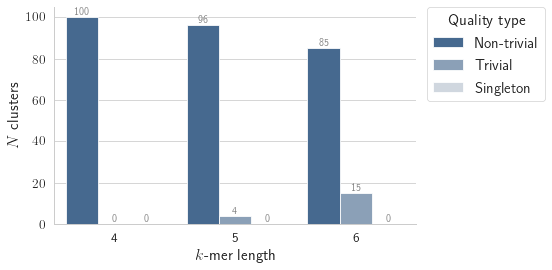

In [ ]:
n_simulated = 50000
read_length = 100
selected_df = qCluster_n_clusters_csv \
  .query(f'k == {N_CLUSTERS_GROUND_TRUTH} & distance == "{distance}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_n_clusters(tool='qCluster', df=selected_df, x='kmer_length', xlabel='$k$-mer length', postfix=f'-d_EUCLIDEAN-n_{n_simulated}-fl_{read_length}')

/content/drive/MyDrive/bioalgo/plots/qCluster-n_clusters_vs_kmer_length_by_quality_type-d_EUCLIDEAN-n_50000-fl_700.pdf


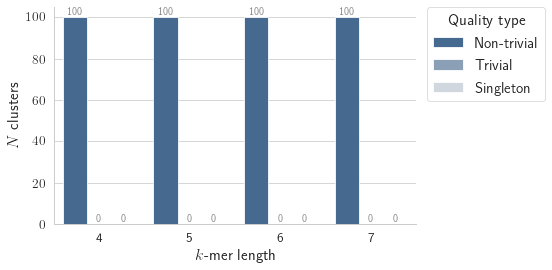

In [ ]:
n_simulated = 50000
read_length = 700
selected_df = qCluster_n_clusters_csv \
  .query(f'k == {N_CLUSTERS_GROUND_TRUTH} & distance == "{distance}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_n_clusters(tool='qCluster', df=selected_df, x='kmer_length', xlabel='$k$-mer length', postfix=f'-d_EUCLIDEAN-n_{n_simulated}-fl_{read_length}')

#### Distance: $\chi^2$

In [ ]:
distance = DISTANCE_CHI_SQUARE

/content/drive/MyDrive/bioalgo/plots/qCluster-n_clusters_vs_kmer_length_by_quality_type-d_CHI_SQUARE-n_50000-fl_100.pdf


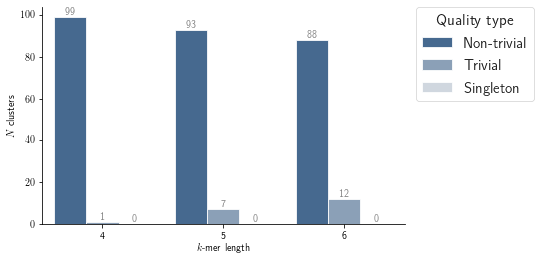

In [ ]:
n_simulated = 50000
read_length = 100
selected_df = qCluster_n_clusters_csv \
  .query(f'k == {N_CLUSTERS_GROUND_TRUTH} & distance == "{distance}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_n_clusters(tool='qCluster', df=selected_df, x='kmer_length', xlabel='$k$-mer length', postfix=f'-d_CHI_SQUARE-n_{n_simulated}-fl_{read_length}')

/content/drive/MyDrive/bioalgo/plots/qCluster-n_clusters_vs_kmer_length_by_quality_type-d_CHI_SQUARE-n_50000-fl_700.pdf


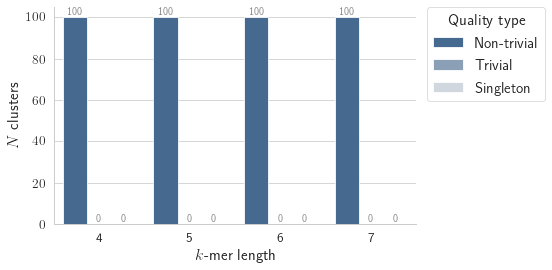

In [ ]:
n_simulated = 50000
read_length = 700
selected_df = qCluster_n_clusters_csv \
  .query(f'k == {N_CLUSTERS_GROUND_TRUTH} & distance == "{distance}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_n_clusters(tool='qCluster', df=selected_df, x='kmer_length', xlabel='$k$-mer length', postfix=f'-d_CHI_SQUARE-n_{n_simulated}-fl_{read_length}')

#### Distance: $D^{*q}_{2}$

In [ ]:
distance = DISTANCE_D2_STAR

/content/drive/MyDrive/bioalgo/plots/qCluster-n_clusters_vs_kmer_length_by_quality_type-d_D2_STAR-n_50000-fl_100.pdf


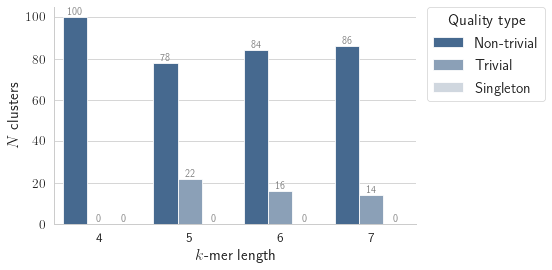

In [ ]:
n_simulated = 50000
read_length = 100
selected_df = qCluster_n_clusters_csv \
  .query(f'k == {N_CLUSTERS_GROUND_TRUTH} & distance == "{distance}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_n_clusters(tool='qCluster', df=selected_df, x='kmer_length', xlabel='$k$-mer length', postfix=f'-d_D2_STAR-n_{n_simulated}-fl_{read_length}')

/content/drive/MyDrive/bioalgo/plots/qCluster-n_clusters_vs_kmer_length_by_quality_type-d_D2_STAR-n_50000-fl_700.pdf


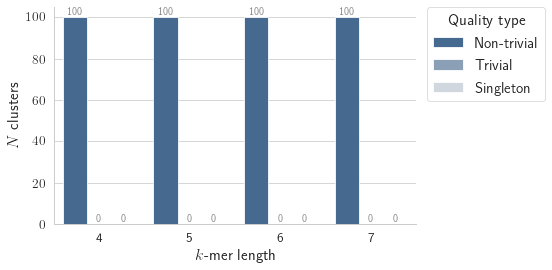

In [ ]:
n_simulated = 50000
read_length = 700
selected_df = qCluster_n_clusters_csv \
  .query(f'k == {N_CLUSTERS_GROUND_TRUTH} & distance == "{distance}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_n_clusters(tool='qCluster', df=selected_df, x='kmer_length', xlabel='$k$-mer length', postfix=f'-d_D2_STAR-n_{n_simulated}-fl_{read_length}')

### isONclust

#### Window size: 20

In [ ]:
window = 20

/content/drive/MyDrive/bioalgo/plots/isONclust-n_clusters_vs_kmer_length_by_quality_type-w_20-n_50000-fl_100.pdf


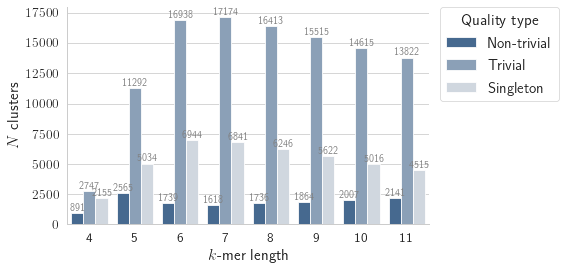

In [ ]:
n_simulated = 50000
read_length = 100
selected_df = isONclust_n_clusters_csv \
  .query(f'window == "{window}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_n_clusters(tool='isONclust', df=selected_df, x='kmer_length', xlabel='$k$-mer length', postfix=f'-w_{window}-n_{n_simulated}-fl_{read_length}')

/content/drive/MyDrive/bioalgo/plots/isONclust-n_clusters_vs_kmer_length_by_quality_type-w_20-n_50000-fl_700.pdf


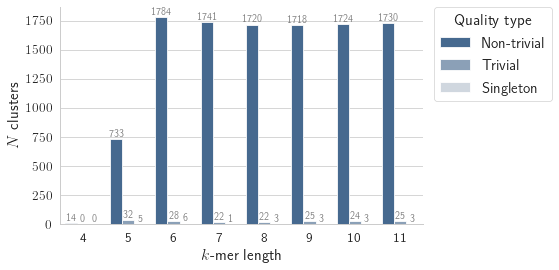

In [ ]:
n_simulated = 50000
read_length = 700
selected_df = isONclust_n_clusters_csv \
  .query(f'window == "{window}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_n_clusters(tool='isONclust', df=selected_df, x='kmer_length', xlabel='$k$-mer length', postfix=f'-w_{window}-n_{n_simulated}-fl_{read_length}')

## Window size: 50

In [ ]:
window = 50

/content/drive/MyDrive/bioalgo/plots/isONclust-n_clusters_vs_kmer_length_by_quality_type-w_50-n_50000-fl_100.pdf


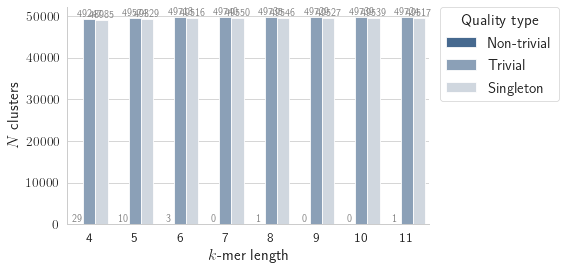

In [ ]:
n_simulated = 50000
read_length = 100
selected_df = isONclust_n_clusters_csv \
  .query(f'window == "{window}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_n_clusters(tool='isONclust', df=selected_df, x='kmer_length', xlabel='$k$-mer length', postfix=f'-w_{window}-n_{n_simulated}-fl_{read_length}')

/content/drive/MyDrive/bioalgo/plots/isONclust-n_clusters_vs_kmer_length_by_quality_type-w_50-n_50000-fl_700.pdf


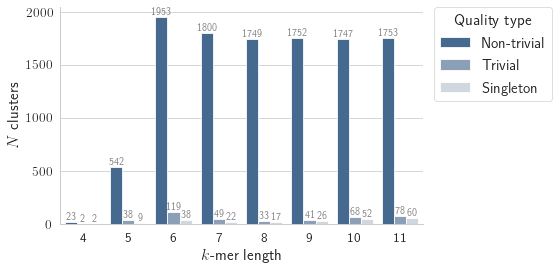

In [ ]:
n_simulated = 50000
read_length = 700
selected_df = isONclust_n_clusters_csv \
  .query(f'window == "{window}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_n_clusters(tool='isONclust', df=selected_df, x='kmer_length', xlabel='$k$-mer length', postfix=f'-w_{window}-n_{n_simulated}-fl_{read_length}')

## Baseline random clustering metrics

Homogeneity, Completeness and Adjusted Rand-Index score in the random clustering results.


In [ ]:
def plot_main_metrics_vs_x_by_hue(tool, data, x, xlabel, hue, huelabel, ylim=None, postfix=''):
  """
  Plot Homogeneity, Completeness, V-Measure, Adjusted Rand Index,
  Adjusted Mutual Information, Purity 
  """
  my_palette = sns.diverging_palette(h_neg=248, h_pos=2, s=74, l=43, sep=2, n=6, center='light')
  set_seaborn_theme(palette=my_palette)

  fig, axs = plt.subplots(nrows=2, ncols=3)
  fig.set_size_inches(20, 10)
  # plt.subplots_adjust(wspace=.4)

  # y metric, y label
  ys = [
    [
      ('homogeneity', 'Homogeneity'),
      ('completeness', 'Completeness'),
      ('v_measure', 'V-Measure')
    ],
    [
      ('adjusted_mutual_information', 'Adjusted Mutual Information'),
      ('adjusted_rand_index', 'Adjusted Rand Index'),
      ('purity', 'Purity'),
    ]
  ]

  for j, row in enumerate(axs):
    for i, (y, ylabel) in enumerate(ys[j]):
      sns.pointplot(data=data, x=x, y=y, hue=hue,
                    ax=row[i], dodge=True, palette='Purples')
      row[i].get_legend().set_title(huelabel)
      row[i].set_xlabel(xlabel)
      row[i].set_ylabel(ylabel)

      if ylim is not None:
        row[i].set_ylim(ylim)
    
  sns.despine(fig=fig)

  # for some reason, pgf doesn't work
  filename = f'{PLOTS}{tool}-metrics_vs_{x}_by_{hue}{postfix}.pdf'
  print(filename)
  fig.savefig(filename, dpi=100, bbox_inches='tight')

/content/drive/MyDrive/bioalgo/plots/random_cluster-metrics_vs_n_simulated_by_read_length.pdf


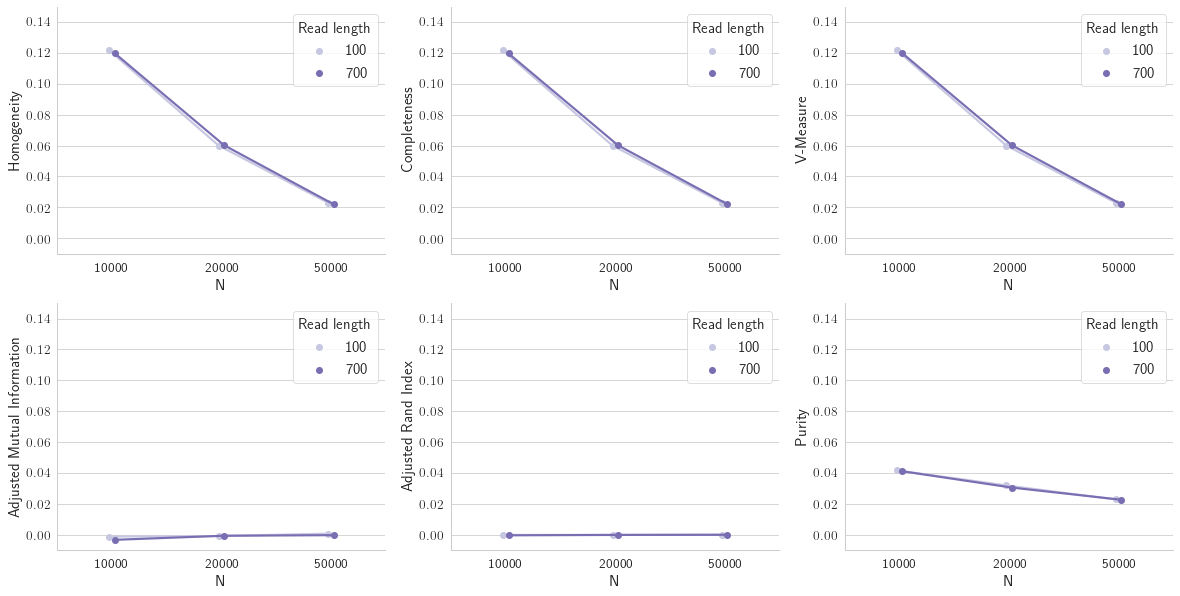

In [ ]:
plot_main_metrics_vs_x_by_hue(tool='random_cluster', data=random_cluster_csv,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length',
                              ylim=(-0.01, 0.15))

In [ ]:
# matplotlib.rcParams.keys()

In [ ]:
def plot_kmer_vs_metric_by_dataset(tool, data, y, ylabel, postfix=''):
  my_palette = sns.diverging_palette(h_neg=248, h_pos=2, s=74, l=43, sep=2, n=6, center='light')
  fig, ax = plt.subplots()
  fig.set_size_inches(5.5, 2.54)
  
  set_seaborn_theme(palette=my_palette)

  ax = sns.barplot(x=data['kmer_length'], y=data[y], data=data, hue='dataset', ci=None)
  # Put the legend out of the figure
  plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., title='Dataset', title_fontsize='large')

  ax.set_xlabel('$k$-mer length')
  ax.set_ylabel(ylabel)

  sns.despine(ax=ax)

  filename = f'{PLOTS}{tool}-x_kmer_length-y_{y}-hue_dataset{postfix}.pgf'
  print(filename)
  fig.savefig(filename, dpi=100, bbox_inches='tight')
  fig.savefig(f'{tool}-x_kmer_length-y_{y}-hue_dataset{postfix}.png', dpi=100)
  

## qCluster metrics


### Fix quality_type to normal, show how the different metrics changed w.r.t. k-mer's length, discriminating by dataset.



In [ ]:
selected_df = qCluster_csv.query('quality_type == "normal"')

In [ ]:
my_palette = sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

/content/drive/MyDrive/bioalgo/plots/qCluster-x_kmer_length-y_homogeneity-hue_dataset.pgf


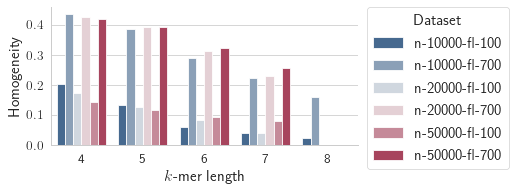

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='qCluster', data=selected_df, y='homogeneity', ylabel='Homogeneity')

/content/drive/MyDrive/bioalgo/plots/qCluster-x_kmer_length-y_completeness-hue_dataset.pgf


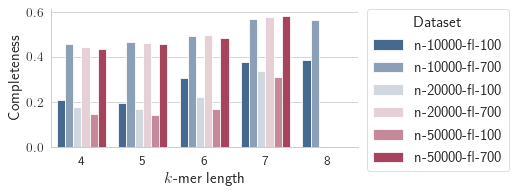

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='qCluster', data=selected_df, y='completeness', ylabel='Completeness')

/content/drive/MyDrive/bioalgo/plots/qCluster-x_kmer_length-y_v_measure-hue_dataset.pgf


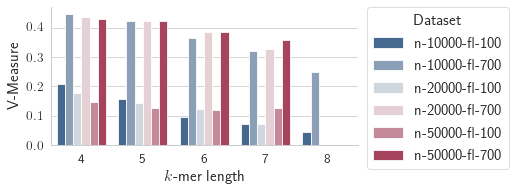

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='qCluster', data=selected_df, y='v_measure', ylabel='V-Measure')

/content/drive/MyDrive/bioalgo/plots/qCluster-x_kmer_length-y_adjusted_mutual_information-hue_dataset.pgf


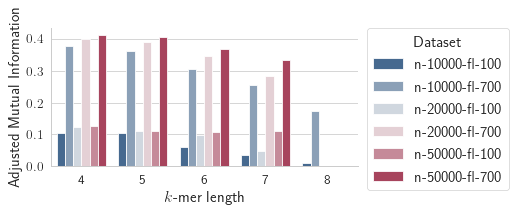

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='qCluster', data=selected_df, y='adjusted_mutual_information', ylabel='Adjusted Mutual Information')

/content/drive/MyDrive/bioalgo/plots/qCluster-x_kmer_length-y_adjusted_rand_index-hue_dataset.pgf


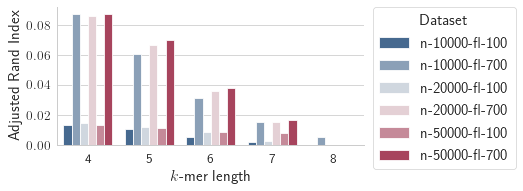

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='qCluster', data=selected_df, y='adjusted_rand_index', ylabel='Adjusted Rand Index')

/content/drive/MyDrive/bioalgo/plots/qCluster-x_kmer_length-y_purity-hue_dataset.pgf


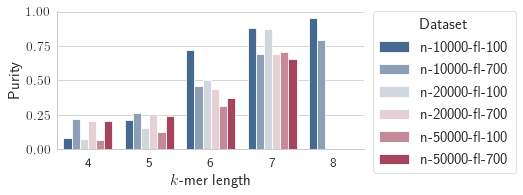

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='qCluster', data=selected_df, y='purity', ylabel='Purity')

### Fix kmer length, compare cluster metrics against the number of simulated reads in the dataset, discriminating by length of those reads (100 or 700).

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_n_simulated_by_read_length-k_4.pdf


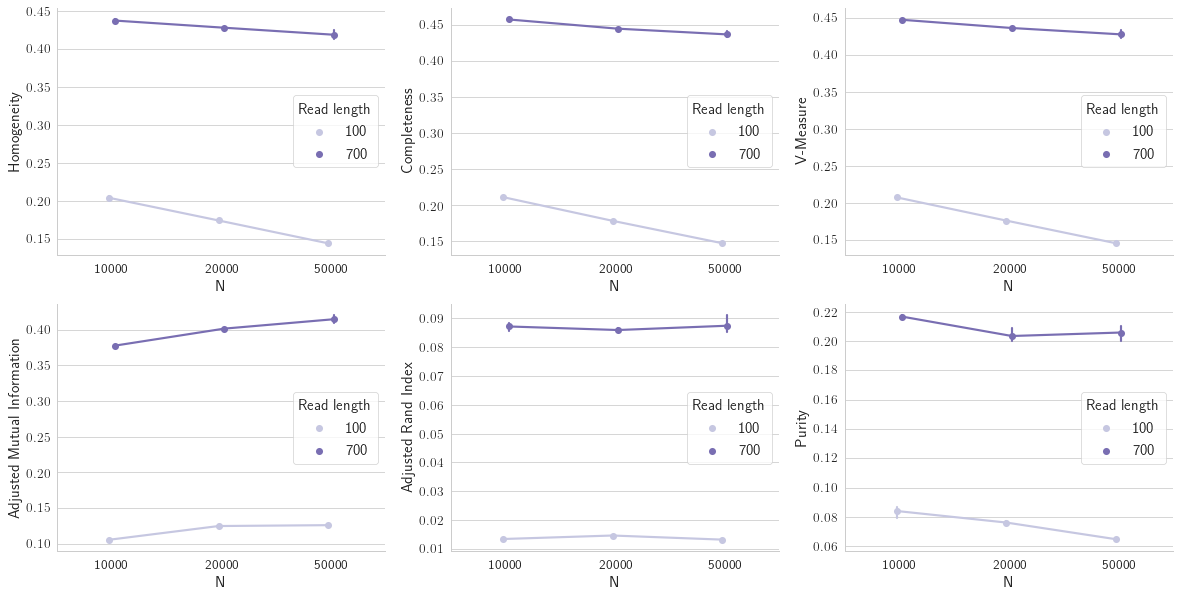

In [ ]:
k = 4
selected_df = qCluster_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_n_simulated_by_read_length-k_5.pdf


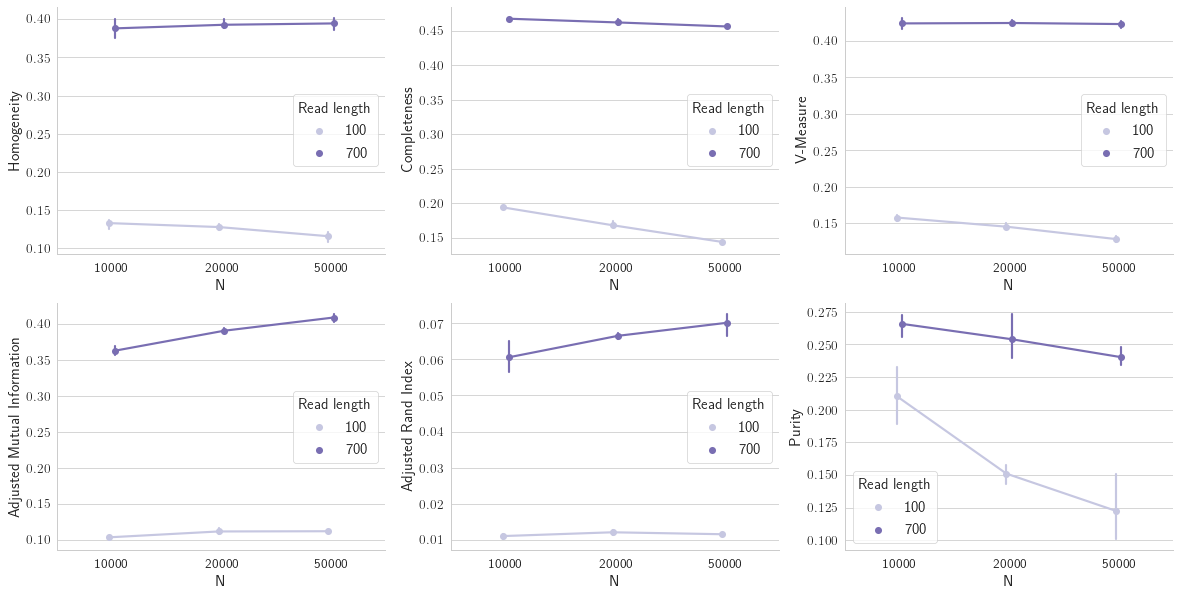

In [ ]:
k = 5
selected_df = qCluster_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_n_simulated_by_read_length-k_6.pdf


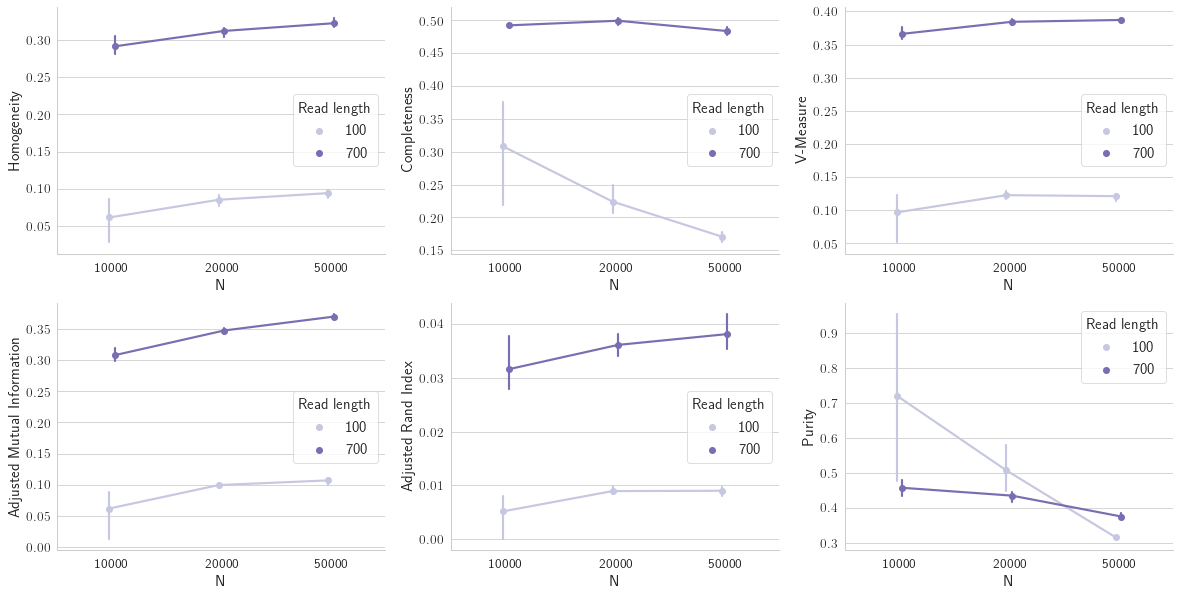

In [ ]:
k = 6
selected_df = qCluster_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_n_simulated_by_read_length-k_7.pdf


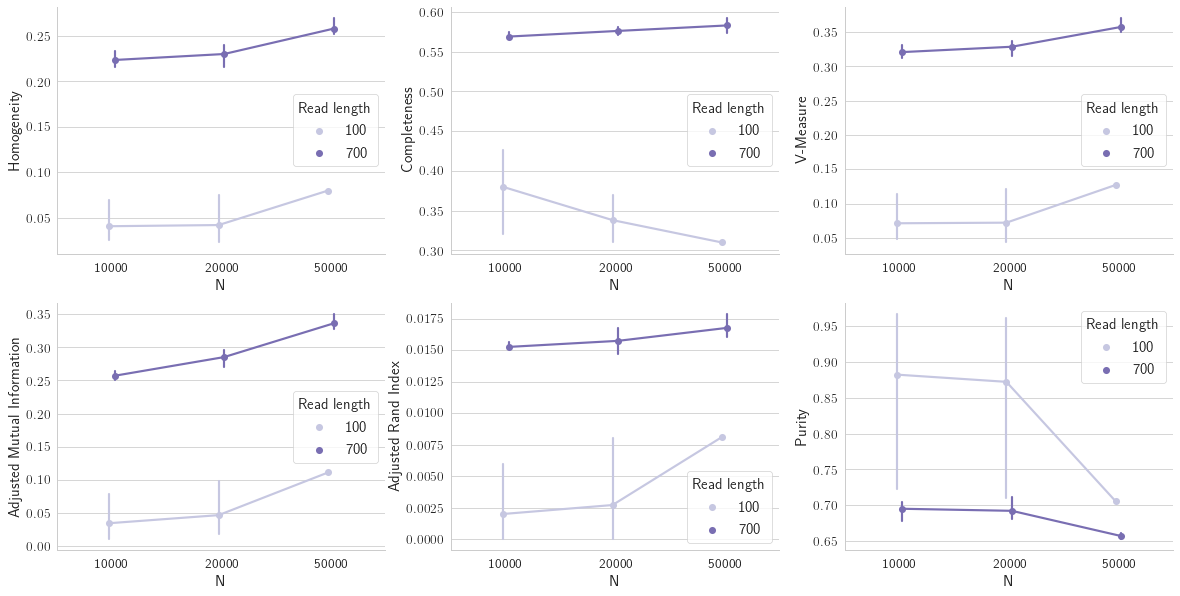

In [ ]:
k = 7
selected_df = qCluster_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_n_simulated_by_read_length-k_8.pdf


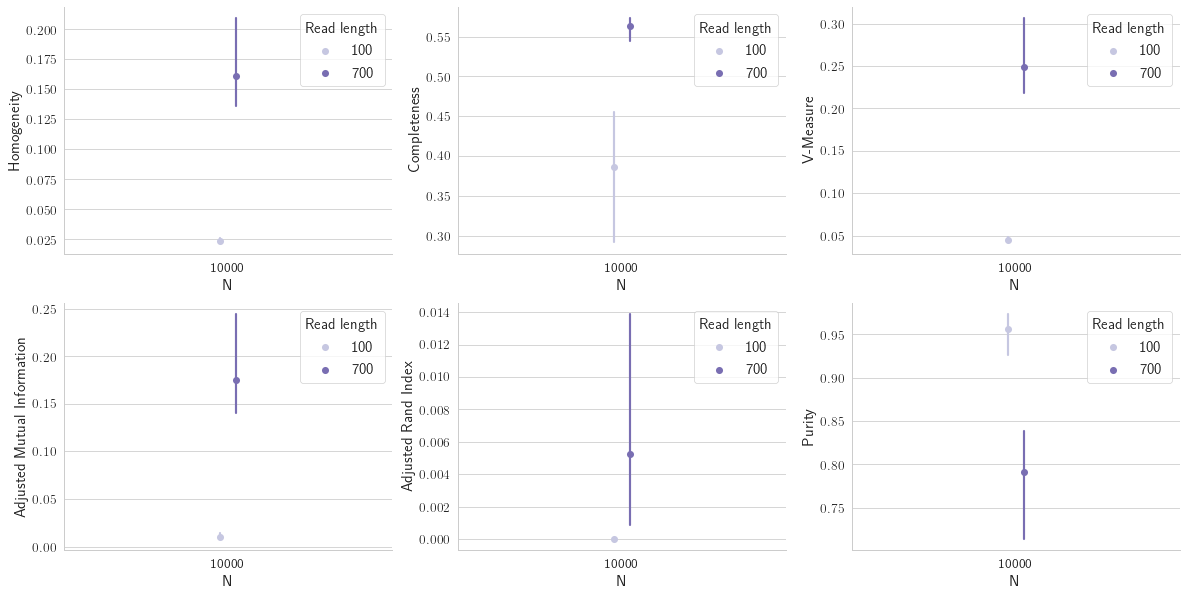

In [ ]:
k = 8
selected_df = qCluster_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

### Fix distance, compare cluster metrics against the number of simulated reads in the dataset, discriminating by length of those reads (100 or 700).

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_n_simulated_by_read_length-d_a.pdf


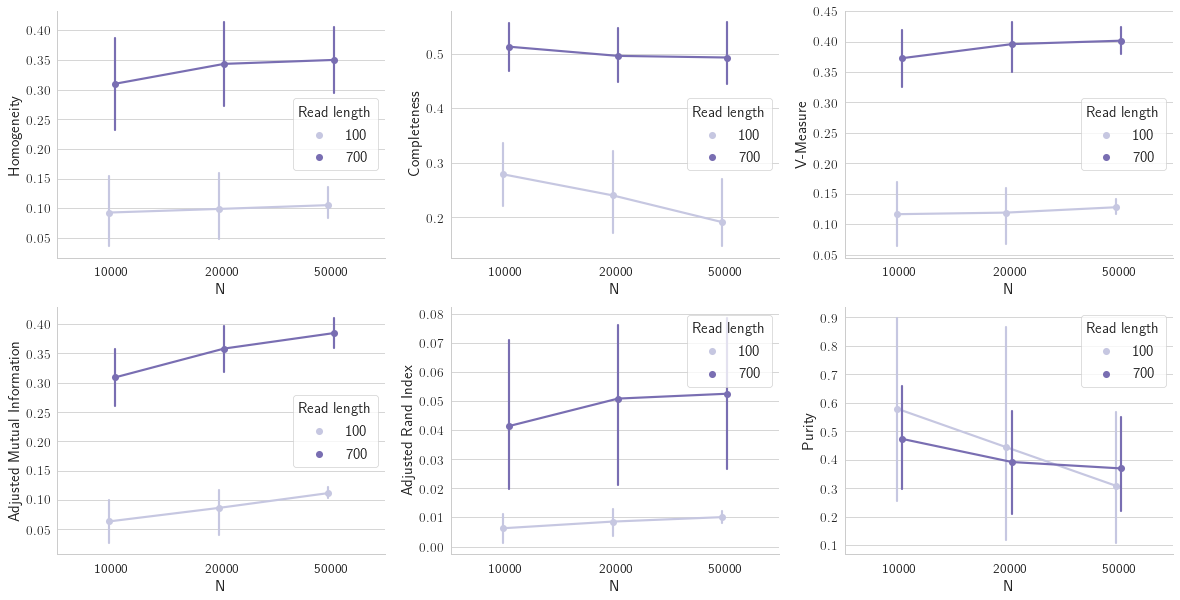

In [ ]:
selected_df = qCluster_csv.query(f'quality_type == "normal" & distance == "{DISTANCE_D2_STAR}"')
plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix='-d_a')

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_n_simulated_by_read_length-d_c.pdf


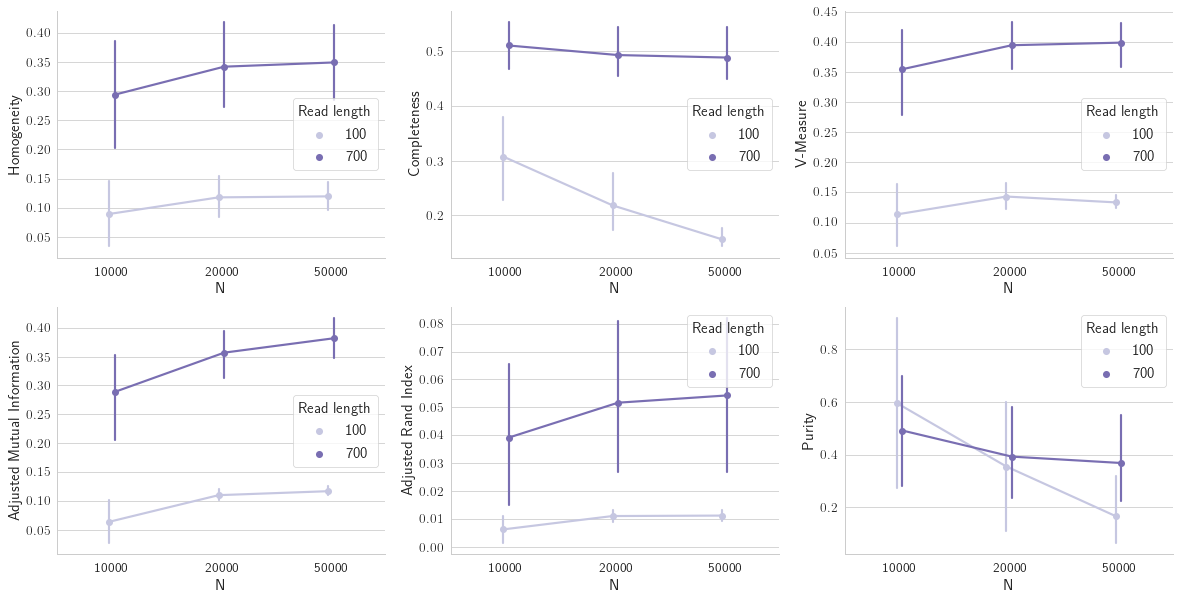

In [ ]:
selected_df = qCluster_csv.query(f'quality_type == "normal" & distance == "{DISTANCE_CHI_SQUARE}"')
plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix='-d_c')

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_n_simulated_by_read_length-d_e.pdf


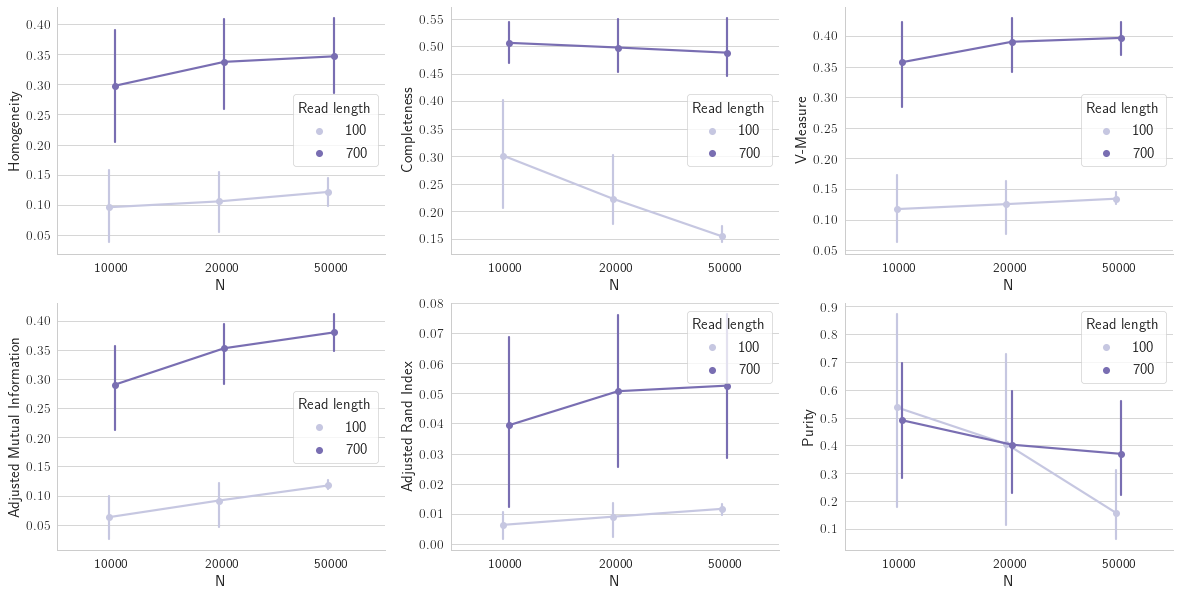

In [ ]:
selected_df = qCluster_csv.query(f'quality_type == "normal" & distance == "{DISTANCE_EUCLIDEAN}"')
plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix='-d_e')

## Fix number of simulated reads, compare cluster metrics against the read lengths, discriminating by distance metric

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_read_length_by_distance_n-10000.pdf


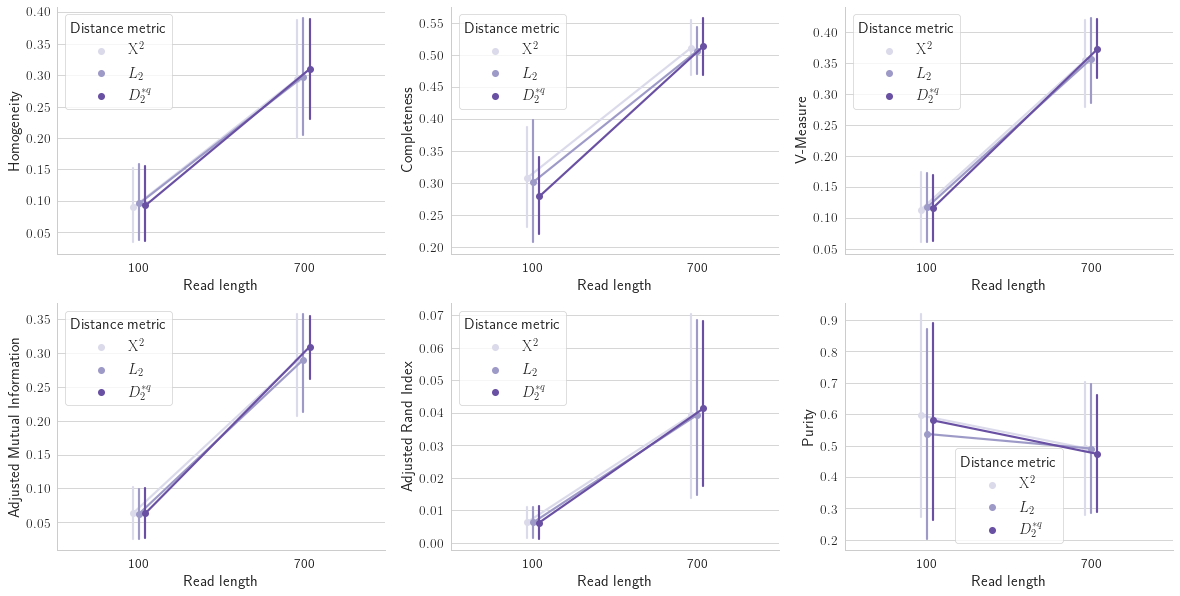

In [ ]:
n_simulated = 10000
selected_df = qCluster_csv \
  .sort_values(by=['distance'], axis=0, ascending=False) \
  .query(f'quality_type == "normal" & n_simulated == {n_simulated}')

plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='read_length', xlabel='Read length',
                              hue='distance', huelabel='Distance metric', postfix=f'_n-{n_simulated}')

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_read_length_by_distance_n-20000.pdf


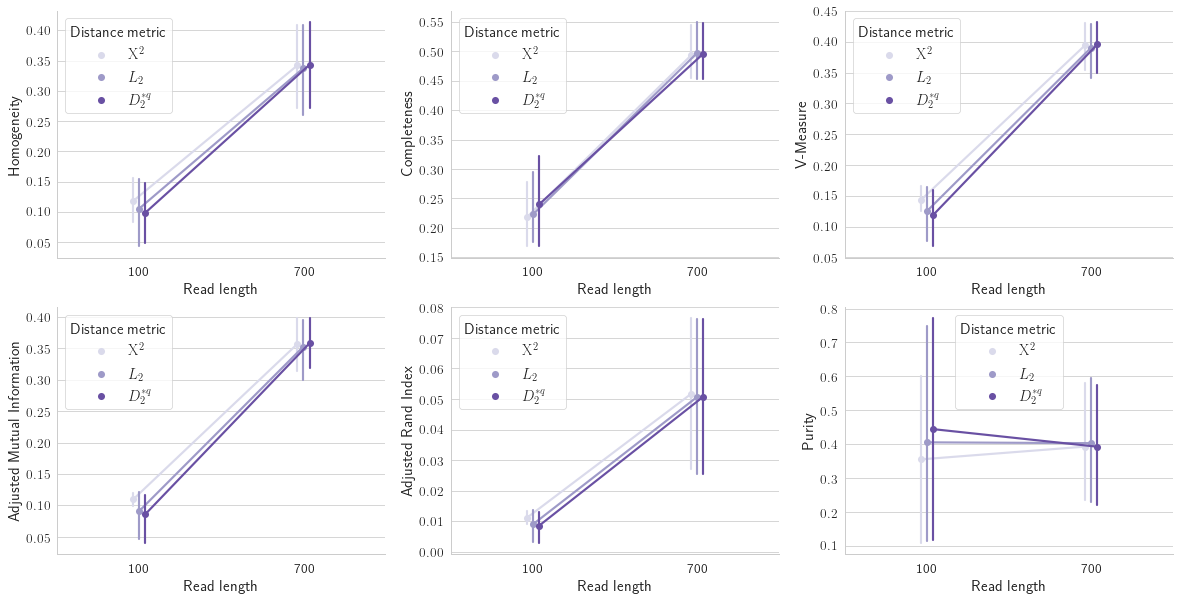

In [ ]:
n_simulated = 20000
selected_df = qCluster_csv \
  .sort_values(by=['distance'], axis=0, ascending=False) \
  .query(f'quality_type == "normal" & n_simulated == {n_simulated}')

plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='read_length', xlabel='Read length',
                              hue='distance', huelabel='Distance metric', postfix=f'_n-{n_simulated}')

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_read_length_by_distance_n-50000.pdf


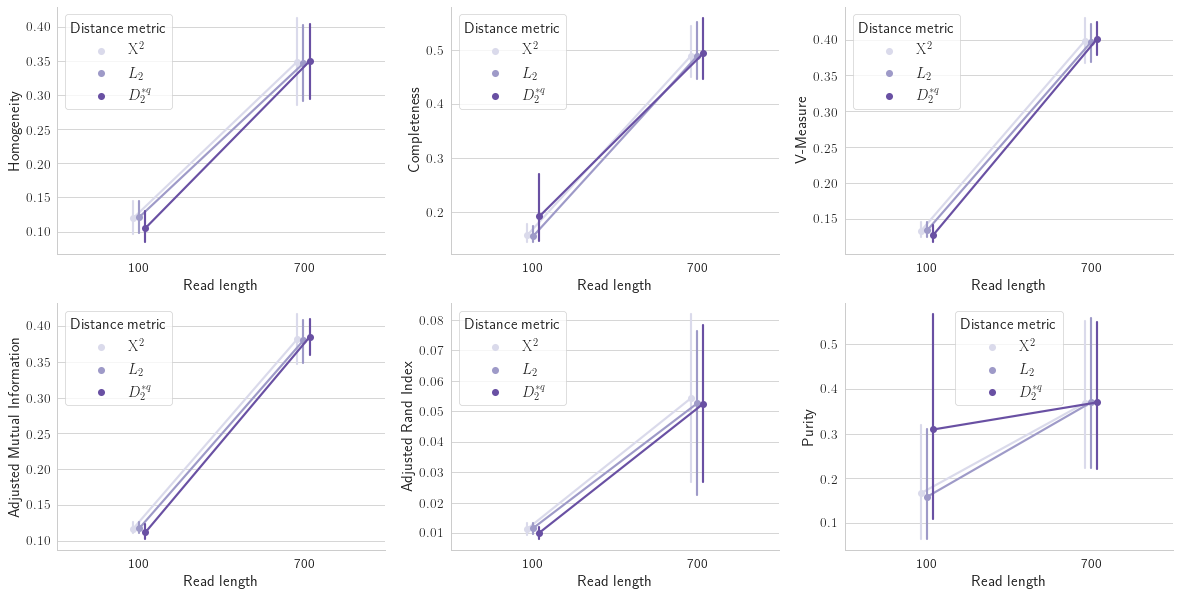

In [ ]:
n_simulated = 50000
selected_df = qCluster_csv \
  .sort_values(by=['distance'], axis=0, ascending=False) \
  .query(f'quality_type == "normal" & n_simulated == {n_simulated}')

plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='read_length', xlabel='Read length',
                              hue='distance', huelabel='Distance metric', postfix=f'_n-{n_simulated}')

## Fix number of simulated reads and read lengths, compare cluster metrics against k-mer length, discriminating by distance metric

Read length: 100

In [ ]:
read_length = 100

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_kmer_length_by_distance_n-10000_fl-100.pdf


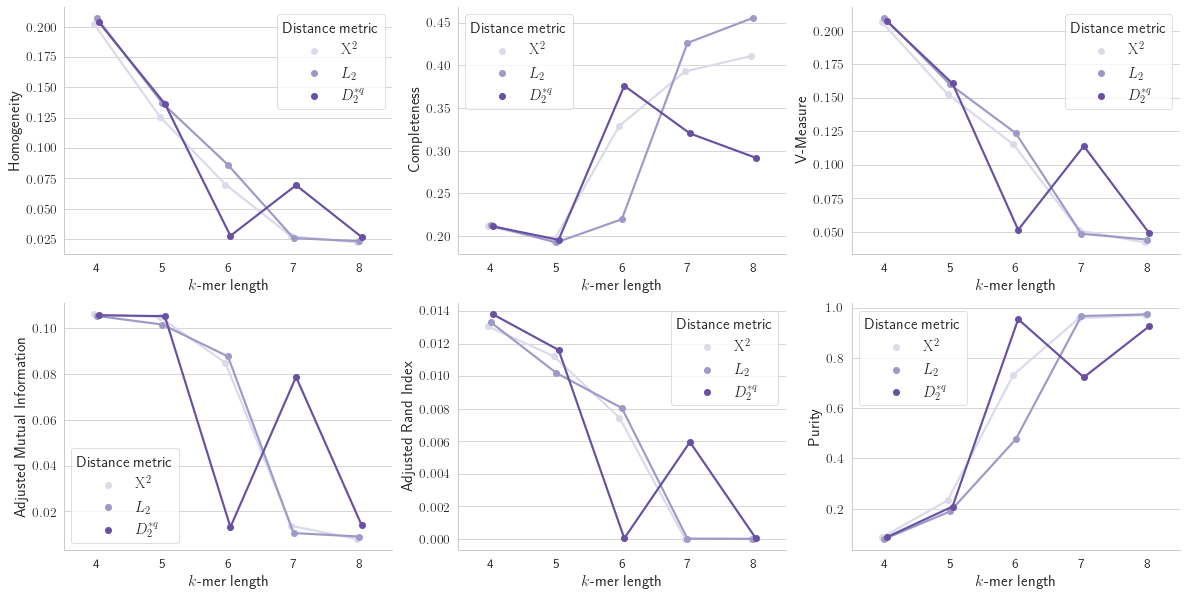

In [ ]:
n_simulated = 10000
selected_df = qCluster_csv \
  .sort_values(by=['distance'], axis=0, ascending=False) \
  .query(f'quality_type == "normal" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='distance', huelabel='Distance metric', postfix=f'_n-{n_simulated}_fl-{read_length}')

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_kmer_length_by_distance_n-20000_fl-100.pdf


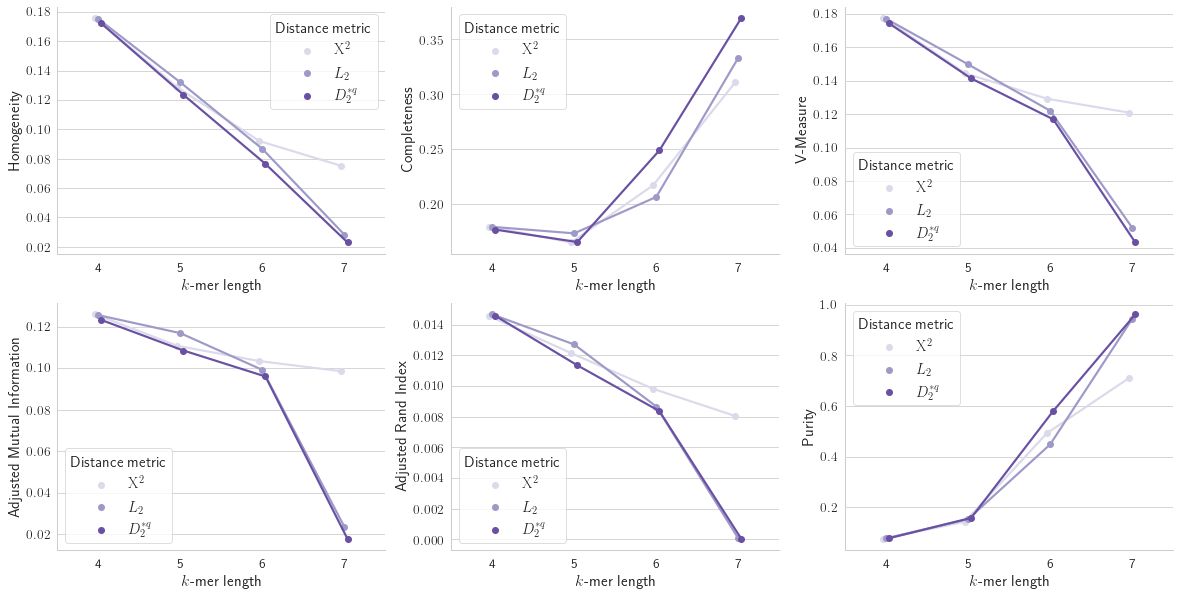

In [ ]:
n_simulated = 20000
selected_df = qCluster_csv \
  .sort_values(by=['distance'], axis=0, ascending=False) \
  .query(f'quality_type == "normal" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='distance', huelabel='Distance metric', postfix=f'_n-{n_simulated}_fl-{read_length}')

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_kmer_length_by_distance_n-50000_fl-100.pdf


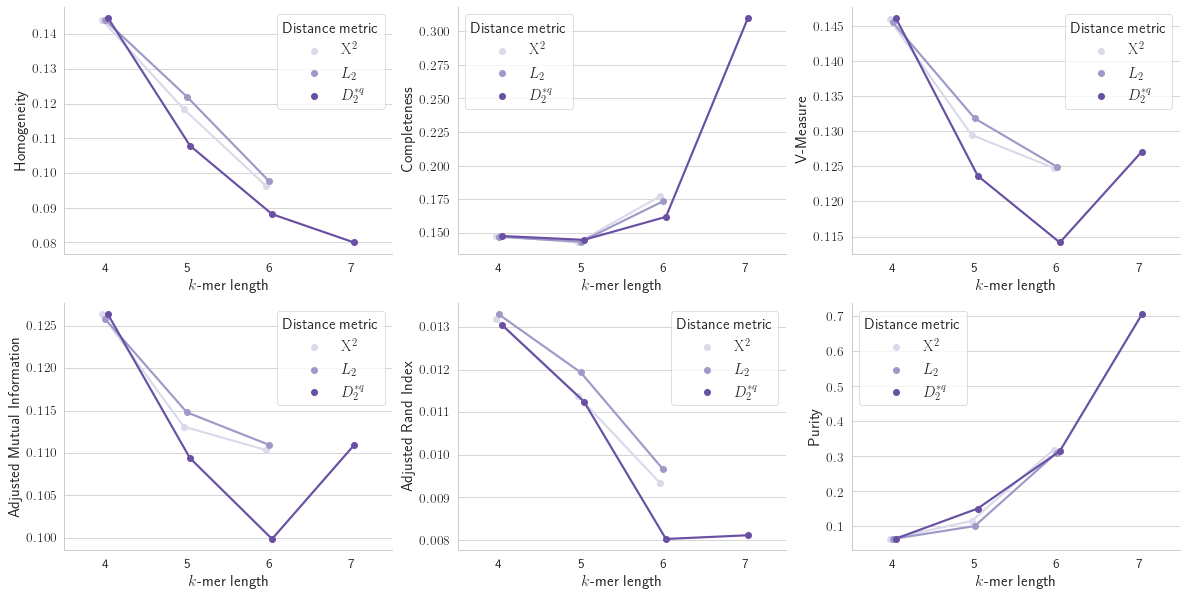

In [ ]:
n_simulated = 50000
selected_df = qCluster_csv \
  .sort_values(by=['distance'], axis=0, ascending=False) \
  .query(f'quality_type == "normal" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='distance', huelabel='Distance metric', postfix=f'_n-{n_simulated}_fl-{read_length}')

Read length: 700

In [ ]:
read_length = 700

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_kmer_length_by_distance_n-10000_fl-700.pdf


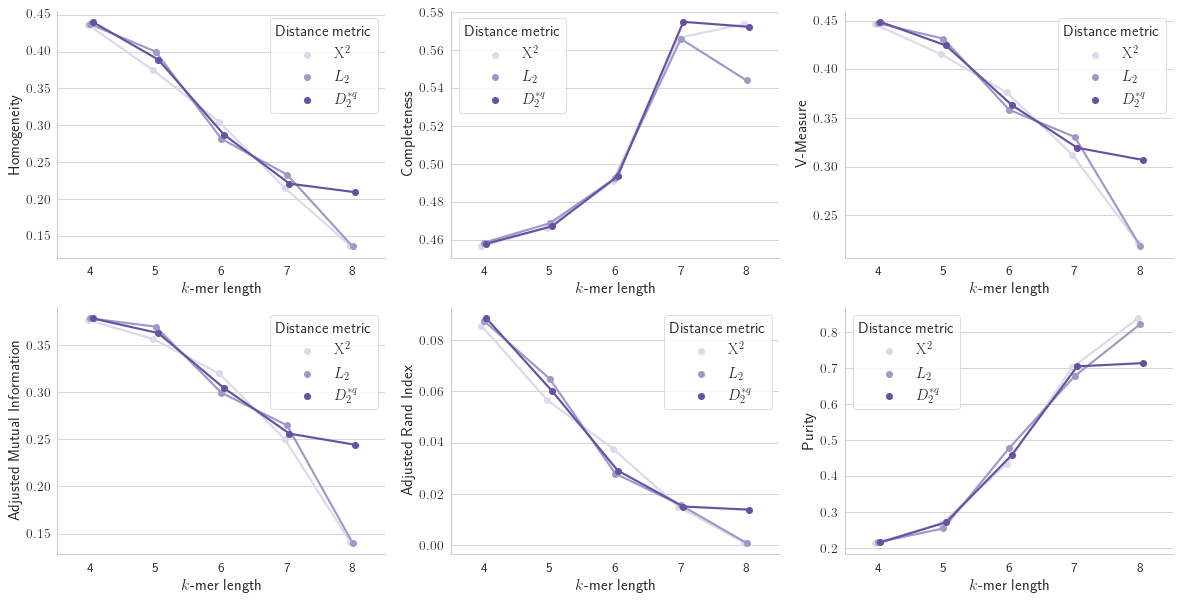

In [ ]:
n_simulated = 10000
selected_df = qCluster_csv \
  .sort_values(by=['distance'], axis=0, ascending=False) \
  .query(f'quality_type == "normal" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='distance', huelabel='Distance metric', postfix=f'_n-{n_simulated}_fl-{read_length}')

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_kmer_length_by_distance_n-20000_fl-700.pdf


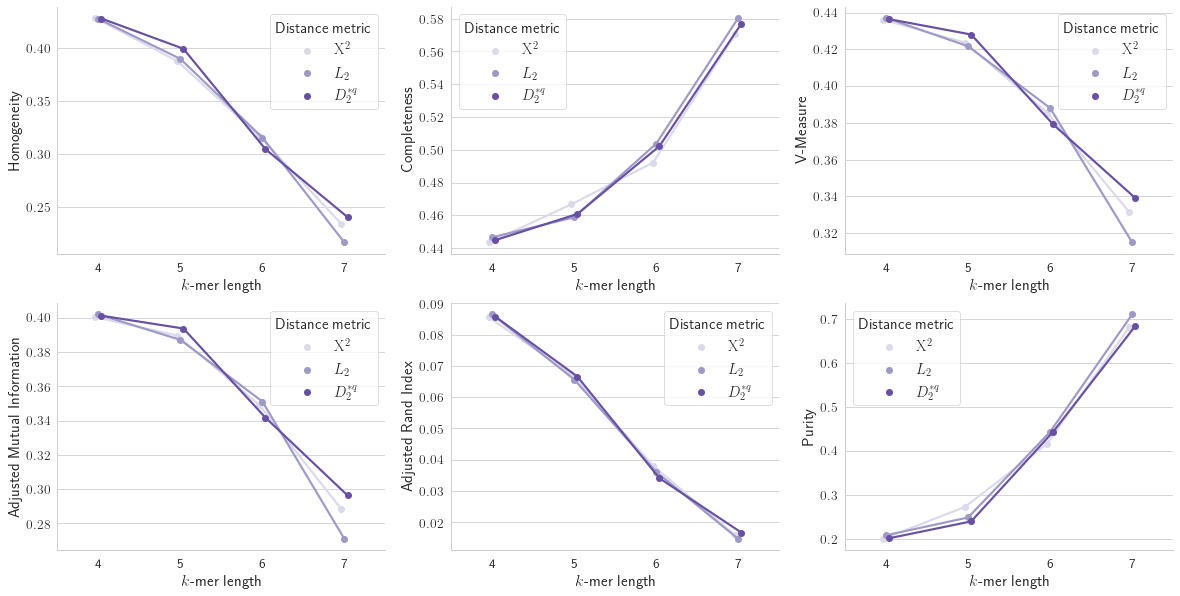

In [ ]:
n_simulated = 20000
selected_df = qCluster_csv \
  .sort_values(by=['distance'], axis=0, ascending=False) \
  .query(f'quality_type == "normal" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='distance', huelabel='Distance metric', postfix=f'_n-{n_simulated}_fl-{read_length}')

/content/drive/MyDrive/bioalgo/plots/qCluster-metrics_vs_kmer_length_by_distance_n-50000_fl-700.pdf


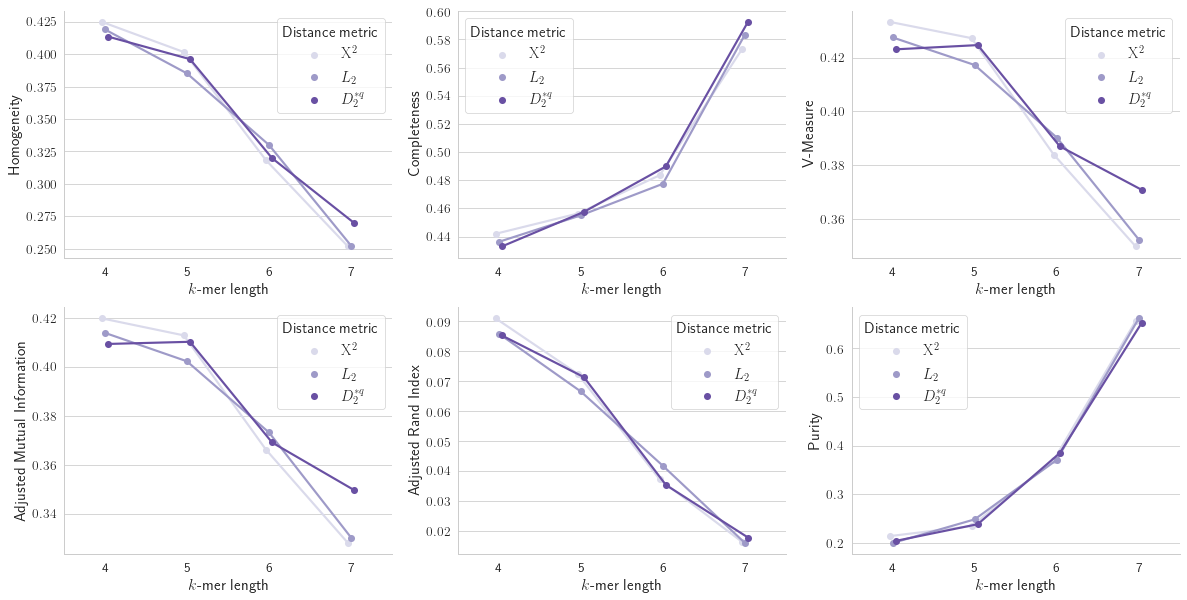

In [ ]:
n_simulated = 50000
selected_df = qCluster_csv \
  .sort_values(by=['distance'], axis=0, ascending=False) \
  .query(f'quality_type == "normal" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='qCluster', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='distance', huelabel='Distance metric', postfix=f'_n-{n_simulated}_fl-{read_length}')

## isONclust metrics

### Fix quality_type to normal, show how the different metrics changed w.r.t. k-mer's length, discriminating by dataset.



In [ ]:
selected_df = isONclust_csv.query('quality_type == "normal"')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_homogeneity-hue_dataset.pgf


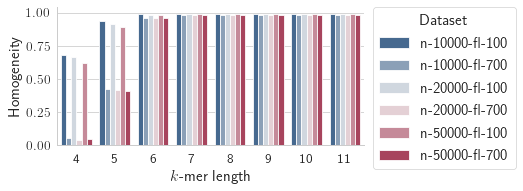

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='homogeneity', ylabel='Homogeneity')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_completeness-hue_dataset.pgf


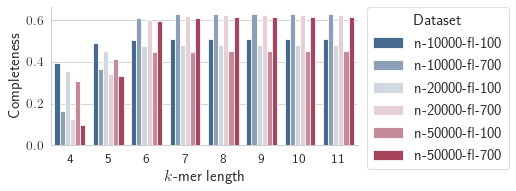

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='completeness', ylabel='Completeness')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_v_measure-hue_dataset.pgf


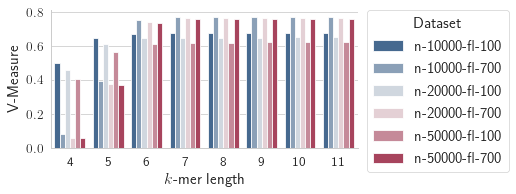

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='v_measure', ylabel='V-Measure')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_adjusted_mutual_information-hue_dataset.pgf


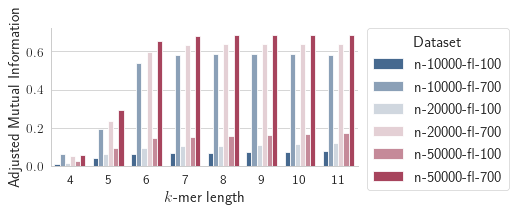

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='adjusted_mutual_information', ylabel='Adjusted Mutual Information')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_adjusted_rand_index-hue_dataset.pgf


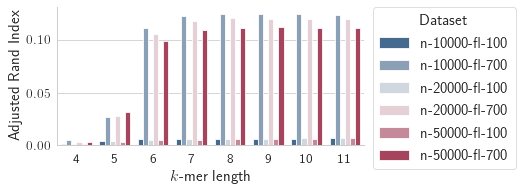

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='adjusted_rand_index', ylabel='Adjusted Rand Index')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_purity-hue_dataset.pgf


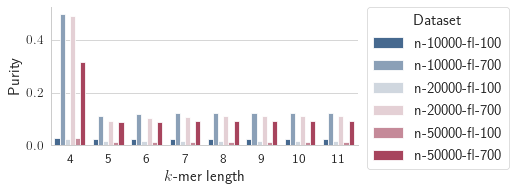

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='purity', ylabel='Purity')

### Fix quality_type to no_trivial, show how the different metrics changed w.r.t. k-mer's length, discriminating by dataset.



In [ ]:
selected_df = isONclust_csv.query('quality_type == "no_trivial"')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_homogeneity-hue_dataset-no_trivial.pgf


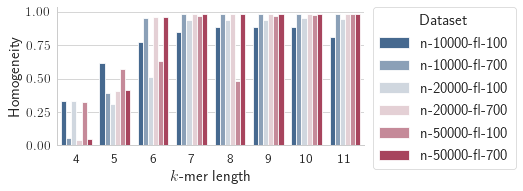

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='homogeneity', ylabel='Homogeneity', postfix='-no_trivial')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_completeness-hue_dataset-no_trivial.pgf


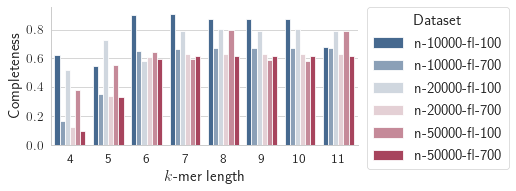

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='completeness', ylabel='Completeness', postfix='-no_trivial')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_v_measure-hue_dataset-no_trivial.pgf


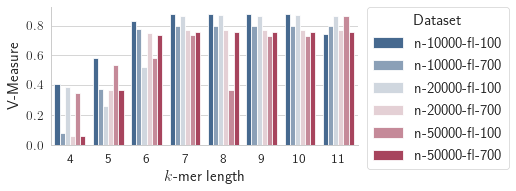

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='v_measure', ylabel='V-Measure', postfix='-no_trivial')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_adjusted_mutual_information-hue_dataset-no_trivial.pgf


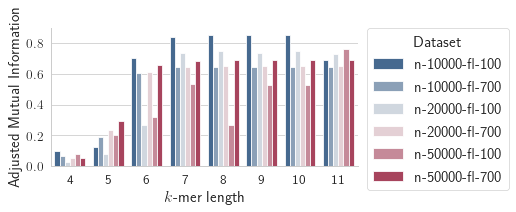

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='adjusted_mutual_information', ylabel='Adjusted Mutual Information', postfix='-no_trivial')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_adjusted_rand_index-hue_dataset-no_trivial.pgf


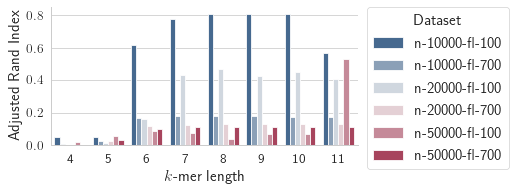

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='adjusted_rand_index', ylabel='Adjusted Rand Index', postfix='-no_trivial')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_purity-hue_dataset-no_trivial.pgf


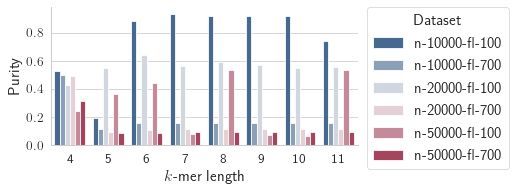

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='purity', ylabel='Purity', postfix='-no_trivial')

### Fix quality_type to no_singleton, show how the different metrics changed w.r.t. k-mer's length, discriminating by dataset.



In [ ]:
selected_df = isONclust_csv.query('quality_type == "no_singleton"')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_homogeneity-hue_dataset-no_singleton.pgf


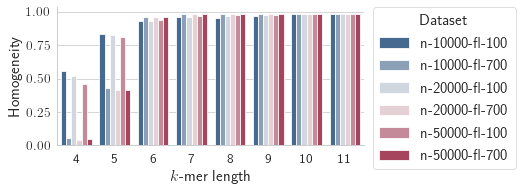

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='homogeneity', ylabel='Homogeneity', postfix='-no_singleton')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_completeness-hue_dataset-no_singleton.pgf


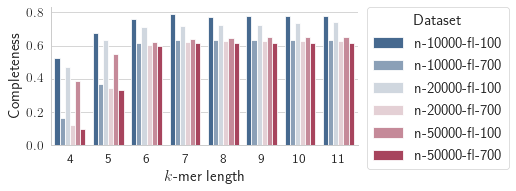

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='completeness', ylabel='Completeness', postfix='-no_singleton')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_v_measure-hue_dataset-no_singleton.pgf


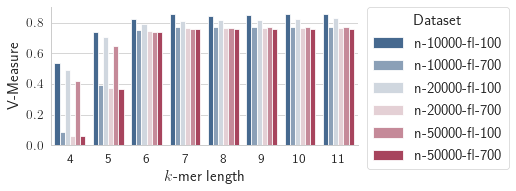

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='v_measure', ylabel='V-Measure', postfix='-no_singleton')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_adjusted_mutual_information-hue_dataset-no_singleton.pgf


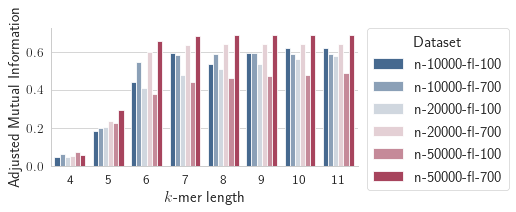

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='adjusted_mutual_information', ylabel='Adjusted Mutual Information', postfix='-no_singleton')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_adjusted_rand_index-hue_dataset-no_singleton.pgf


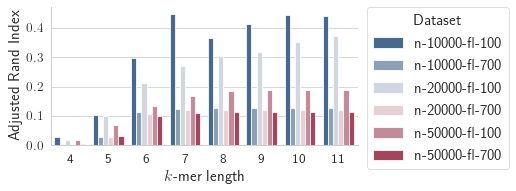

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='adjusted_rand_index', ylabel='Adjusted Rand Index', postfix='-no_singleton')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_purity-hue_dataset-no_singleton.pgf


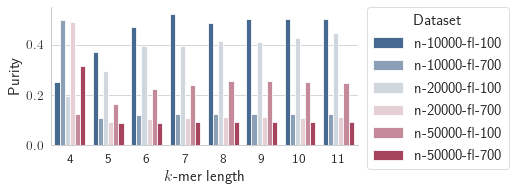

In [ ]:
plot_kmer_vs_metric_by_dataset(tool='isONclust', data=selected_df, y='purity', ylabel='Purity', postfix='-no_singleton')

### Fix kmer length, compare cluster metrics against the number of simulated reads in the dataset, discriminating by length of those reads (100 or 700).

#### k-mer: 4

In [ ]:
k = 4

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_4.pdf


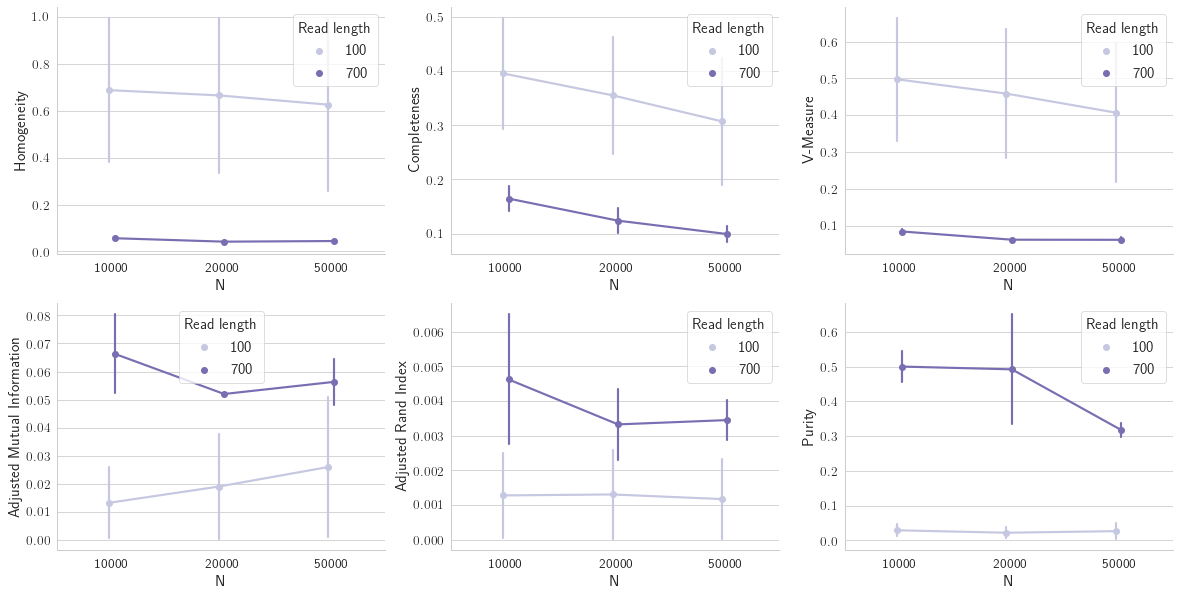

In [ ]:
selected_df = isONclust_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_4-no_singleton.pdf


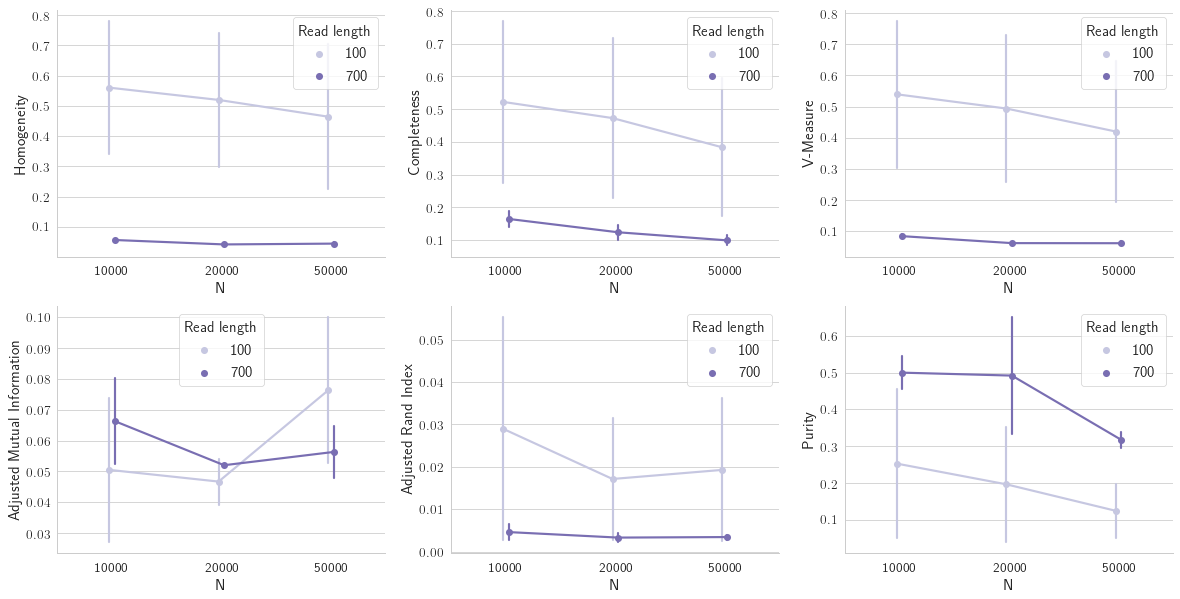

In [ ]:
quality_type = 'no_singleton'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_4-no_trivial.pdf


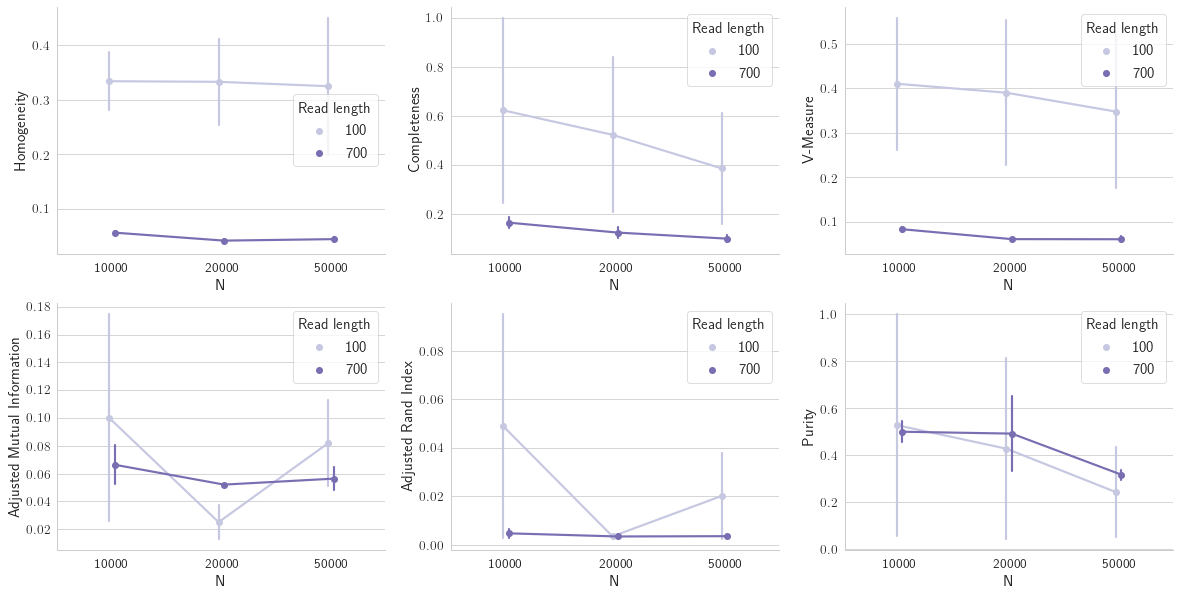

In [ ]:
quality_type = 'no_trivial'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

#### k-mer: 5

In [ ]:
k = 5

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_5.pdf


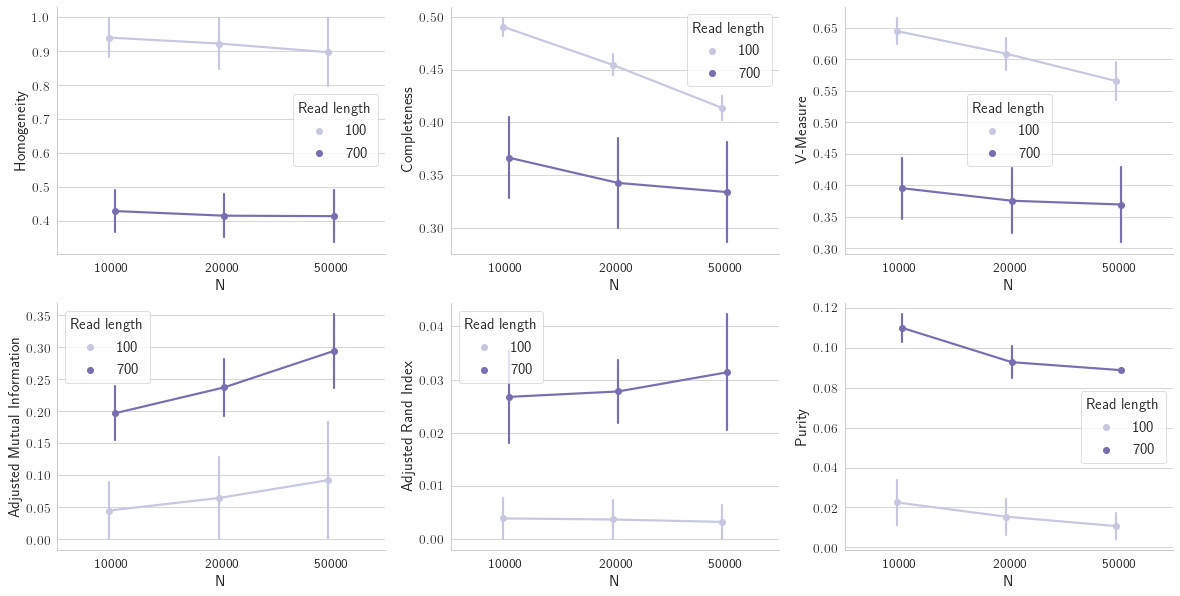

In [ ]:
selected_df = isONclust_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_5-no_singleton.pdf


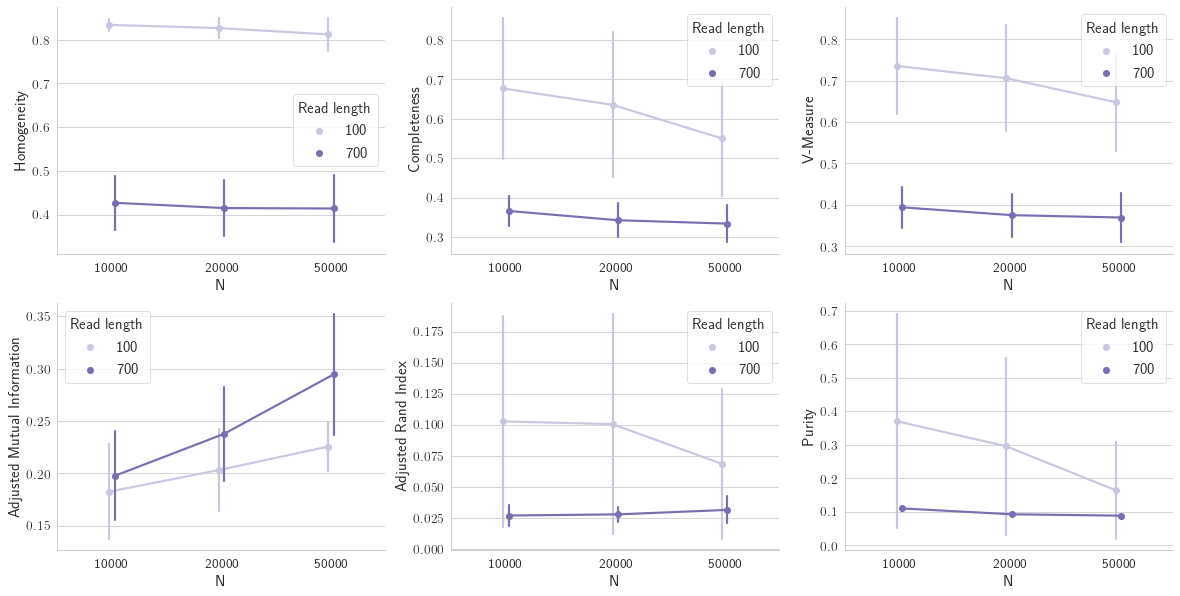

In [ ]:
quality_type = 'no_singleton'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_5-no_trivial.pdf


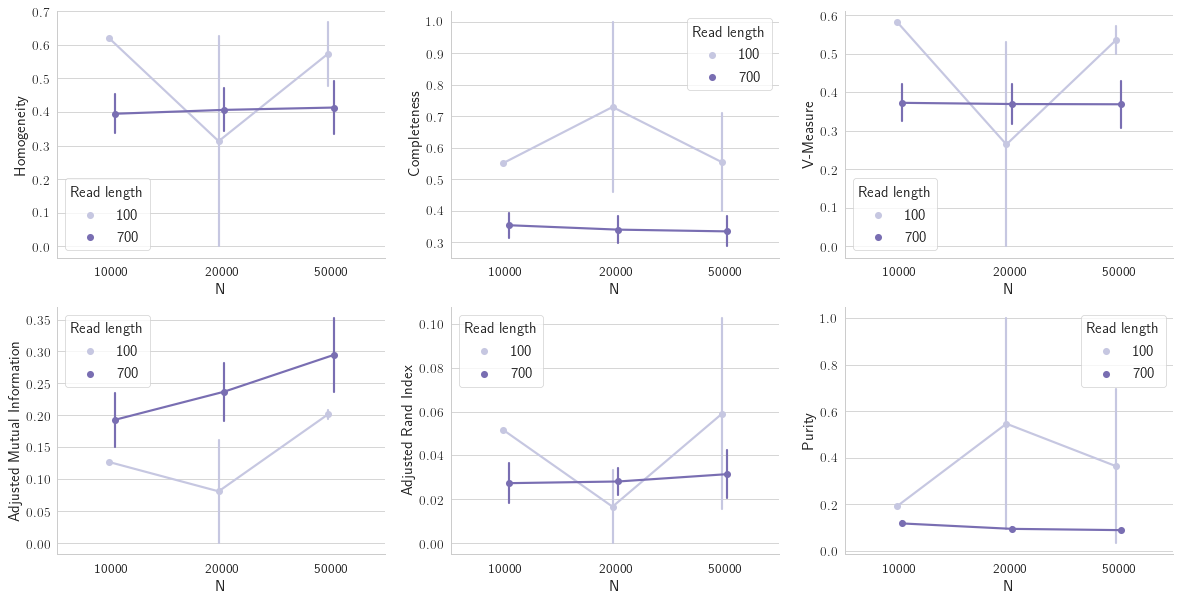

In [ ]:
quality_type = 'no_trivial'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

#### k-mer: 6

In [ ]:
k = 6

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_6.pdf


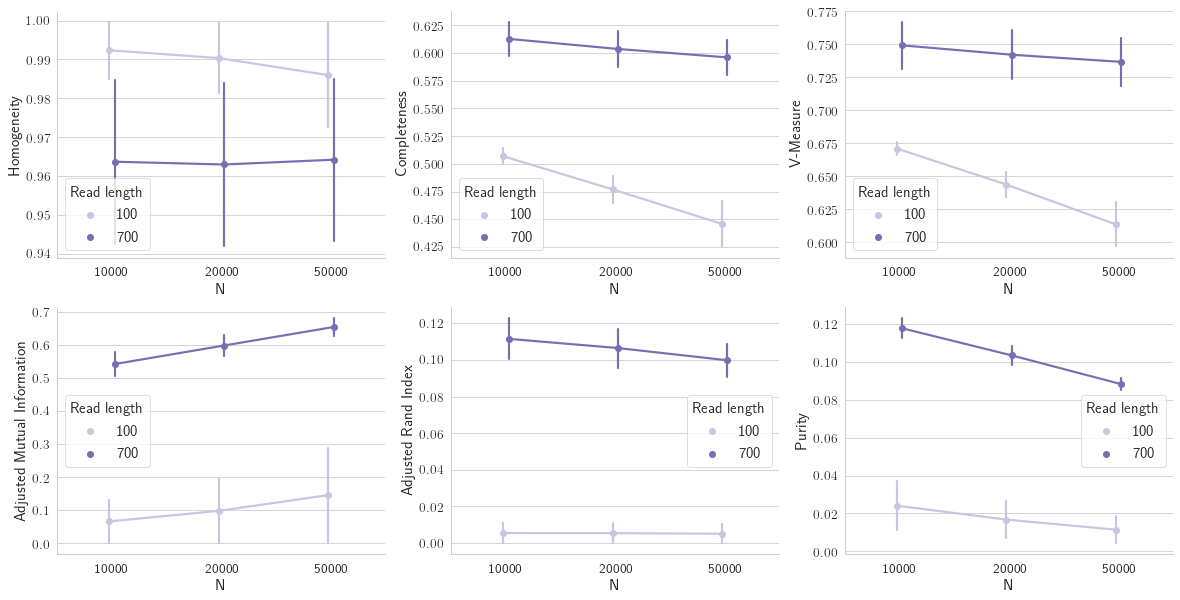

In [ ]:
selected_df = isONclust_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_6-no_singleton.pdf


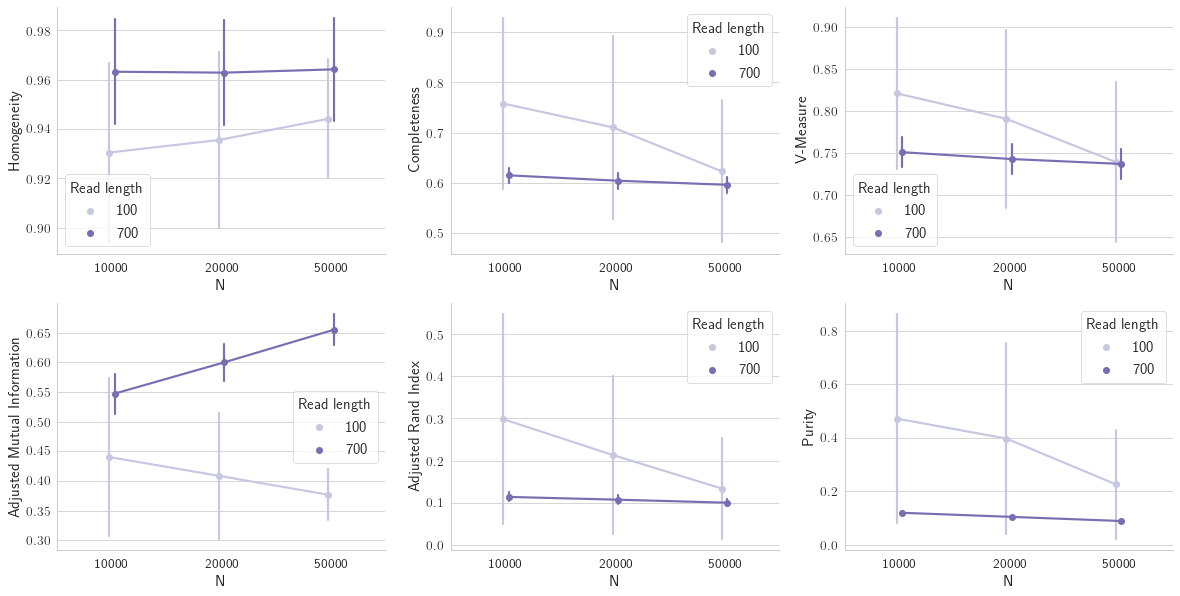

In [ ]:
quality_type = 'no_singleton'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_6-no_trivial.pdf


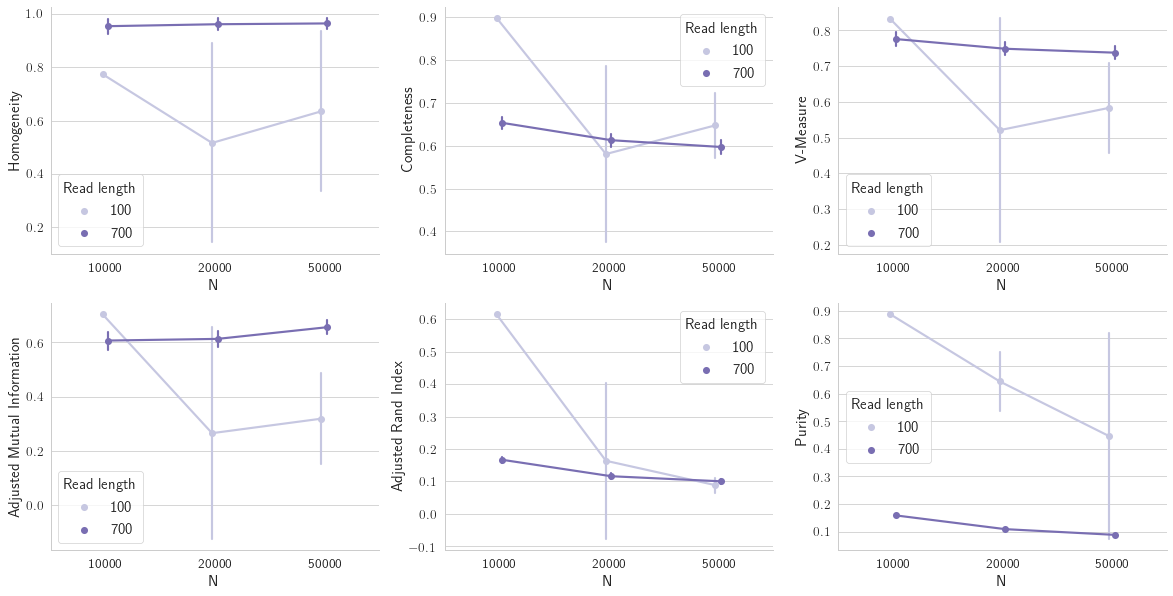

In [ ]:
quality_type = 'no_trivial'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

#### k-mer: 7

In [ ]:
k = 7

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_7.pdf


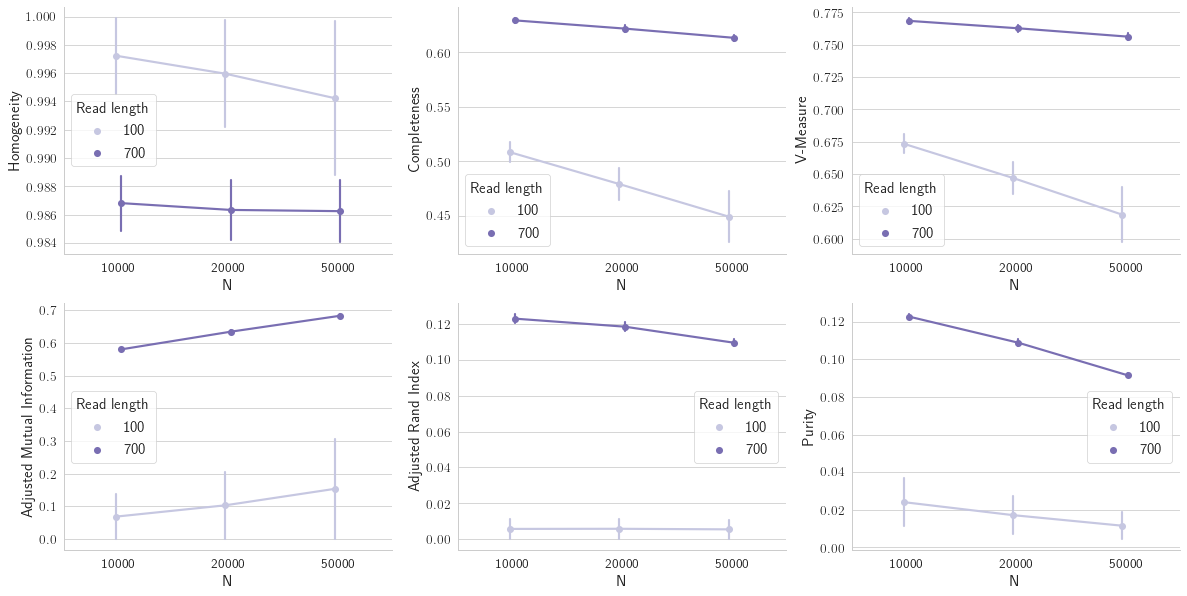

In [ ]:
selected_df = isONclust_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_7-no_singleton.pdf


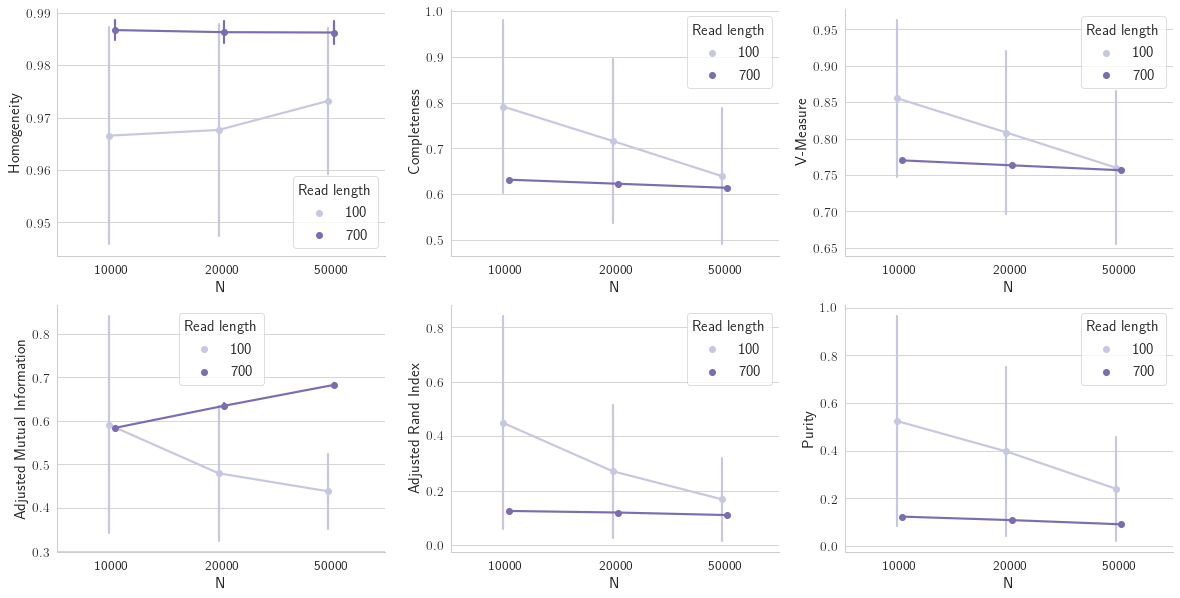

In [ ]:
quality_type = 'no_singleton'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_7-no_trivial.pdf


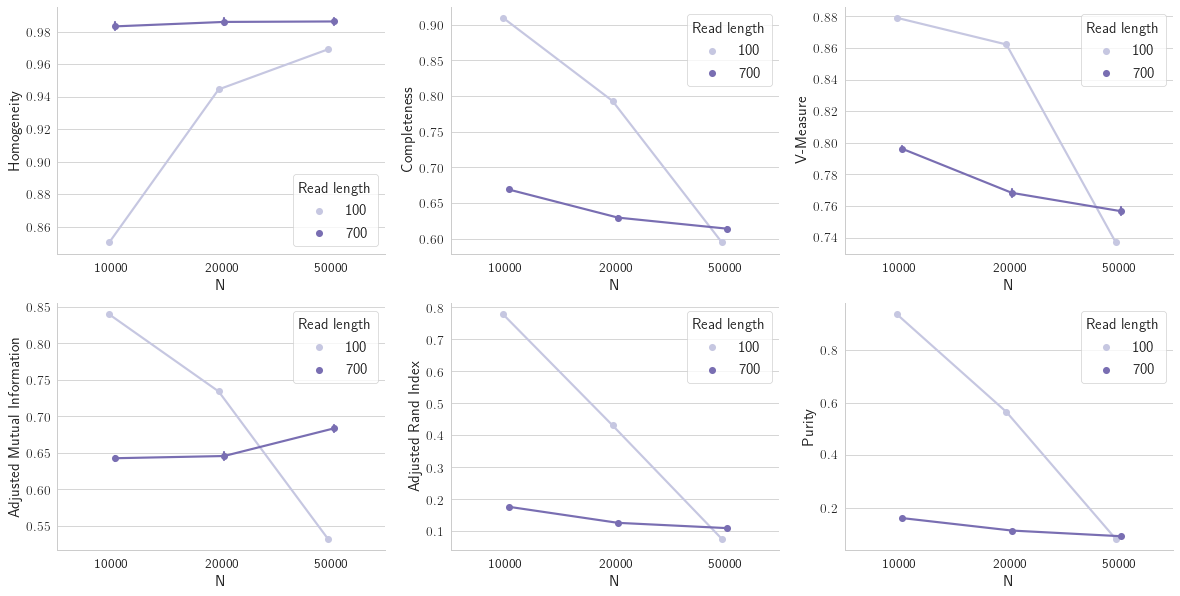

In [ ]:
quality_type = 'no_trivial'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

#### k-mer: 8

In [ ]:
k = 8

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_8.pdf


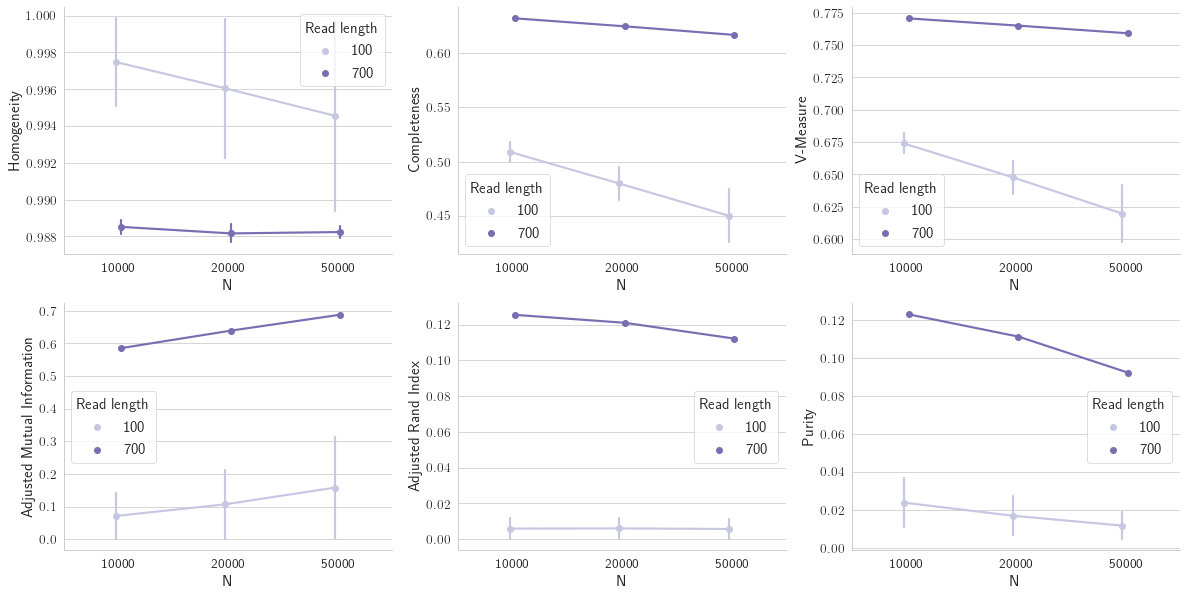

In [ ]:
selected_df = isONclust_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_8-no_singleton.pdf


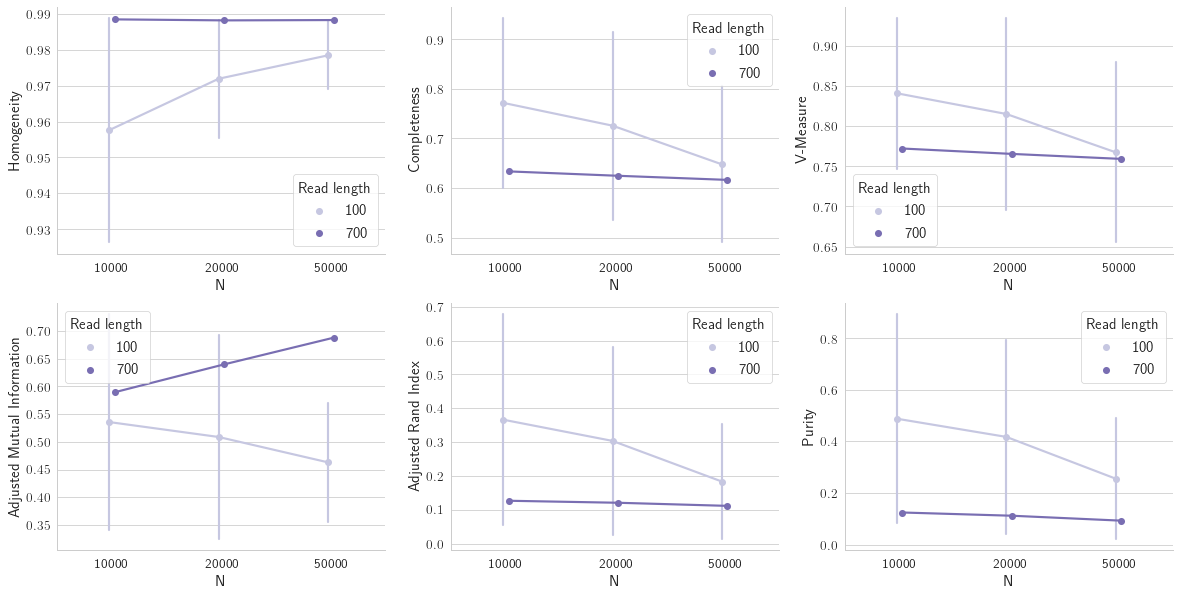

In [ ]:
quality_type = 'no_singleton'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_8-no_trivial.pdf


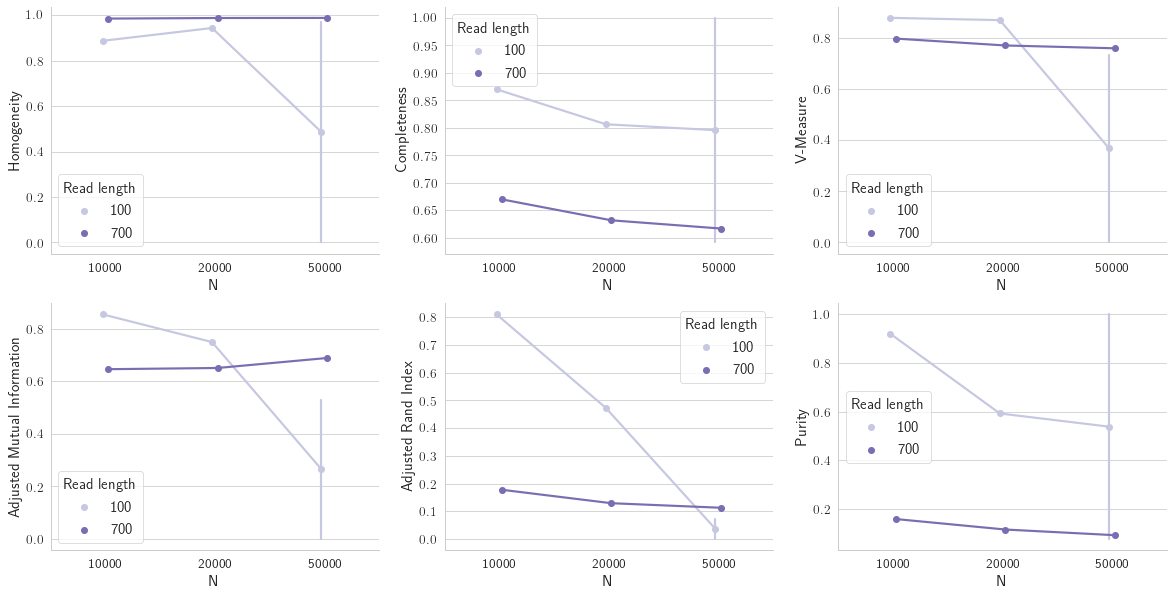

In [ ]:
quality_type = 'no_trivial'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

#### k-mer: 9

In [ ]:
k = 9

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_9.pdf


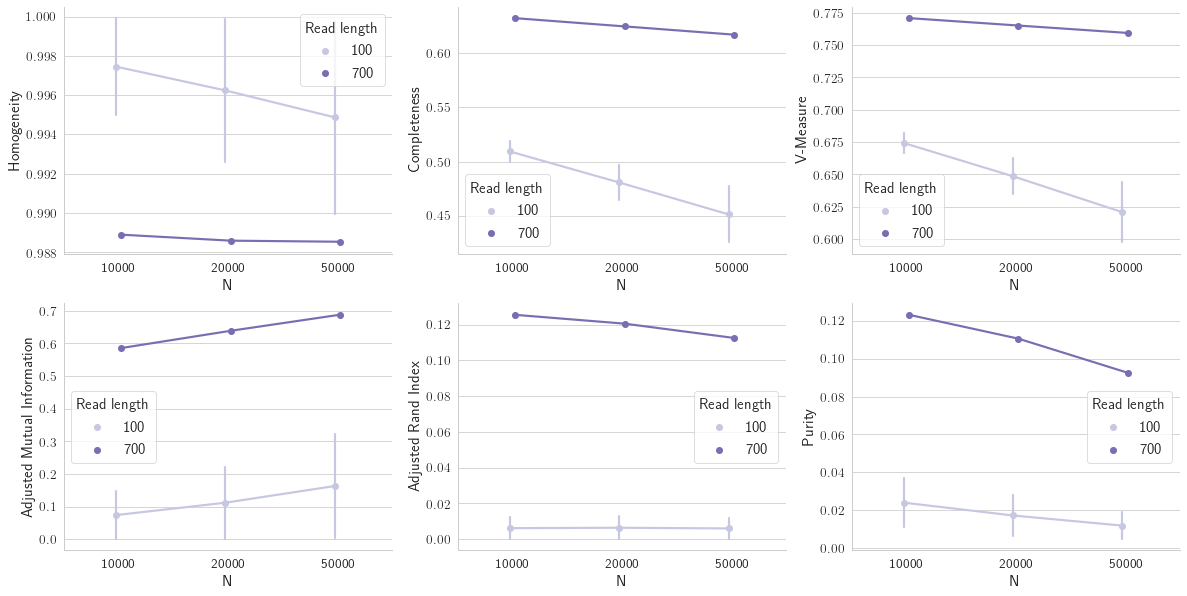

In [ ]:
selected_df = isONclust_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_9-no_singleton.pdf


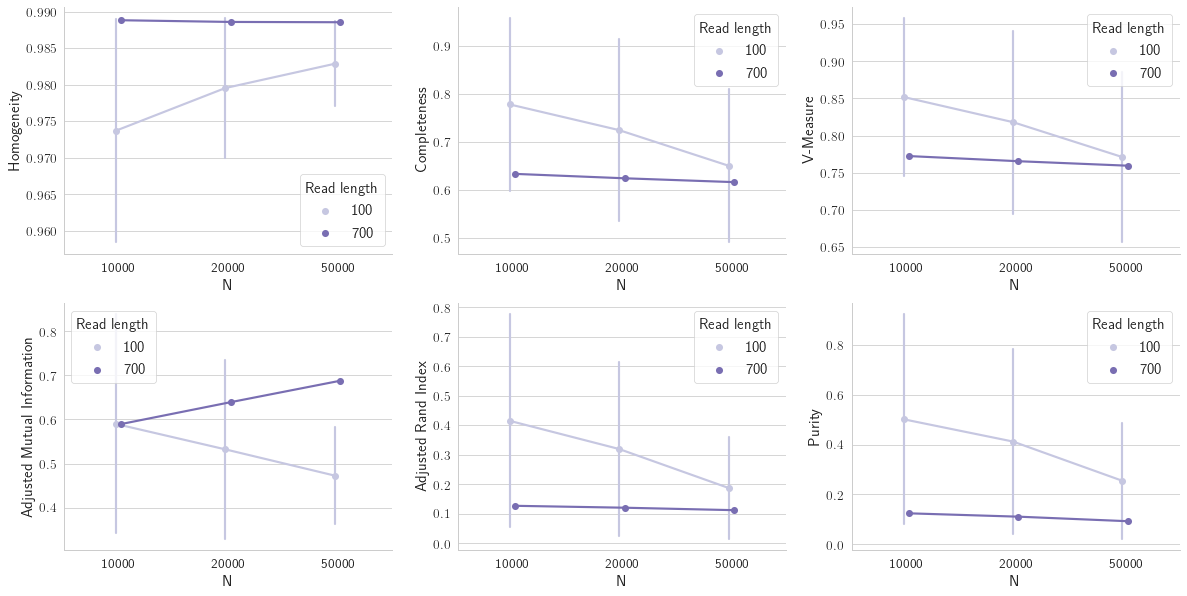

In [ ]:
quality_type = 'no_singleton'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_9-no_trivial.pdf


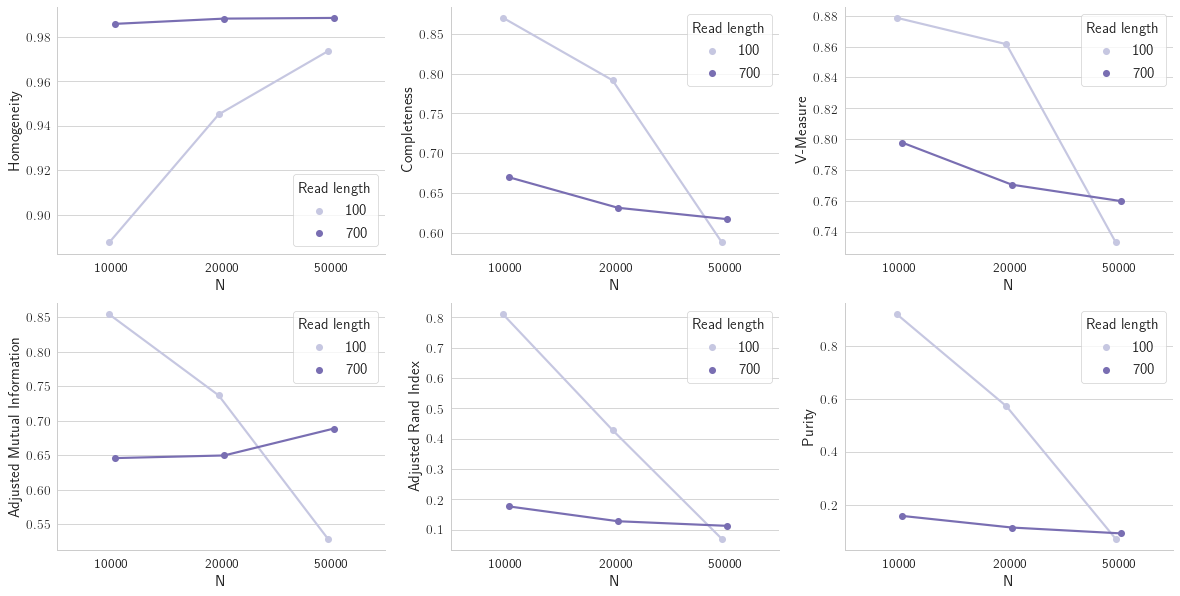

In [ ]:
quality_type = 'no_trivial'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

#### k-mer: 10

In [ ]:
k = 10

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_10.pdf


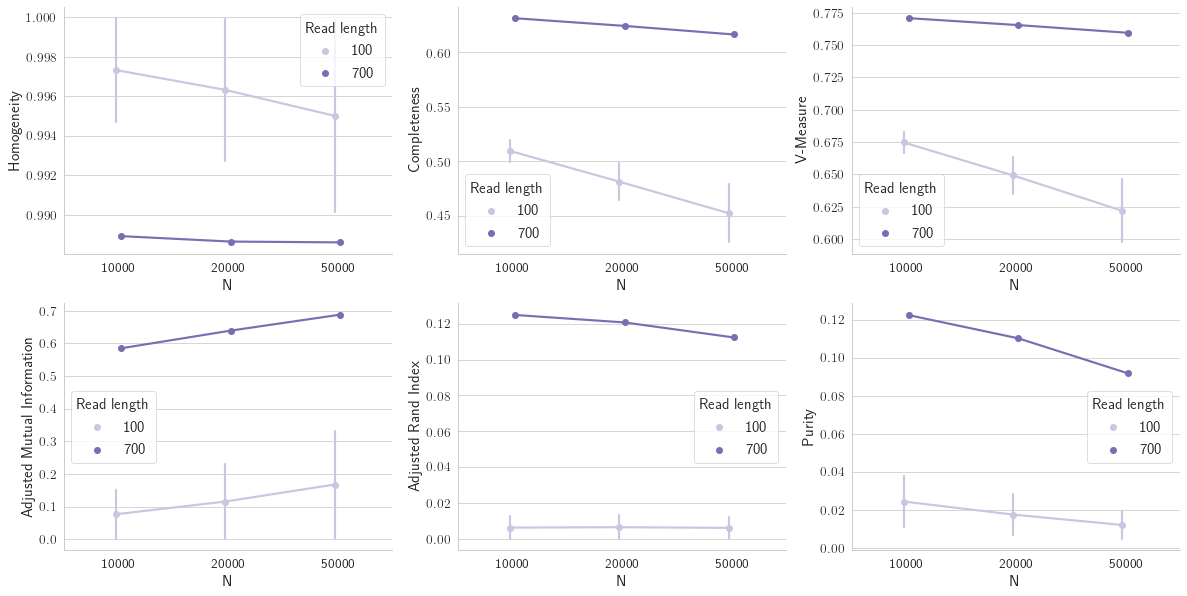

In [ ]:
selected_df = isONclust_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_10-no_singleton.pdf


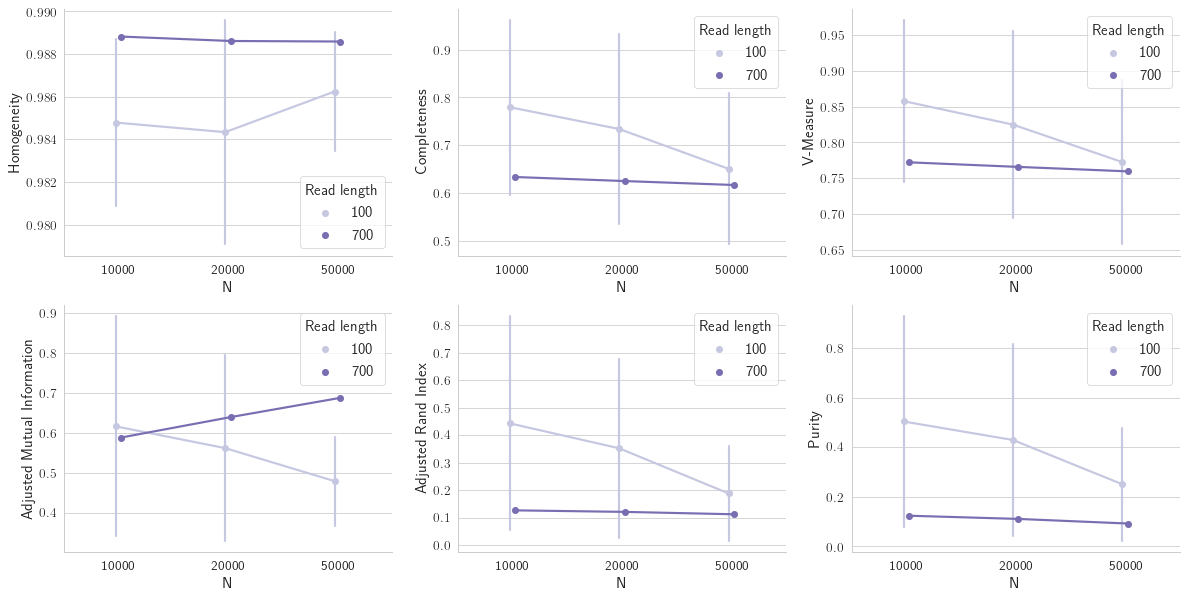

In [ ]:
quality_type = 'no_singleton'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_10-no_trivial.pdf


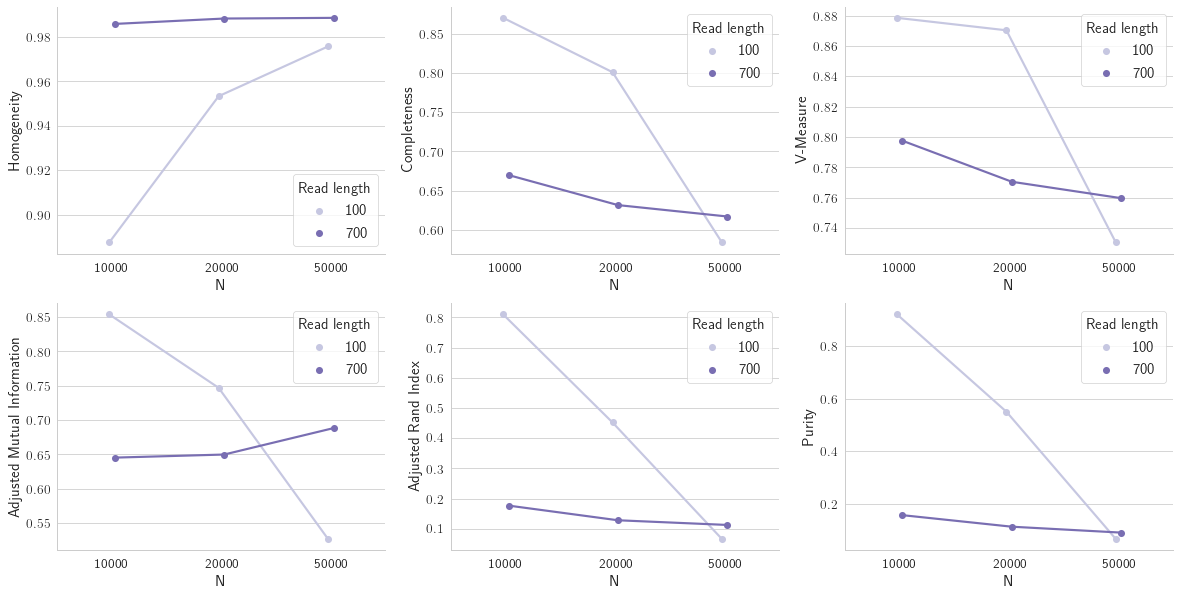

In [ ]:
quality_type = 'no_trivial'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

#### k-mer: 11

In [ ]:
k = 11

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_11.pdf


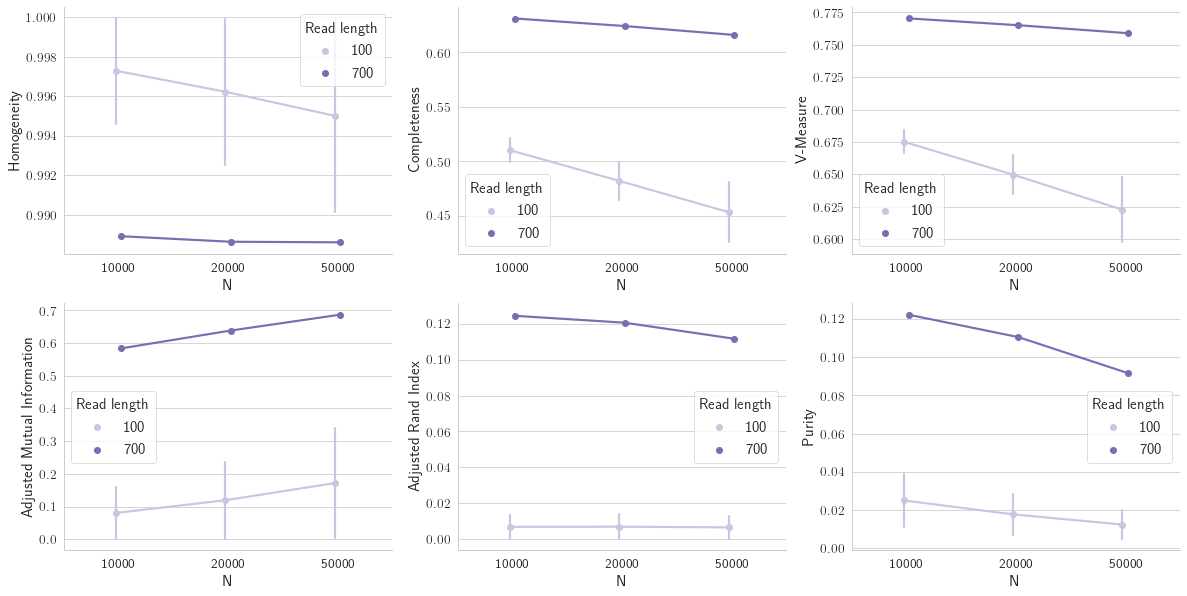

In [ ]:
selected_df = isONclust_csv.query(f'quality_type == "normal" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_11-no_singleton.pdf


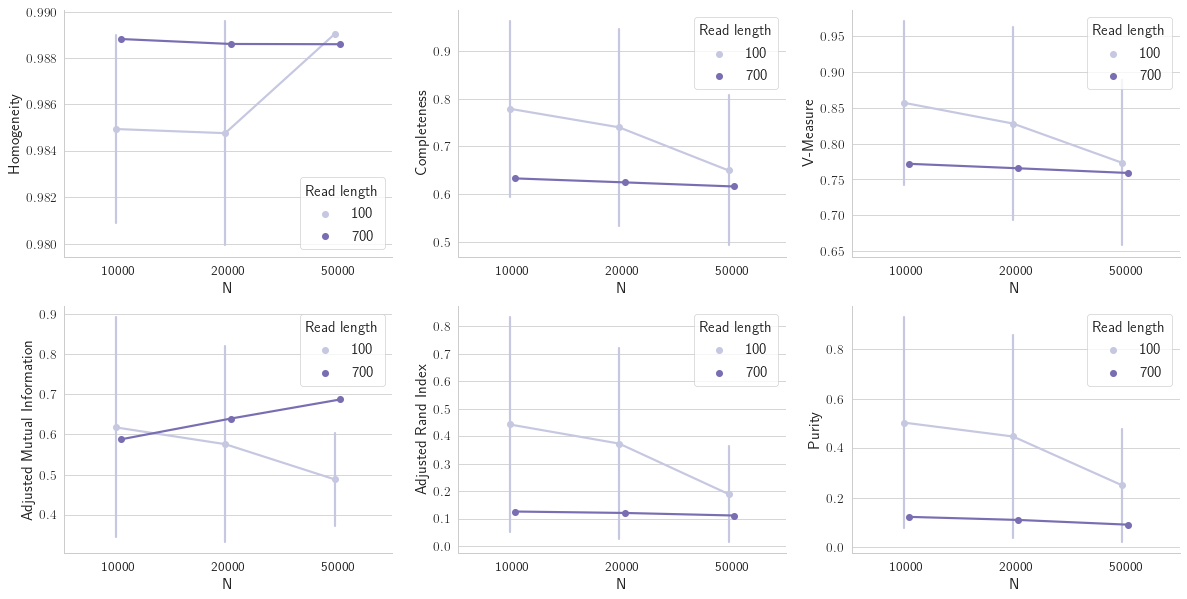

In [ ]:
quality_type = 'no_singleton'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-k_11-no_trivial.pdf


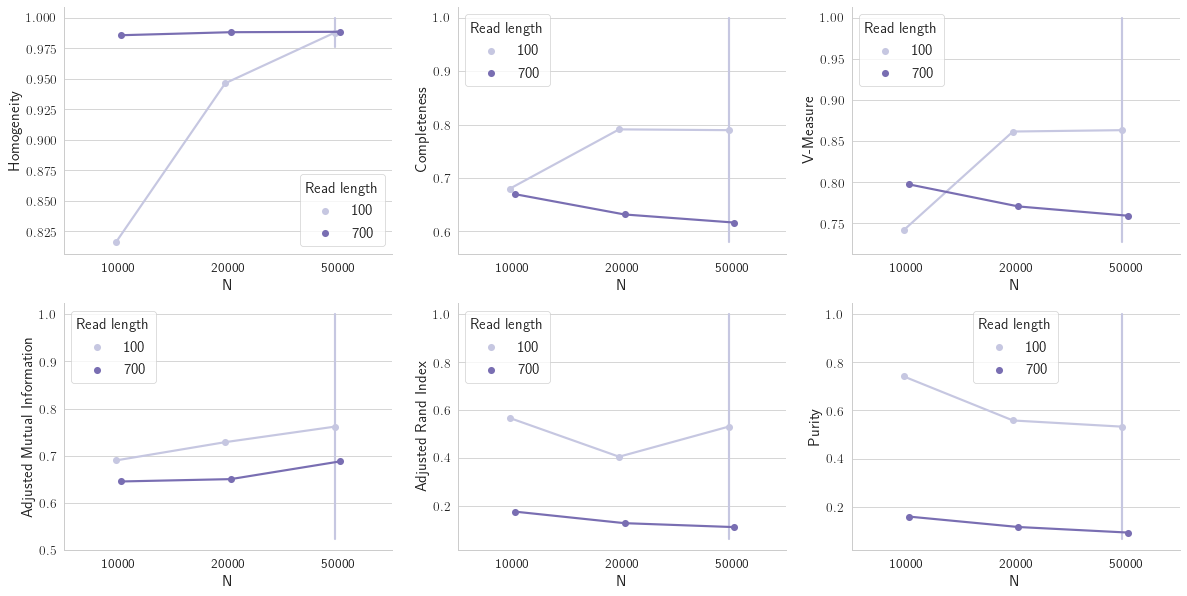

In [ ]:
quality_type = 'no_trivial'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & kmer_length == {k}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-k_{k}-{quality_type}')

### Fix window, compare cluster metrics against the number of simulated reads in the dataset, discriminating by length of those reads (100 or 700).

In [ ]:
w = 20

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-w_20.pdf


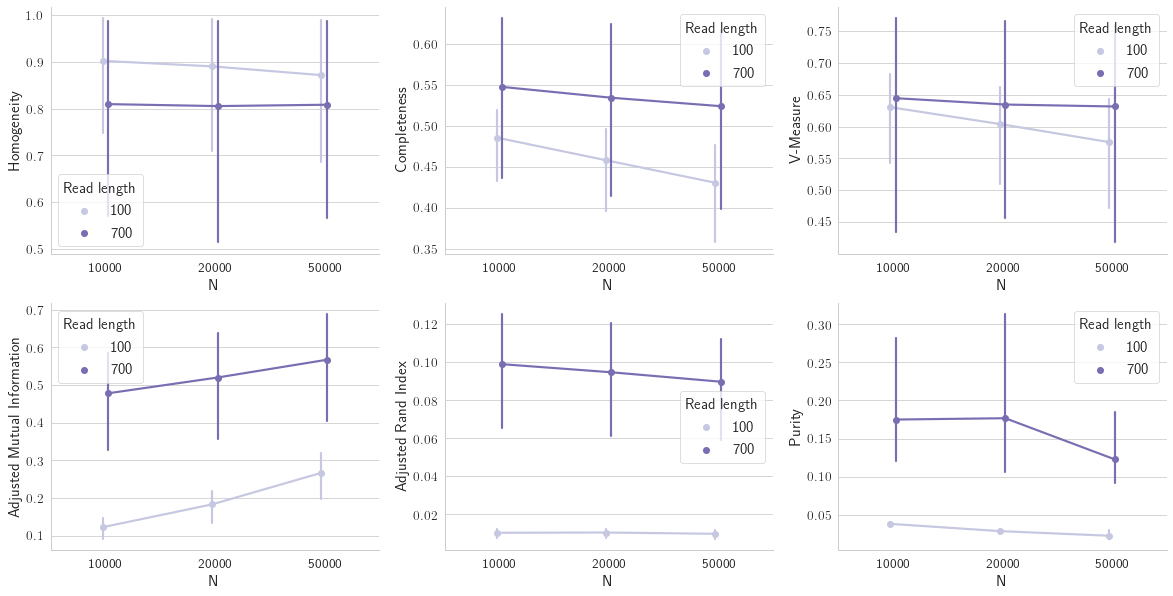

In [ ]:
selected_df = isONclust_csv.query(f'quality_type == "normal" & window == {w}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-w_{w}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-w_20-no_singleton.pdf


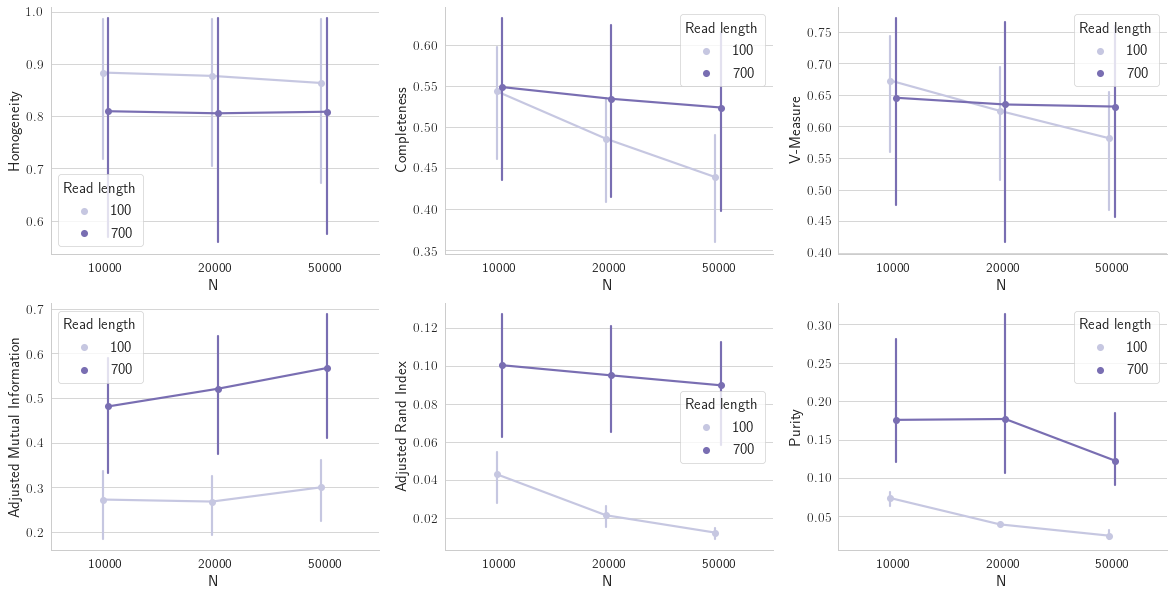

In [ ]:
quality_type = 'no_singleton'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & window == {w}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-w_{w}-{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-w_20-no_trivial.pdf


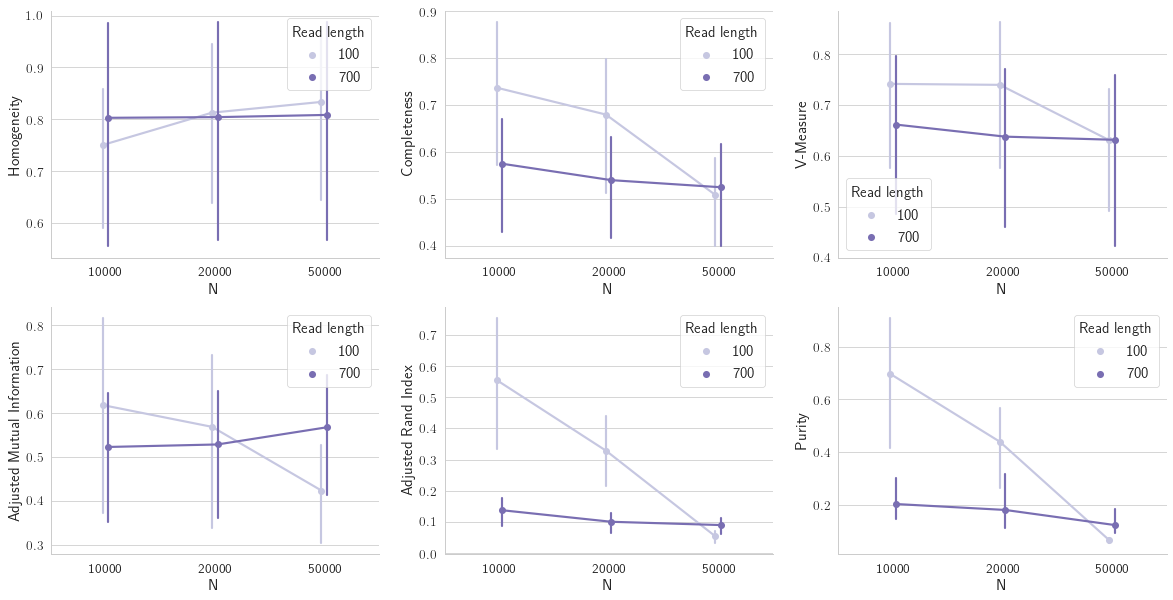

In [ ]:
quality_type = 'no_trivial'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & window == {w}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-w_{w}-{quality_type}')

In [ ]:
w = 50

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-w_50.pdf


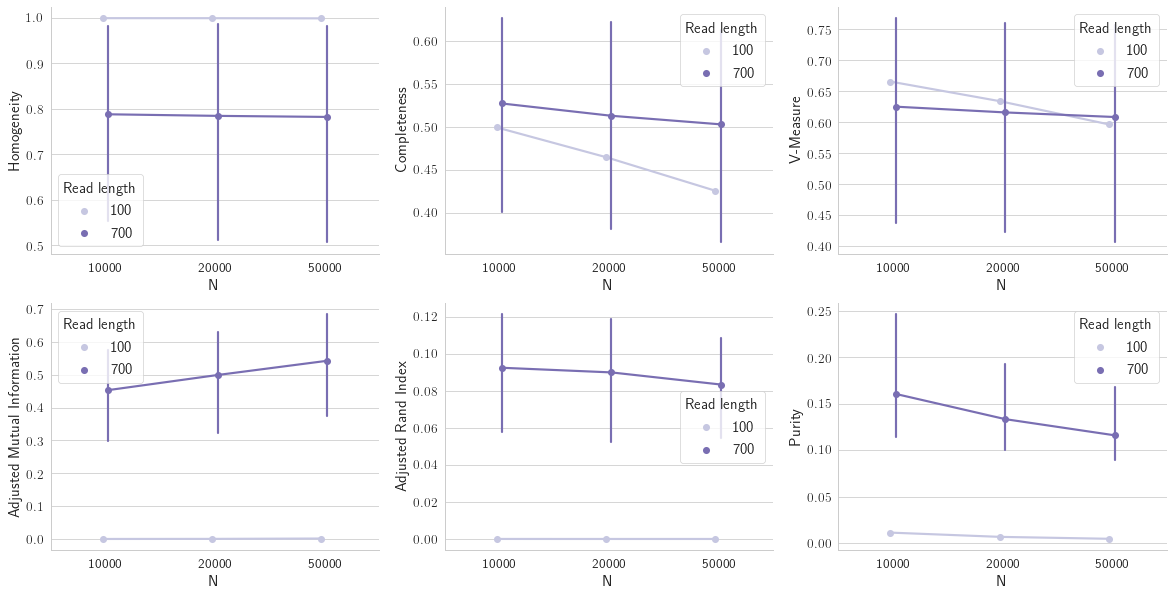

In [ ]:
selected_df = isONclust_csv.query(f'quality_type == "normal" & window == {w}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-w_{w}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-w_50-no_singleton.pdf


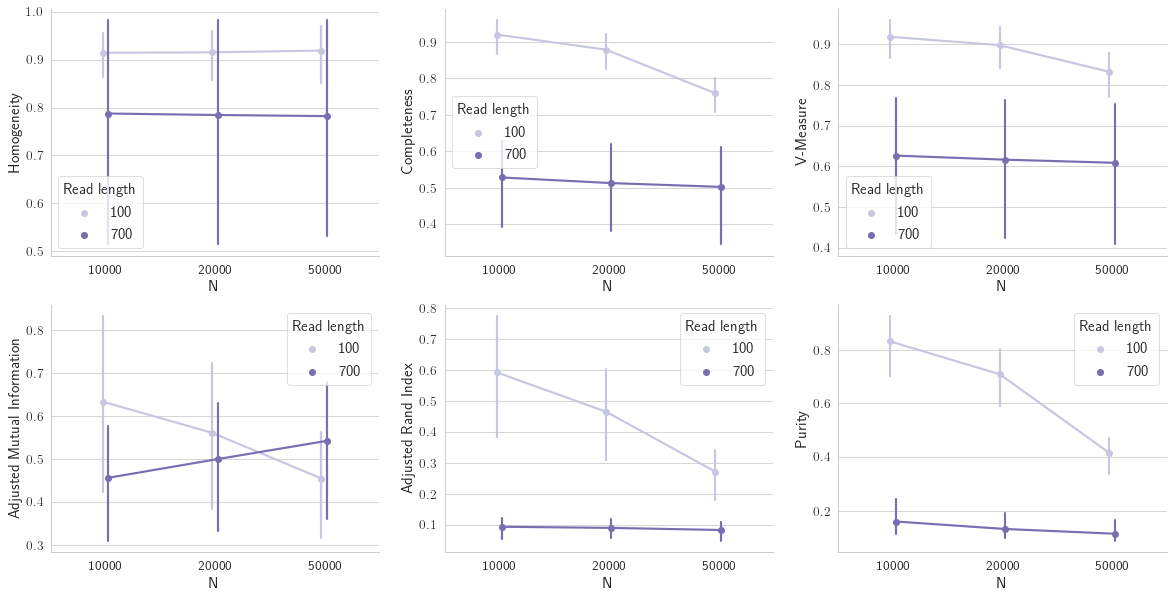

In [ ]:
quality_type = 'no_singleton'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & window == {w}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-w_{w}-{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_n_simulated_by_read_length-w_50-no_trivial.pdf


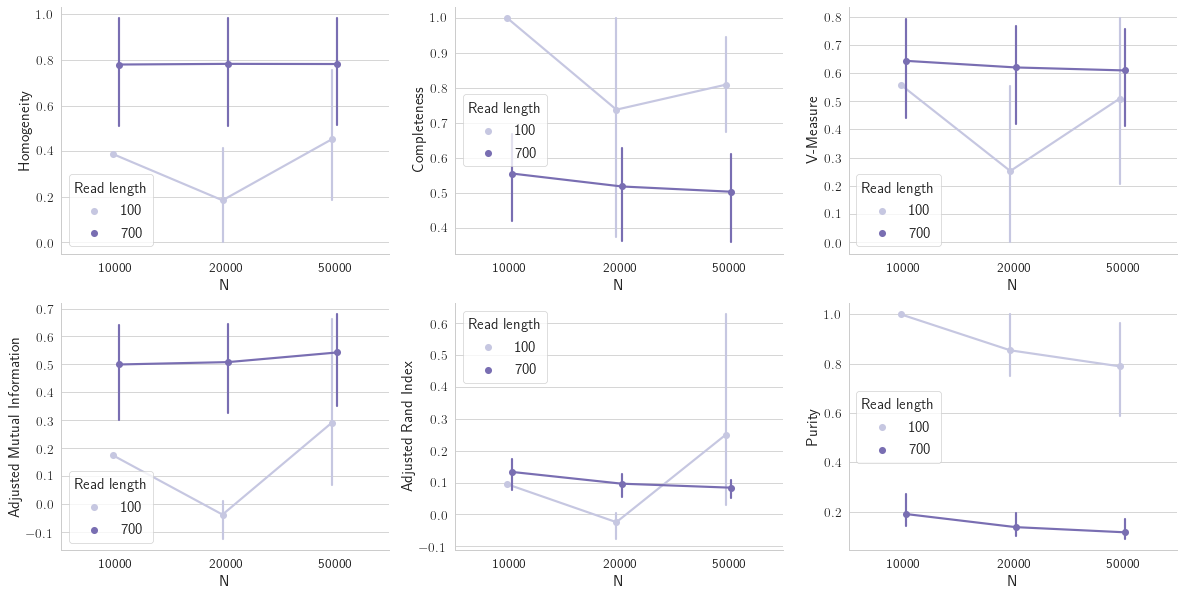

In [ ]:
quality_type = 'no_trivial'
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & window == {w}')
plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='n_simulated', xlabel='N',
                              hue='read_length', huelabel='Read length', postfix=f'-w_{w}-{quality_type}')

### Fixed the dataset, compare k-mer length with cluster metrics, discriminating by window size

#### read-length: 100, normal

In [ ]:
quality_type = 'normal'

In [ ]:
read_length = 100

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-10000_fl-100.pdf


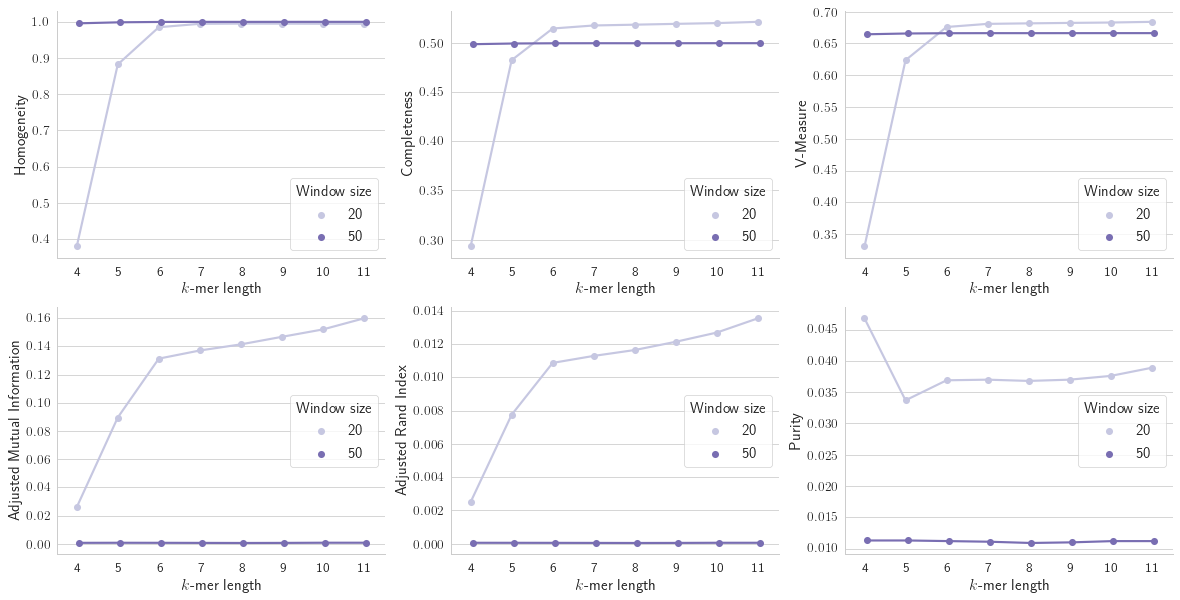

In [ ]:
n_simulated = 10000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-20000_fl-100.pdf


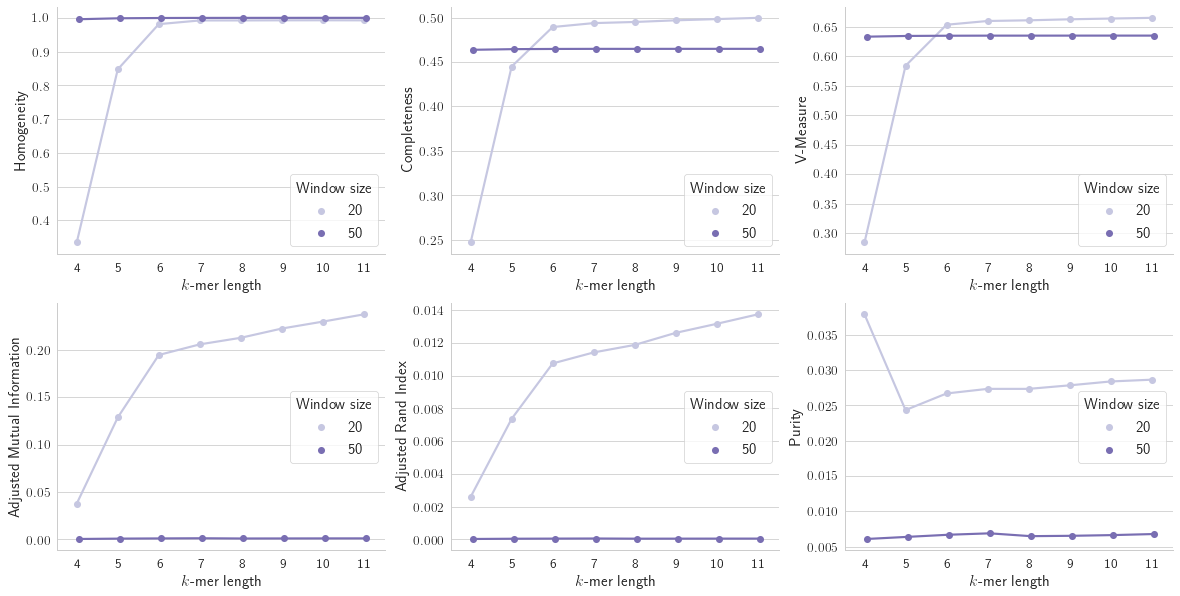

In [ ]:
n_simulated = 20000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-50000_fl-100.pdf


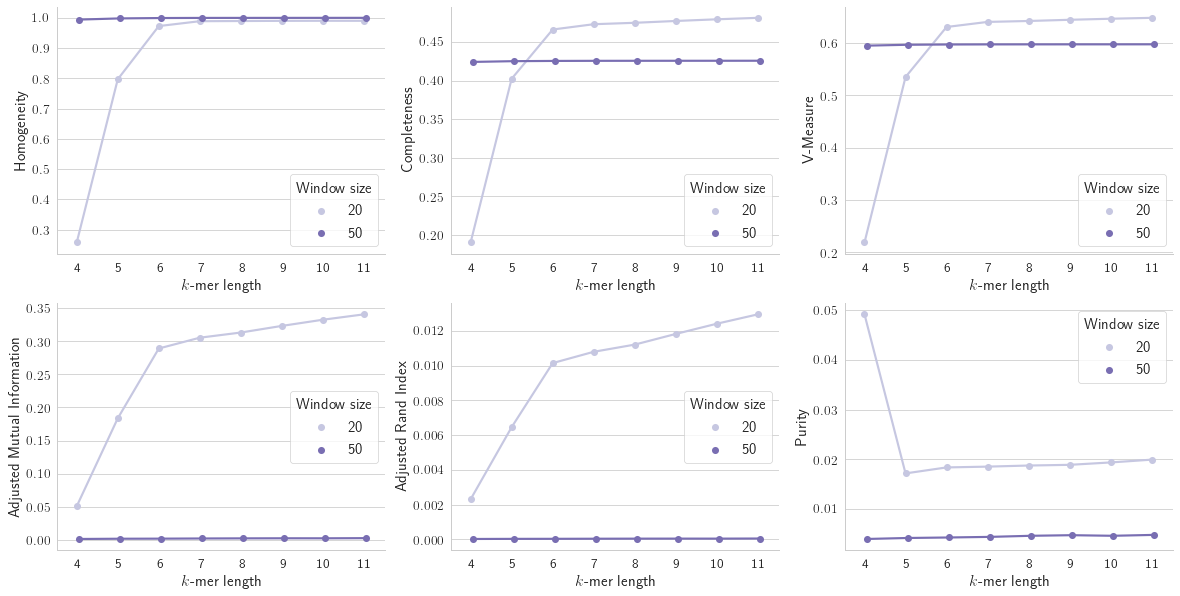

In [ ]:
n_simulated = 50000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}')

#### read-length: 700, normal

In [ ]:
read_length = 700

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-10000_fl-700.pdf


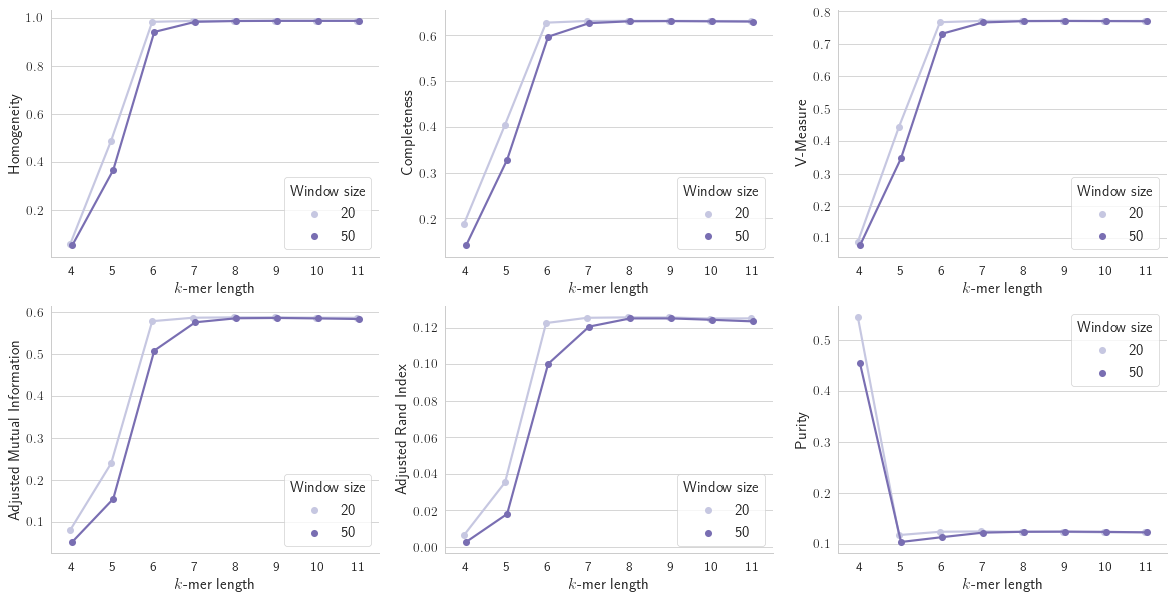

In [ ]:
n_simulated = 10000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-20000_fl-700.pdf


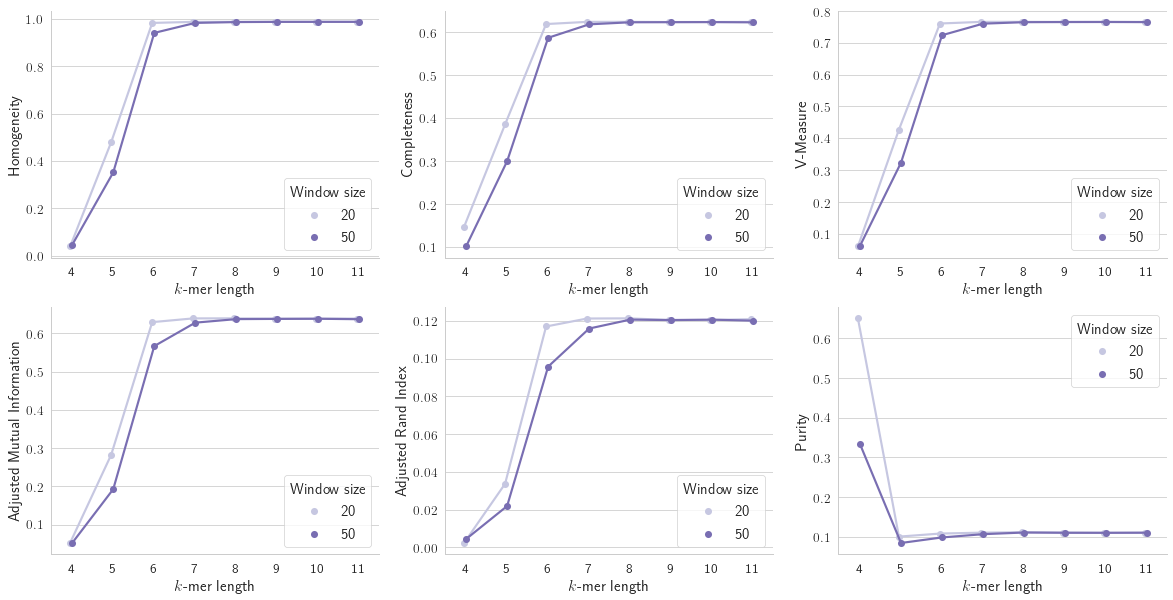

In [ ]:
n_simulated = 20000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-50000_fl-700.pdf


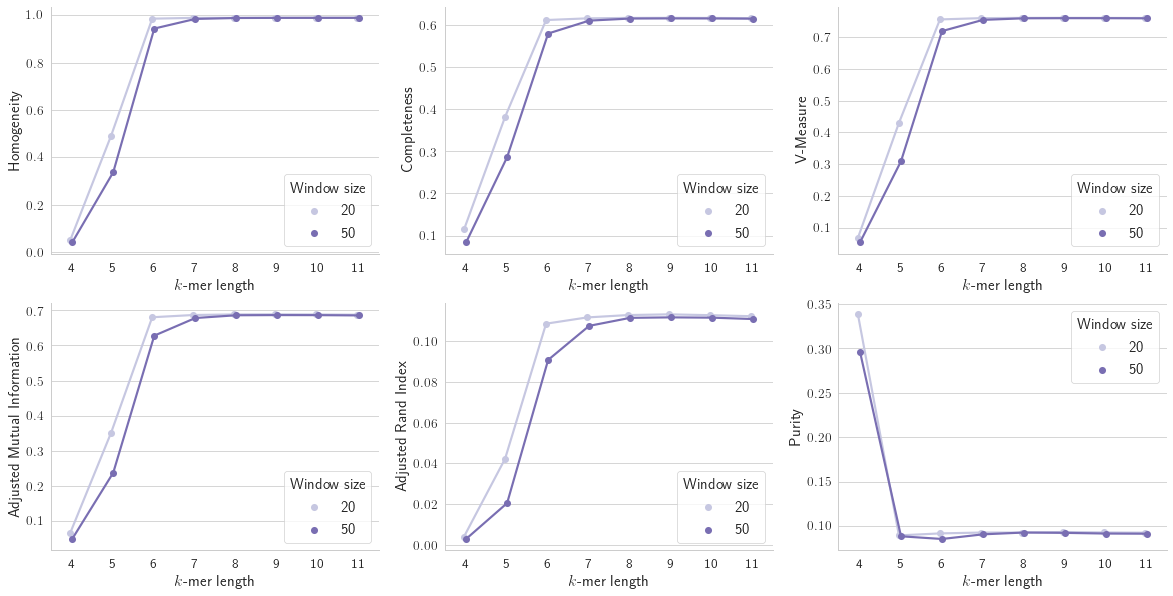

In [ ]:
n_simulated = 50000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}')

#### read-length: 100, no-singleton

In [ ]:
quality_type = 'no_singleton'

In [ ]:
read_length = 100

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-10000_fl-100_no_singleton.pdf


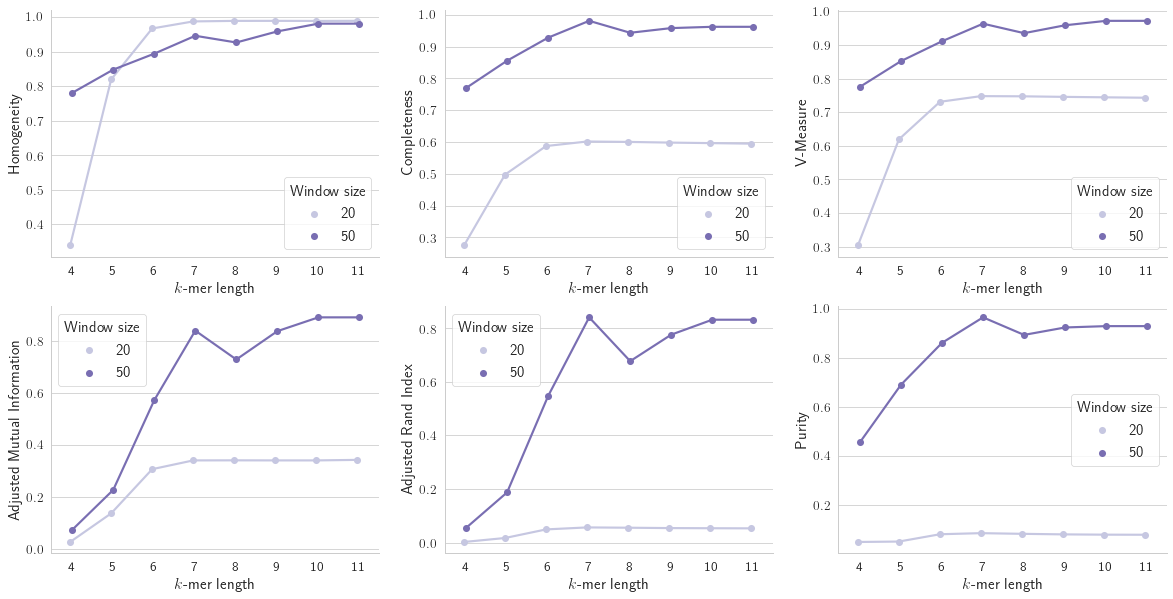

In [ ]:
n_simulated = 10000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}_{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-20000_fl-100_no_singleton.pdf


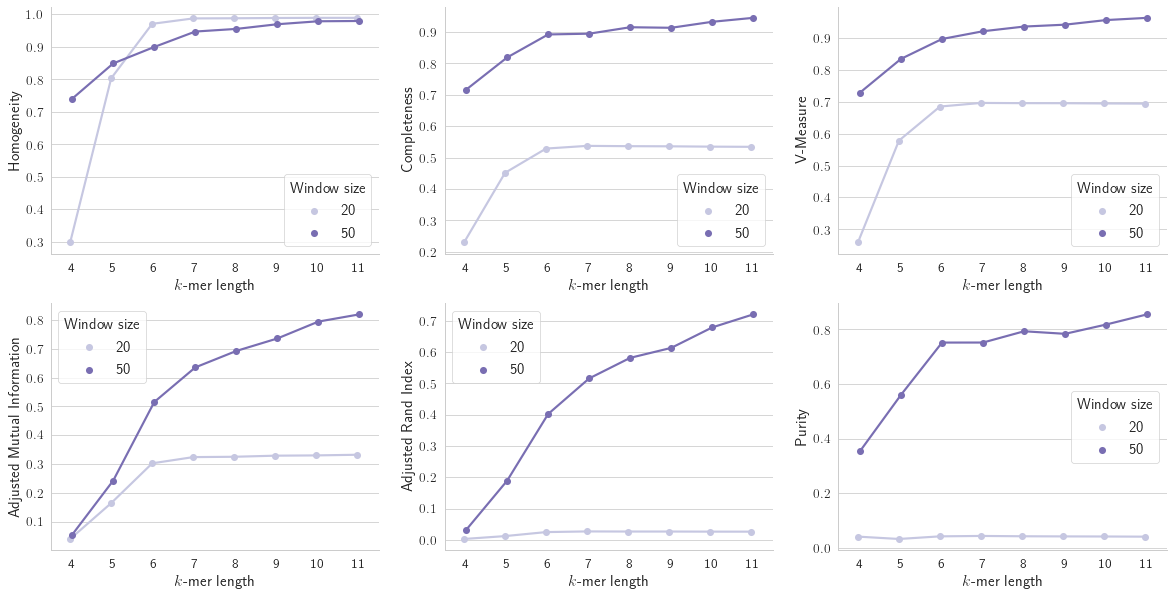

In [ ]:
n_simulated = 20000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}_{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-50000_fl-100_no_singleton.pdf


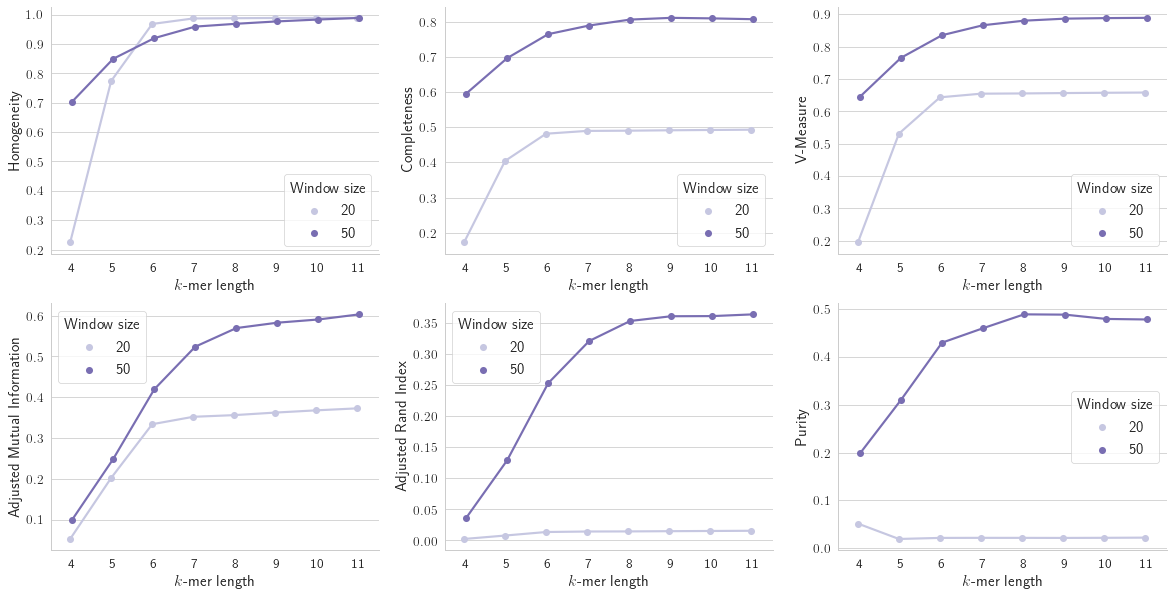

In [ ]:
n_simulated = 50000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}_{quality_type}')

#### read-length: 700, no-singleton

In [ ]:
read_length = 700

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-10000_fl-700_no_singleton.pdf


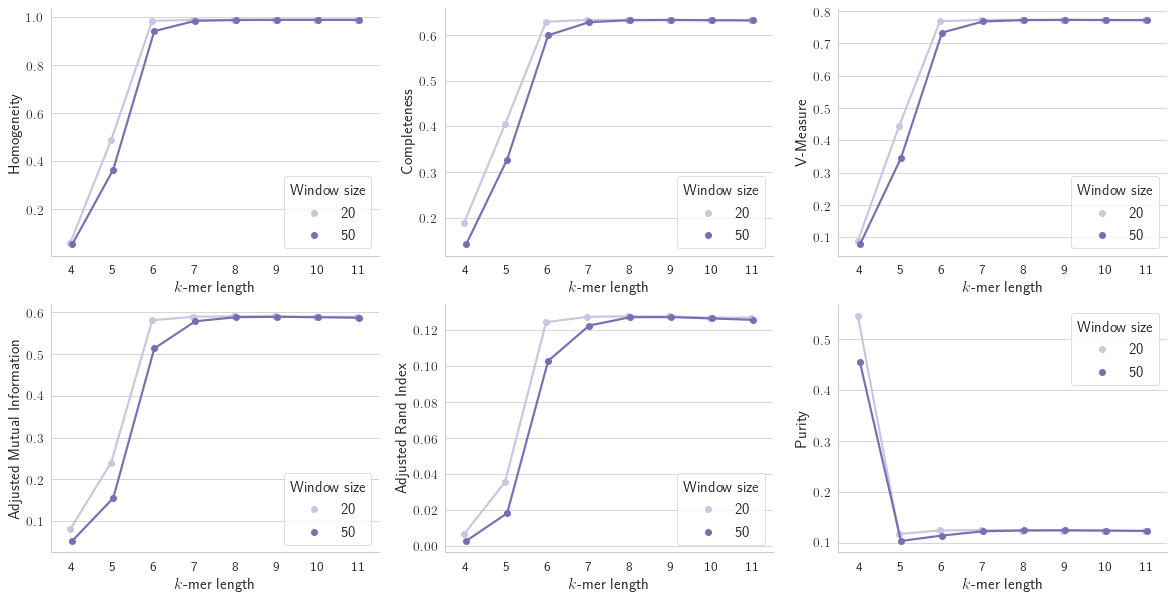

In [ ]:
n_simulated = 10000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}_{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-20000_fl-700_no_singleton.pdf


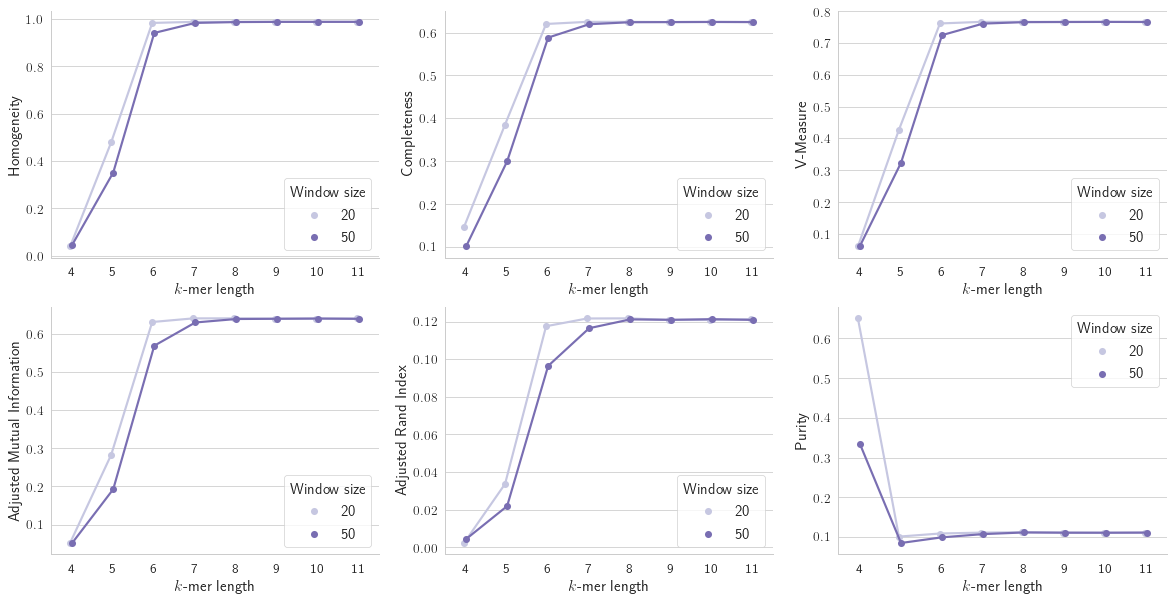

In [ ]:
n_simulated = 20000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}_{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-50000_fl-700_no_singleton.pdf


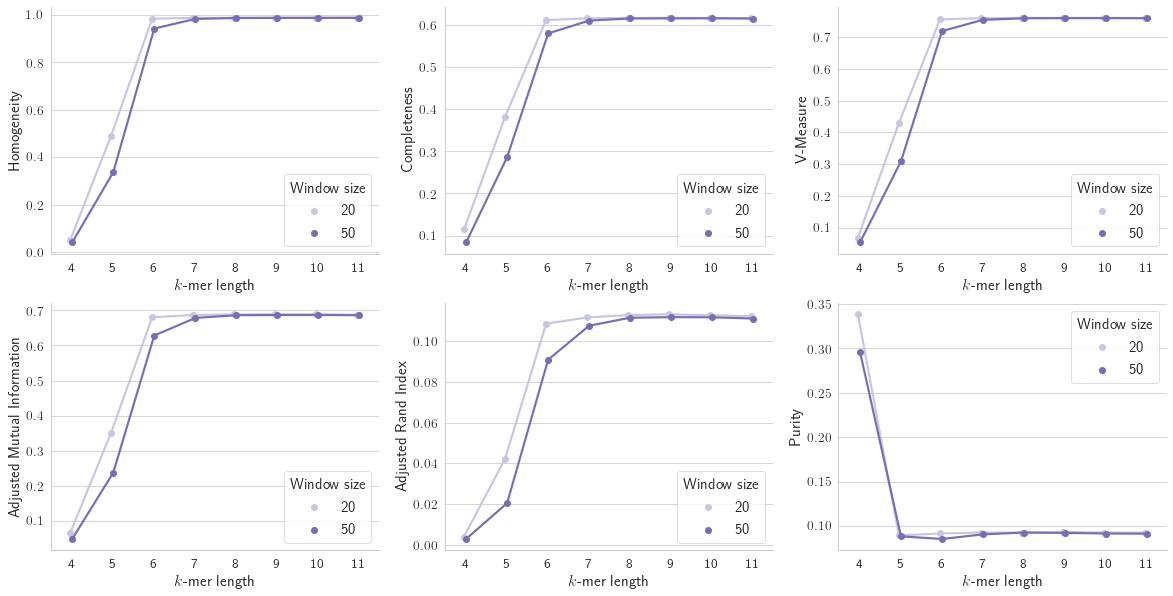

In [ ]:
n_simulated = 50000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}_{quality_type}')

#### read-length: 100, no-trivial

In [ ]:
quality_type = 'no_trivial'

In [ ]:
read_length = 100

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-10000_fl-100_no_trivial.pdf


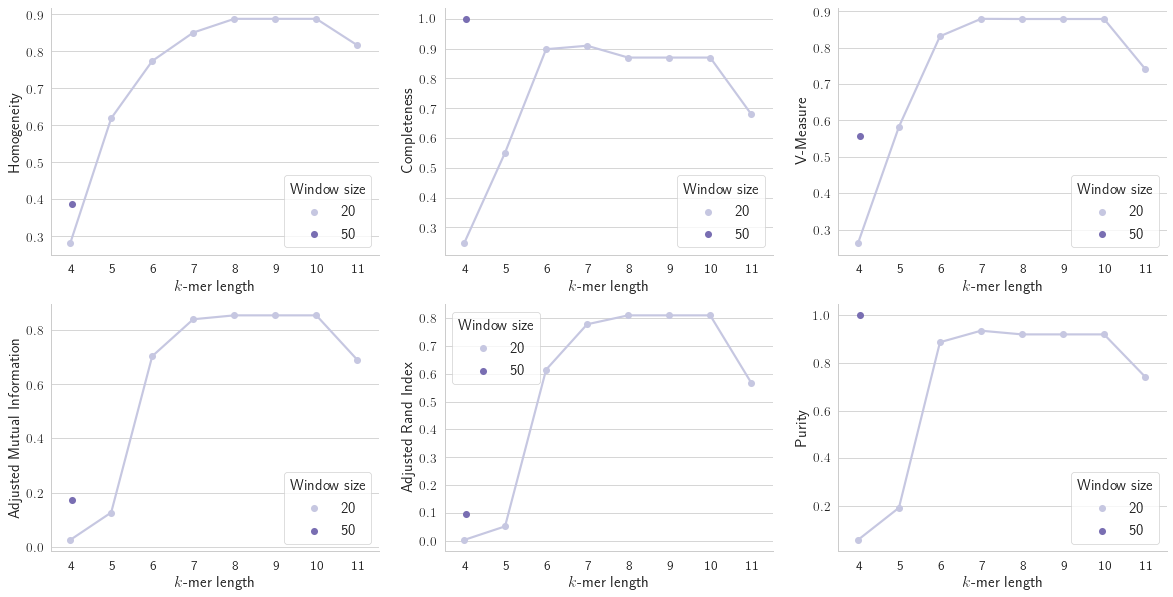

In [ ]:
n_simulated = 10000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}_{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-20000_fl-100_no_trivial.pdf


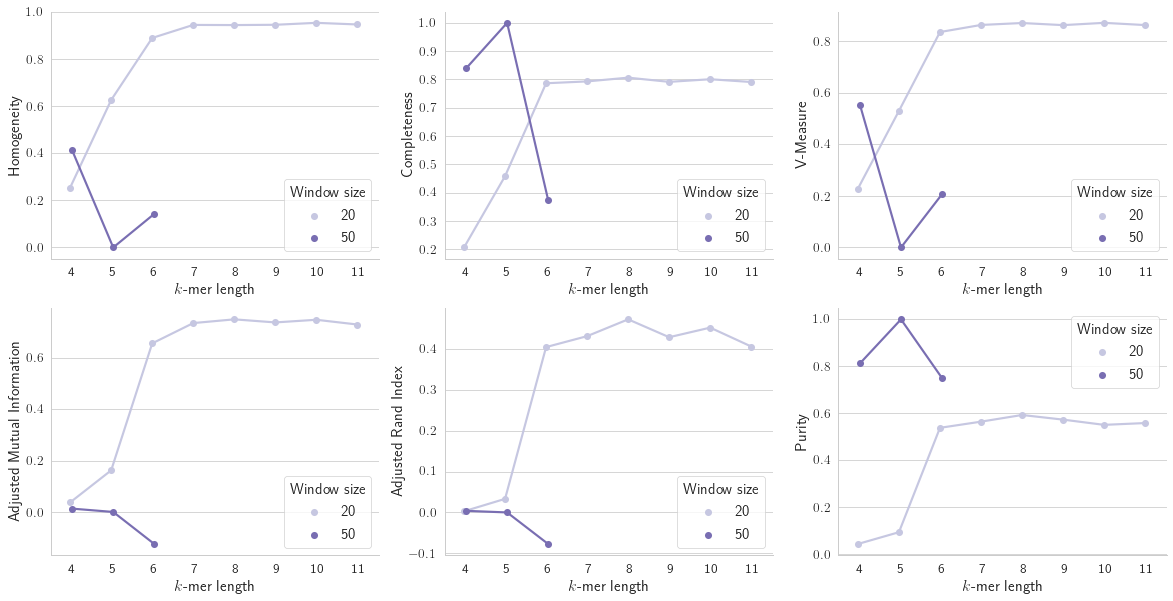

In [ ]:
n_simulated = 20000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}_{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-50000_fl-100_no_trivial.pdf


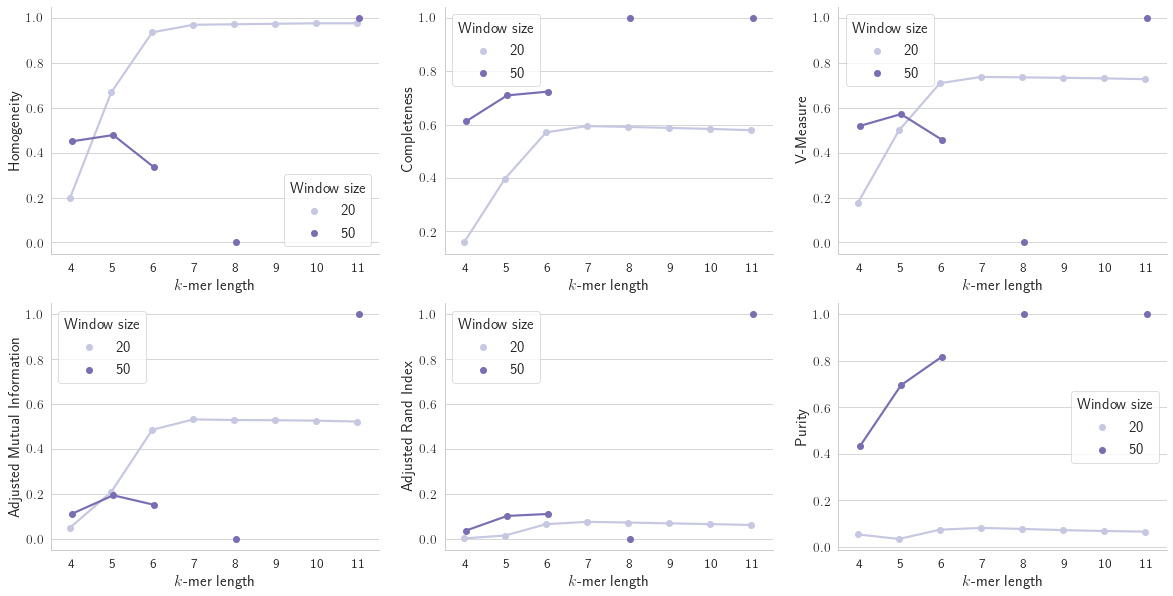

In [ ]:
n_simulated = 50000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}_{quality_type}')

#### read-length: 700, no-trivial

In [ ]:
read_length = 700

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-10000_fl-700_no_trivial.pdf


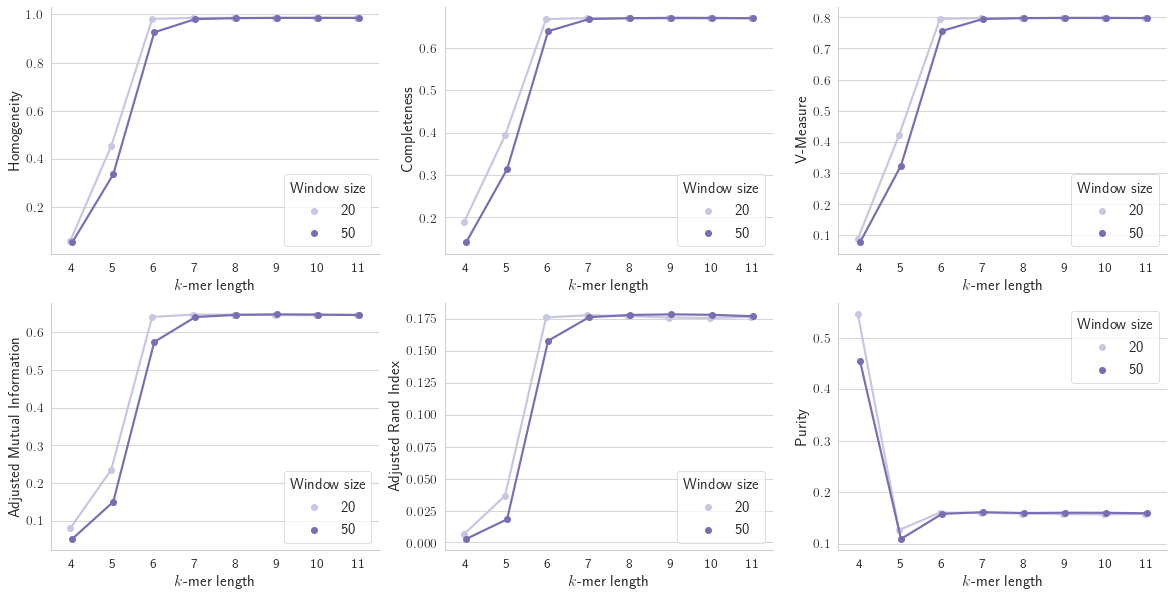

In [ ]:
n_simulated = 10000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}_{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-20000_fl-700_no_trivial.pdf


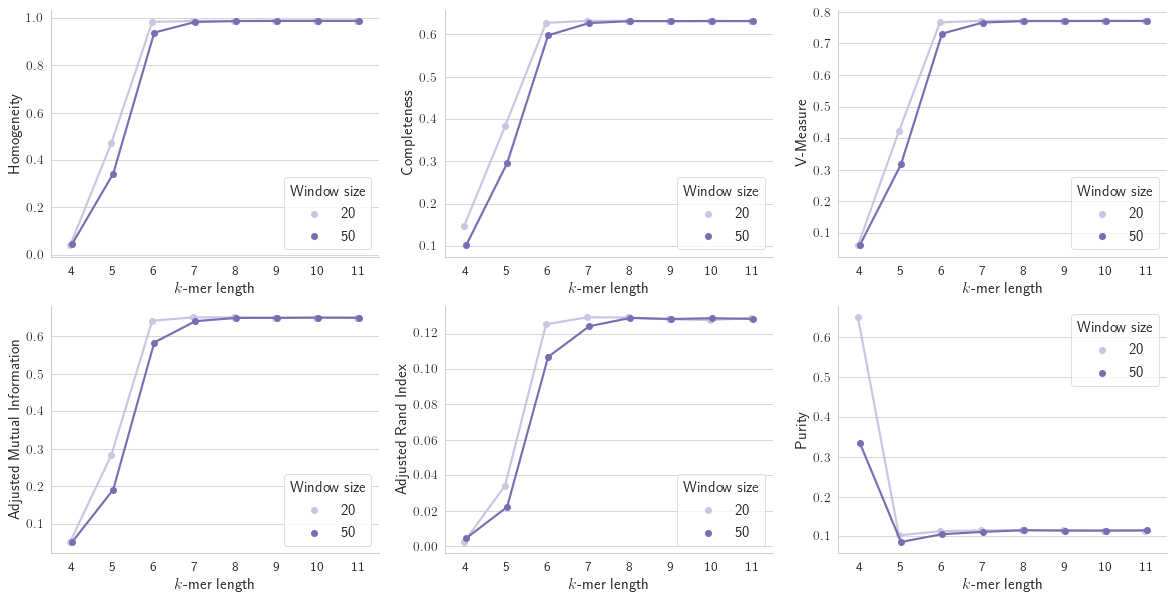

In [ ]:
n_simulated = 20000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}_{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-metrics_vs_kmer_length_by_window-n-50000_fl-700_no_trivial.pdf


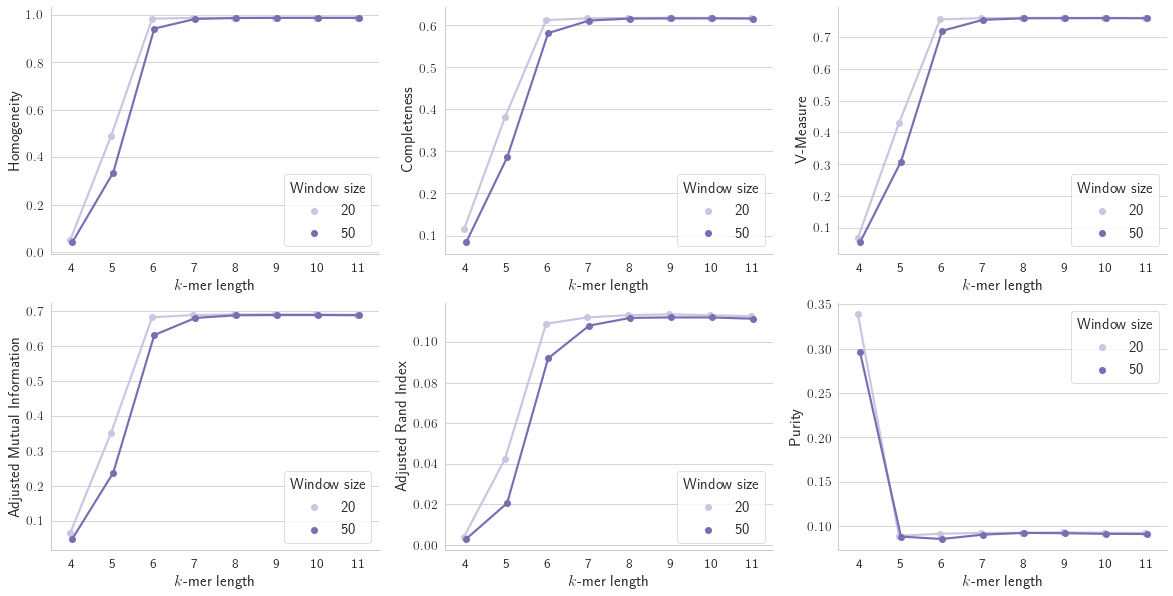

In [ ]:
n_simulated = 50000
selected_df = isONclust_csv \
  .query(f'quality_type == "{quality_type}" & n_simulated == {n_simulated} & read_length == {read_length}')

plot_main_metrics_vs_x_by_hue(tool='isONclust', data=selected_df,
                              x='kmer_length', xlabel='$k$-mer length',
                              hue='window', huelabel='Window size',
                              postfix=f'-n-{n_simulated}_fl-{read_length}_{quality_type}')

### Divergence from actual number of clusters

In [ ]:
import matplotlib.ticker as ticker

def plot_x_vs_cluster_divergence_by_dataset(data, x, xlabel, postfix=''):
  my_palette = sns.diverging_palette(h_neg=248, h_pos=2, s=74, l=43, sep=2, n=6, center='light')
  fig = plt.gcf()
  fig.set_size_inches(5.5, 4)

  min_k = np.min(selected_df['k'])
  max_k = np.max(selected_df['k'])
  mean_k = np.mean(selected_df['k'])
  median_k = np.median(selected_df['k'])

  sns.set_theme(context='paper', style='whitegrid', palette=my_palette, font_scale=1.1)

  ax = sns.barplot(x=x, y='k', data=data, hue='dataset', palette=my_palette, dodge=True, ci=None)
  ax.set_yscale('log')
  ax.yaxis.set_ticks([N_CLUSTERS_GROUND_TRUTH, min_k, mean_k, median_k, max_k])

  # convert y ticks to int
  ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

  ax.axhline(N_CLUSTERS_GROUND_TRUTH, ls='-', color='whitesmoke', label='Ground truth')
  ax.axhline(np.min(selected_df['k']), ls=':', color='lavender', label='Min')
  ax.axhline(np.median(selected_df['k']), ls=':', color='mediumspringgreen', label='Median')
  ax.axhline(np.mean(selected_df['k']), ls=':', color='lightseagreen', label='Average')

  num_of_datasets = len(data['dataset'].unique()) + 1
  handles, labels = ax.get_legend_handles_labels()
  hl_datasets = handles[num_of_datasets:], labels[num_of_datasets:]
  hl_lines = handles[:num_of_datasets], labels[:num_of_datasets]

  lines_legend = plt.legend(*hl_lines,
                            bbox_to_anchor=(1.43, 1), loc=2, borderaxespad=0.,
                            title='Line', title_fontsize='x-large', prop={'size': 12})

  datasets_legend = plt.legend(*hl_datasets, bbox_to_anchor=(1.03, 1),
                               loc=2, borderaxespad=0., title='Dataset',
                               title_fontsize='x-large', prop={'size': 12})

  fig.add_artist(lines_legend)

  ax.set_xlabel(xlabel)
  ax.set_ylabel('\# Clusters')

  filename = f'{PLOTS}isONclust-x_{x}-y_k-hue_dataset{postfix}.pgf'
  print(filename)
  fig.savefig(filename, dpi=100)

In [ ]:
fl = 700
selected_df = isONclust_csv.query(f'quality_type == "normal" & read_length == {fl}')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_window-y_k-hue_dataset-fl_700.pgf


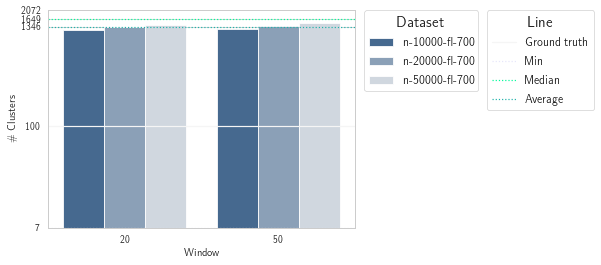

In [ ]:
plot_x_vs_cluster_divergence_by_dataset(data=selected_df, x='window', xlabel='Window', postfix=f'-fl_{fl}')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_k-hue_dataset-fl_700.pgf


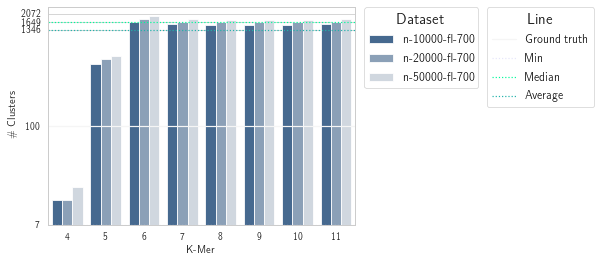

In [ ]:
plot_x_vs_cluster_divergence_by_dataset(data=selected_df, x='kmer_length', xlabel='K-Mer', postfix=f'-fl_{fl}')

In [ ]:
fl = 100
selected_df = isONclust_csv.query(f'quality_type == "normal" & read_length == {fl}')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_window-y_k-hue_dataset-fl_100.pgf


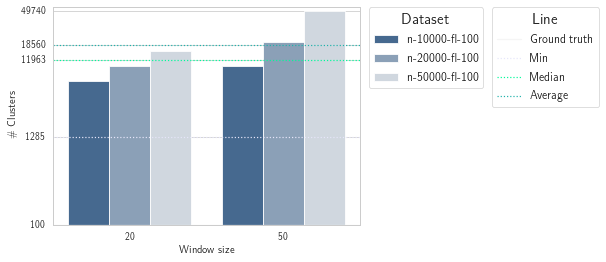

In [ ]:
plot_x_vs_cluster_divergence_by_dataset(data=selected_df, x='window', xlabel='Window size',
                                        postfix=f'-fl_{fl}')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_k-hue_dataset-fl_100.pgf


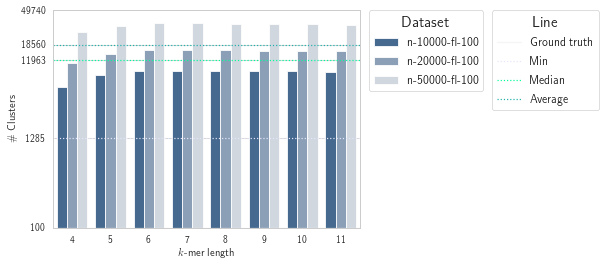

In [ ]:
plot_x_vs_cluster_divergence_by_dataset(data=selected_df, x='kmer_length', xlabel='$k$-mer length',
                                        postfix=f'-fl_{fl}')

In [ ]:
quality_type = 'no_trivial'
fl = 700
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & read_length == {fl}')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_window-y_k-hue_dataset-fl_700-no_trivial.pgf


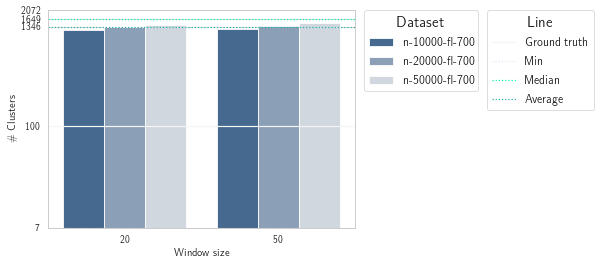

In [ ]:
plot_x_vs_cluster_divergence_by_dataset(data=selected_df, x='window', xlabel='Window size',
                                        postfix=f'-fl_{fl}-{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_k-hue_dataset-fl_700-no_trivial.pgf


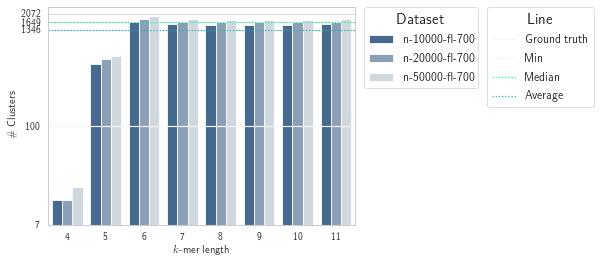

In [ ]:
plot_x_vs_cluster_divergence_by_dataset(data=selected_df, x='kmer_length', xlabel='$k$-mer length',
                                        postfix=f'-fl_{fl}-{quality_type}')

In [ ]:
quality_type = 'no_trivial'
fl = 100
selected_df = isONclust_csv.query(f'quality_type == "{quality_type}" & read_length == {fl}')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_window-y_k-hue_dataset-fl_100-no_trivial.pgf


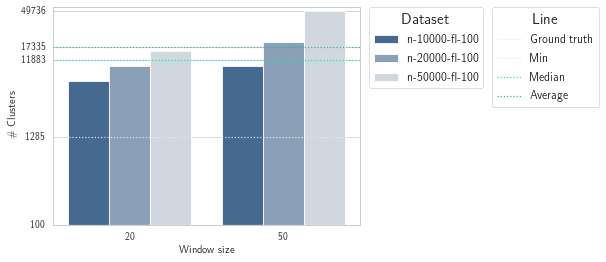

In [ ]:
plot_x_vs_cluster_divergence_by_dataset(data=selected_df, x='window', xlabel='Window size',
                                        postfix=f'-fl_{fl}-{quality_type}')

/content/drive/MyDrive/bioalgo/plots/isONclust-x_kmer_length-y_k-hue_dataset-fl_100-no_trivial.pgf


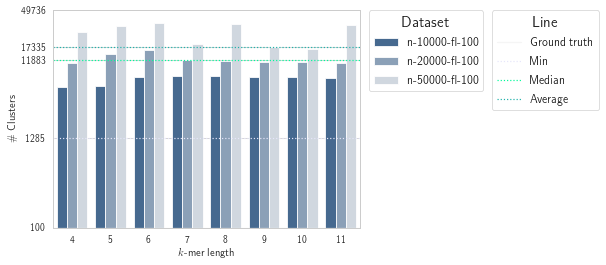

In [ ]:
plot_x_vs_cluster_divergence_by_dataset(data=selected_df, x='kmer_length', xlabel='$k$-mer length',
                                        postfix=f'-fl_{fl}-{quality_type}')

## Tables

In [ ]:
pd.options.display.precision = 4
pd.options.display.float_format = '{:,.4f}'.format

In [ ]:
def compute_qCluster_metric_table(metric_name: str, quality_type = 'no_trivial'):
  selected_df = qCluster_csv[['kmer_length', 'distance', 'read_length',
                              'n_simulated', 'quality_type', metric_name]] \
    .query(f'quality_type == "{quality_type}"') \
    .sort_values(by=['kmer_length', 'distance'], axis=0, ascending=True)

  return selected_df.pivot_table(index=['kmer_length', 'distance'],
                                 columns=['read_length', 'n_simulated'],
                                 values=[metric_name])

In [ ]:
def compute_isONclust_metric_table(metric_name: str, quality_type = 'no_trivial'):
  selected_df = isONclust_csv[['kmer_length', 'window', 'read_length',
                              'n_simulated', 'quality_type', metric_name]] \
    .query(f'quality_type == "{quality_type}"') \
    .sort_values(by=['kmer_length', 'window'], axis=0, ascending=True)

  return selected_df.pivot_table(index=['kmer_length', 'window'],
                                 columns=['read_length', 'n_simulated'],
                                 values=[metric_name])

In [ ]:
# n_clusters collapses the 3 counters for clustering results into a single
# symbol-separated string according to the sep parameter
def n_clusters_agg(sep: str):
  def n_clusters_agg_inner(x):
    return x[['k_non_trivial', 'k_trivial', 'k_singleton']] \
      .apply(lambda x: x.astype('str')) \
      .agg(sep.join, axis=1)

  return n_clusters_agg_inner


# deprecated
def compute_condensed_qCluster_n_cluster_table():
  return qCluster_n_clusters_csv \
    .assign(n_clusters=n_clusters_agg(sep='; ')) \
    .sort_values(by=['kmer_length', 'distance'], axis=0, ascending=True) \
    .drop(columns=['k', 'k_non_trivial', 'k_trivial', 'k_singleton']) \
    .pivot_table(index=['kmer_length', 'distance'],
                columns=['read_length', 'n_simulated'],
                values=['n_clusters'], aggfunc=lambda x: ' '.join(x))
  

# deprecated
def compute_condensed_isONclust_n_cluster_table():
  return isONclustr_n_clusters_csv \
    .assign(n_clusters=n_clusters_agg(sep='; ')) \
    .sort_values(by=['kmer_length', 'window'], axis=0, ascending=True) \
    .drop(columns=['k', 'k_non_trivial', 'k_trivial', 'k_singleton']) \
    .pivot_table(index=['kmer_length', 'window'],
                columns=['read_length', 'n_simulated'],
                values=['n_clusters'], aggfunc=lambda x: ' '.join(x))

In [ ]:
list(frozenset(['k_non_trivial', 'k_trivial', 'k_singleton']) - frozenset(['k_non_trivial']))

['k_trivial', 'k_singleton']

In [ ]:
def compute_qCluster_n_cluster_table(k_type: str):
  columns_to_drop = list(frozenset(['k_non_trivial', 'k_trivial', 'k_singleton']) - frozenset([k_type]))

  return qCluster_n_clusters_csv \
    .sort_values(by=['kmer_length', 'distance'], axis=0, ascending=True) \
    .drop(columns=['k', *columns_to_drop]) \
    .rename(columns={
        f'{k_type}': 'n_clusters',
    }) \
    .pivot_table(index=['kmer_length', 'distance'],
                columns=['read_length', 'n_simulated'],
                values=['n_clusters'])
    

def compute_isONclust_n_cluster_table(k_type: str):
  columns_to_drop = list(frozenset(['k_non_trivial', 'k_trivial', 'k_singleton']) - frozenset([k_type]))

  return isONclust_n_clusters_csv \
    .sort_values(by=['kmer_length', 'window'], axis=0, ascending=True) \
    .drop(columns=['k', *columns_to_drop]) \
    .rename(columns={
        f'{k_type}': 'n_clusters',
    }) \
    .pivot_table(index=['kmer_length', 'window'],
                columns=['read_length', 'n_simulated'],
                values=['n_clusters'])

In [ ]:
def compute_qCluster_cluster_statistics(dataset: str):
  return qCluster_csv[['k', 'min_size', 'max_size', 'avg_size', 'std_size',
                       'dataset', 'quality_type', 'distance', 'kmer_length']] \
    .sort_values(by=['kmer_length', 'distance'], axis=0, ascending=True) \
    .query(f'quality_type == "normal" & dataset == "{dataset}"') \
    .drop(columns=['quality_type']) \
    .rename(columns={
      'k': 'N clusters',
     }) \
     .pivot_table(index=['kmer_length', 'distance'],
                  columns=[],
                  values=['N clusters', 'min_size', 'max_size', 'avg_size', 'std_size'])
     

def compute_isONclust_cluster_statistics(dataset: str):
  return isONclust_csv[['k', 'min_size', 'max_size', 'avg_size', 'std_size',
                        'dataset', 'quality_type', 'window', 'kmer_length']] \
    .sort_values(by=['kmer_length', 'window'], axis=0, ascending=True) \
    .query(f'quality_type == "normal" & dataset == "{dataset}"') \
    .drop(columns=['quality_type']) \
    .rename(columns={
      'k': 'N clusters',
     }) \
     .pivot_table(index=['kmer_length', 'window'],
                  columns=[],
                  values=['N clusters', 'min_size', 'max_size', 'avg_size', 'std_size'])

### QCluster: cluster statistics per dataset

#### Dataset: n-10000-fl-100

In [ ]:
dataset = 'n-10000-fl-100'
compute_qCluster_cluster_statistics(dataset) \
  .style \
  .highlight_max(axis=0)

#### Dataset: n-10000-fl-700

In [ ]:
dataset = 'n-10000-fl-700'
compute_qCluster_cluster_statistics(dataset) \
  .style \
  .highlight_max(axis=0)

#### Dataset: n-20000-fl-100

In [ ]:
dataset = 'n-20000-fl-100'
compute_qCluster_cluster_statistics(dataset) \
  .style \
  .highlight_max(axis=0)

#### Dataset: n-20000-fl-700

In [ ]:
dataset = 'n-20000-fl-700'
compute_qCluster_cluster_statistics(dataset) \
  .style \
  .highlight_max(axis=0)

#### Dataset: n-50000-fl-100

In [ ]:
dataset = 'n-50000-fl-100'
compute_qCluster_cluster_statistics(dataset) \
  .style \
  .highlight_max(axis=0)

#### Dataset: n-50000-fl-700

In [ ]:
dataset = 'n-50000-fl-700'
compute_qCluster_cluster_statistics(dataset) \
  .style \
  .highlight_max(axis=0)

### isONclust: cluster statistics per dataset

#### Dataset: n-10000-fl-100

In [ ]:
dataset = 'n-10000-fl-100'
compute_isONclust_cluster_statistics(dataset) \
  .style \
  .highlight_max(axis=0)

#### Dataset: n-10000-fl-700

In [ ]:
dataset = 'n-10000-fl-700'
compute_isONclust_cluster_statistics(dataset) \
  .style \
  .highlight_max(axis=0)

#### Dataset: n-20000-fl-100

In [ ]:
dataset = 'n-20000-fl-100'
compute_isONclust_cluster_statistics(dataset) \
  .style \
  .highlight_max(axis=0)

#### Dataset: n-20000-fl-700

In [ ]:
dataset = 'n-20000-fl-700'
compute_isONclust_cluster_statistics(dataset) \
  .style \
  .highlight_max(axis=0)

#### Dataset: n-50000-fl-100

In [ ]:
dataset = 'n-50000-fl-100'
compute_isONclust_cluster_statistics(dataset) \
  .style \
  .highlight_max(axis=0)

#### Dataset: n-50000-fl-700

In [ ]:
dataset = 'n-50000-fl-700'
compute_isONclust_cluster_statistics(dataset) \
  .style \
  .highlight_max(axis=0)

### QCluster: \# clusters

#### Non-trivial

In [ ]:
compute_qCluster_n_cluster_table('k_non_trivial') \
  .style \
  .highlight_max(axis=0)

#### Trivial

In [ ]:
compute_qCluster_n_cluster_table('k_trivial') \
  .style \
  .highlight_max(axis=0)

#### Singleton

In [ ]:
compute_qCluster_n_cluster_table('k_singleton') \
  .style \
  .highlight_max(axis=0)

### isONclust: \# clusters

#### Non-trivial

In [ ]:
compute_isONclust_n_cluster_table('k_non_trivial') \
  .style \
  .highlight_max(axis=0)

#### Trivial

In [ ]:
compute_isONclust_n_cluster_table('k_trivial') \
  .style \
  .highlight_max(axis=0)

#### Singleton

In [ ]:
compute_isONclust_n_cluster_table('k_singleton') \
  .style \
  .highlight_max(axis=0)

### QCluster

#### Homogeneity

In [ ]:
metric_name = 'homogeneity'

compute_qCluster_metric_table(metric_name=metric_name, quality_type='no_trivial') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### Completeness

In [ ]:
metric_name = 'completeness'

compute_qCluster_metric_table(metric_name=metric_name, quality_type='no_trivial') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### V-Measure

In [ ]:
metric_name = 'v_measure'

compute_qCluster_metric_table(metric_name=metric_name, quality_type='no_trivial') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### Adjusted Mutual Information

In [ ]:
metric_name = 'adjusted_mutual_information'

compute_qCluster_metric_table(metric_name=metric_name, quality_type='no_trivial') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### Adjusted Rand Index

In [ ]:
metric_name = 'adjusted_rand_index'

compute_qCluster_metric_table(metric_name=metric_name, quality_type='no_trivial') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### Purity

In [ ]:
metric_name = 'purity'

compute_qCluster_metric_table(metric_name=metric_name, quality_type='no_trivial') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

### isONclust (non-trivial)

#### Homogeneity

In [ ]:
metric_name = 'homogeneity'

compute_isONclust_metric_table(metric_name=metric_name, quality_type='no_trivial') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### Completeness

In [ ]:
metric_name = 'completeness'

compute_isONclust_metric_table(metric_name=metric_name, quality_type='no_trivial') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### V-Measure

In [ ]:
metric_name = 'v_measure'

compute_isONclust_metric_table(metric_name=metric_name, quality_type='no_trivial') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### Adjusted Mutual Information

In [ ]:
metric_name = 'adjusted_mutual_information'

compute_isONclust_metric_table(metric_name=metric_name, quality_type='no_trivial') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### Adjusted Rand Index

In [ ]:
metric_name = 'adjusted_rand_index'

compute_isONclust_metric_table(metric_name=metric_name, quality_type='no_trivial') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### Purity

In [ ]:
metric_name = 'purity'

compute_isONclust_metric_table(metric_name=metric_name, quality_type='no_trivial') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

### isONclust (no-singleton)

In [ ]:
pd.options.display.precision = 5
pd.options.display.float_format = '{:,.5f}'.format

#### Homogeneity

In [ ]:
metric_name = 'homogeneity'

compute_isONclust_metric_table(metric_name=metric_name, quality_type='no_singleton') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### Completeness

In [ ]:
metric_name = 'completeness'

compute_isONclust_metric_table(metric_name=metric_name, quality_type='no_singleton') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### V-Measure

In [ ]:
metric_name = 'v_measure'

compute_isONclust_metric_table(metric_name=metric_name, quality_type='no_singleton') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### Adjusted Mutual Information

In [ ]:
metric_name = 'adjusted_mutual_information'

compute_isONclust_metric_table(metric_name=metric_name, quality_type='no_singleton') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### Adjusted Rand Index

In [ ]:
metric_name = 'adjusted_rand_index'

compute_isONclust_metric_table(metric_name=metric_name, quality_type='no_singleton') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

#### Purity

In [ ]:
metric_name = 'purity'

compute_isONclust_metric_table(metric_name=metric_name, quality_type='no_singleton') \
  .style \
  .set_na_rep('-') \
  .highlight_max(axis=0)

## Citing

`QCluster`:

```
  @article{Comin2015,
    doi = {10.1186/s13015-014-0029-x},
    url = {https://doi.org/10.1186/s13015-014-0029-x},
    year = {2015},
    month = jan,
    publisher = {Springer Science and Business Media {LLC}},
    volume = {10},
    number = {1},
    author = {Matteo Comin and Andrea Leoni and Michele Schimd},
    title = {Clustering of reads with alignment-free measures and quality values},
    journal = {Algorithms for Molecular Biology}
  }
```

`isONclust`:

```
  @incollection{Sahlin2019,
    doi = {10.1007/978-3-030-17083-7_14},
    url = {https://doi.org/10.1007/978-3-030-17083-7_14},
    year = {2019},
    publisher = {Springer International Publishing},
    pages = {227--242},
    author = {Kristoffer Sahlin and Paul Medvedev},
    title = {De Novo Clustering of Long-Read Transcriptome Data Using a Greedy,  Quality-Value Based Algorithm},
    booktitle = {Lecture Notes in Computer Science}
  }
```